This notebook will ....

In [2]:
import pygama
import pygama.lh5 as lh5
import matplotlib.pyplot as plt
import numpy as np
import h5py
from pygama.dsp.processors import pole_zero
plt.rcParams['figure.figsize'] = [10, 10]
import json
from scipy.stats import zscore
from scipy.optimize import curve_fit

In [3]:
#importing waveform files 
new_raw = f'/unix/legend/wquinn/discharges/raw_files/ '
sto = lh5.Store() # we require this to read 
fw_new1=f'/unix/legend/wquinn/discharges/raw_files/l200-p06-r007-tst-20230726T004658Z_tier_raw.lh5'

In [4]:
#importing JSON file which describes each detector 
f = open('channel_maps.json','r')
cmap = json.load(f)

In [5]:
target_bege = "bege"

# Iterate through cmap to find the key for the desired_type
matching_bege = [key for key, value in cmap.items() if "type" in value and value["type"] == target_bege]

In [6]:
# Character to add
ch = "ch"

# Use list comprehension to add ch to each element in the array
detectors_bege = [ch+element for element in matching_bege]

**Initial Imports**

In this section I import all the data and form dictionaries so the data can easily be acsessed throughout the notebook.

In [7]:
tb_data_dict = {}  # Dictionary to store tb_data for each detector
wfs_all_dict = {}  # Dictionary to store wfs_all for each detector

for j in detectors_bege:
    tb_data_dict[j] = sto.read_object(f'/{j}/raw', fw_new1)[0]
    wfs_all_dict[j] = tb_data_dict[j]['waveform']['values'].nda

**Minimum value determination**

Determining the minimum values of the waveforms.

In [8]:
def minimum_values(wfs_all_dict,index):
    """ Determines the minimum values of 
    a waveform.
    Inputs:
    wfs_all_dict - the dictionary storing all waveforms 
    index - the name of the detector, to extract waveforms
    from the waveform dictionary
    Ouputs:
    min_values - minimum values 
    """
    wfs_all = wfs_all_dict[index]
    
    # Initialize empty lists to store min and max values
    min_values = []
    
    # Loop through all waveforms to find the min values
    for i in range(len(wfs_all)):
        wf0 = wfs_all[i, :]
        wf_min = np.min(wf0)
        min_values.append(wf_min)
    return min_values

In [9]:
minimum_dict={}
for j in detectors_bege:
    minimum_dict[j]=minimum_values(wfs_all_dict,j) 

**Initial cuts**

Discharges typically have a smaller minimum value than calibration events and hence it is easier to remove baselines and testing data.

In [10]:
def zcalc(zscore_threshold,min_values):
    """ Filters values depending on their z-score
    by their distance from the threshold.
    Inputs:
    zscore_threshold - threshold to extract values above/
    below 
    min_values - the values to be used in the z-score
    Outputs:
    filtered_min_values - values which are within the zscore threshold
    skipped_min_values - values which are outside the zscore threshold
    index_skip - the waveforms which are outside the zscore threshold
    index_filter - the waveforms which are inside the zscore threshold
    """
    # Calculate Z-scores for the minimum values
    min_z_scores = zscore(min_values)
    
    # Initialize empty list to store filtered min values
    filtered_min_values = []
    skipped_min_values= []
    index_skip = []
    index_filter = []
    
    # Loop through Z-scores and filter out anomalies
    for i, z_score in enumerate(min_z_scores):
        # Check if the Z-score for the min value is beyond the threshold
        if z_score < -zscore_threshold:
            skipped_min_values.append(min_values[i])
            index_skip.append(i)
            # If beyond the threshold, skip this iteration
            continue
        
        # Append the min value to the filtered list
        filtered_min_values.append(min_values[i])
        index_filter.append(i)
    return filtered_min_values,skipped_min_values,index_skip,index_filter

In [11]:
threshold = 1 #one standard deviation 
filtered_values ={}
skipped_values = {}
skipped_index = {}
filtered_index = {}

for j in detectors_bege:
    filtered_values[j],skipped_values[j],skipped_index[j],filtered_index[j]=zcalc(threshold,minimum_dict[j])

Introducing a parameter which will tell how many waveforms were correctly removed.

Another cut but now for the maximal value 

In [12]:
def maximum_values(wfs_all_dict,index):
    """Determines the maximum values of 
    a waveform.
    Inputs:
    wfs_all_dict - the dictionary storing all waveforms 
    index - the name of the detector, to extract waveforms
    from the waveform dictionary
    Ouputs:
    max_values - maximum values 
    """
    wfs_all = wfs_all_dict[index]
    index_skip = skipped_index[index]
    
    max_values = []
    
    # Loop through all waveforms to find the min and max values
    for i in index_skip:
        wf0 = wfs_all[i, :]
        wf_max = np.max(wf0)
        # Append min and max values to the lists
        max_values.append(wf_max)
    
    return max_values

In [13]:
maximum_dict={}

for j in detectors_bege:
    maximum_dict[j]=maximum_values(wfs_all_dict,j)

In [14]:
def zcalc_max(zscore_threshold,maximum_values,index):
    """Filters values depending on their z-score
    by their distance from the threshold.
    Inputs:
    zscore_threshold - threshold to extract values above/
    below 
    maximum_values - the values to be used in the z-score
    index - detector index for previous dictionaries
    Outputs:
    filtered_max_values - values which are within the zscore threshold
    skipped_max_values - values which are outside the zscore threshold
    index_skipm - the waveforms which are outside the zscore threshold
    index_filterm - the waveforms which are inside the zscore threshold
    """
    # Calculate Z-scores for the maximum values
    max_z_scores = zscore(maximum_values)
    index_skip = skipped_index[index]
    max_values = maximum_dict[index]

    # Initialize empty lists to store filtered and skipped max values, as well as their corresponding indices
    filtered_max_values = []
    skipped_max_values = []
    index_skipm = []
    index_filterm = []
    
    # Loop through Z-scores and filter out anomalies
    for i, z_score in enumerate(max_z_scores):
        # Check if the Z-score for the max value is beyond the threshold
        if abs(z_score) > zscore_threshold:
            skipped_max_values.append(max_values[i])
            index_skipm.append(index_skip[i])
            # If beyond the threshold, skip this iteration
            continue
        
        # Append the max value to the filtered list
        filtered_max_values.append(max_values[i])
        index_filterm.append(index_skip[i])
    
    return filtered_max_values,skipped_max_values,index_skipm,index_filterm

Here we have added in another selection criteria. Essentially what this means is if the length of the 1st cut is smaller than 20 we dont proceed with the next cut. 
This is done such that if the first cut was sufficient ie we had extracted all of the discharges in the first cut then the second would be too much ie it would remove incorrect waveforms. 

In [15]:
threshold =1 #one standard deviation 
filtered_max_values = {}
skipped_max_values = {}
index_skipm = {}
index_filterm = {}


for j in detectors_bege:
    if len(maximum_dict[j])>20:
        filtered_max_values[j],skipped_max_values[j],index_skipm[j],index_filterm[j]=zcalc_max(threshold,maximum_dict[j],j)
    else:
        index_skipm[j]=skipped_index[j]   

Skipped waveforms for detector ch1107202: [450]
Percentage of discharges present: 0.07087172218285254%


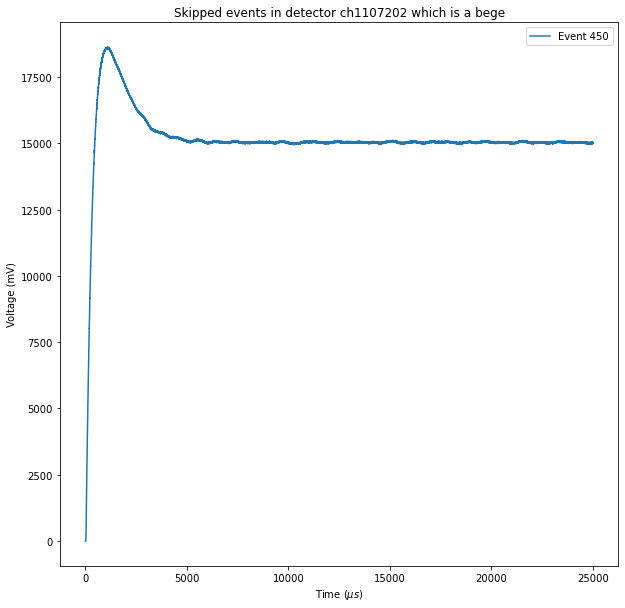

Skipped waveforms for detector ch1110402: [18, 771]
Percentage of discharges present: 0.14174344436569397%


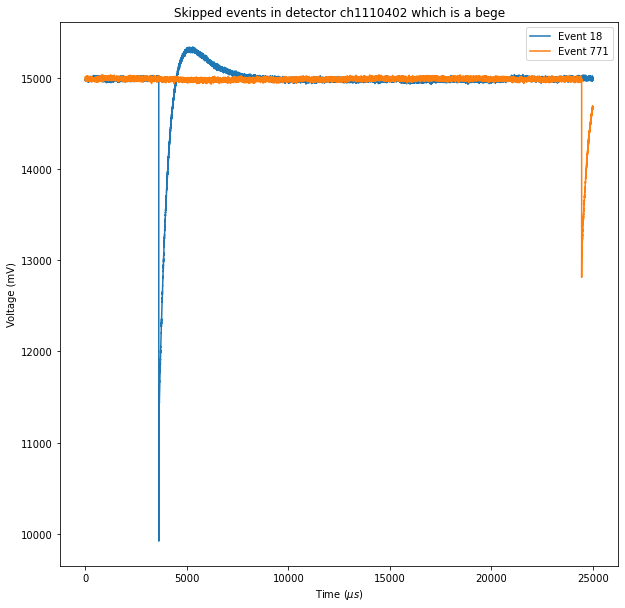

This detector ch1110403 doesn't have any discharges
This detector ch1112005 doesn't have any discharges
Skipped waveforms for detector ch1113600: [436, 634, 767, 891, 1297]
Percentage of discharges present: 0.3543586109142405%


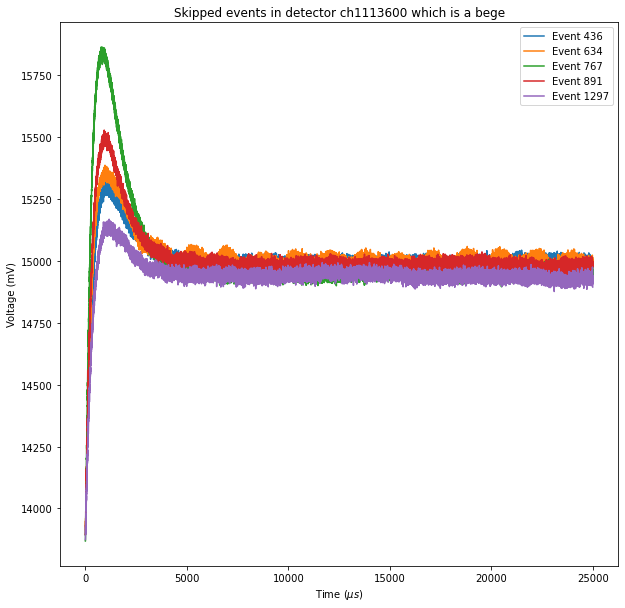

Skipped waveforms for detector ch1113601: [436, 634, 767, 1123, 1214, 1297]
Percentage of discharges present: 0.425230333097093%


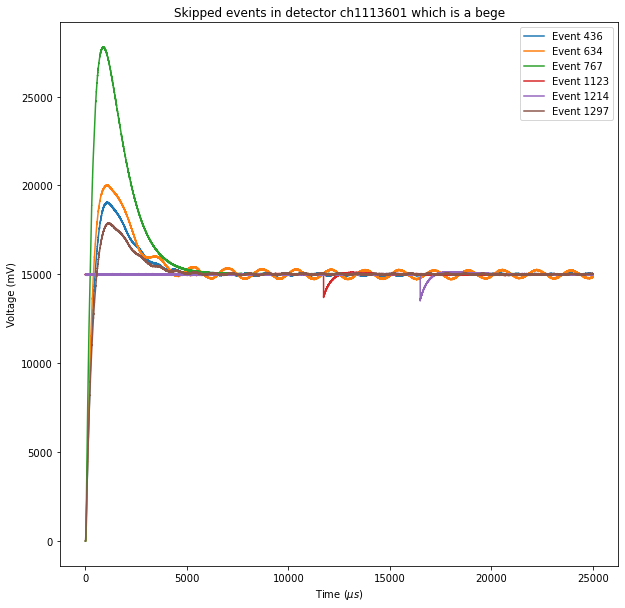

Skipped waveforms for detector ch1113602: [853, 1061, 1123, 1214]
Percentage of discharges present: 0.28348688873139904%


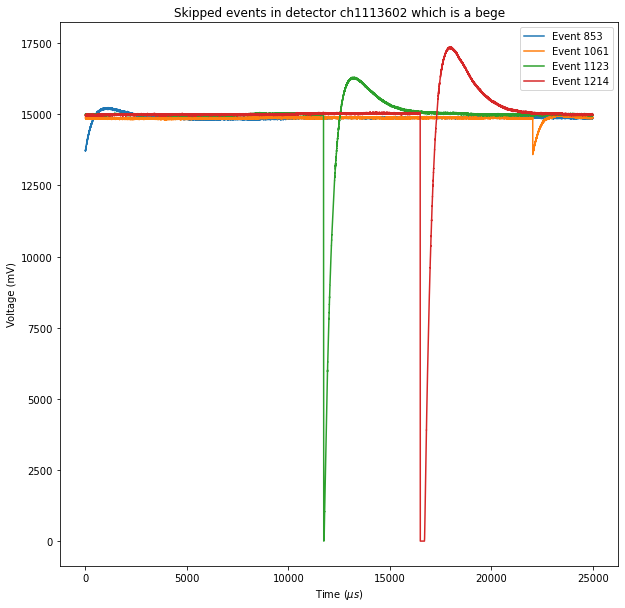

Skipped waveforms for detector ch1113603: [222, 853, 1061, 1116, 1310]
Percentage of discharges present: 0.3543586109142405%


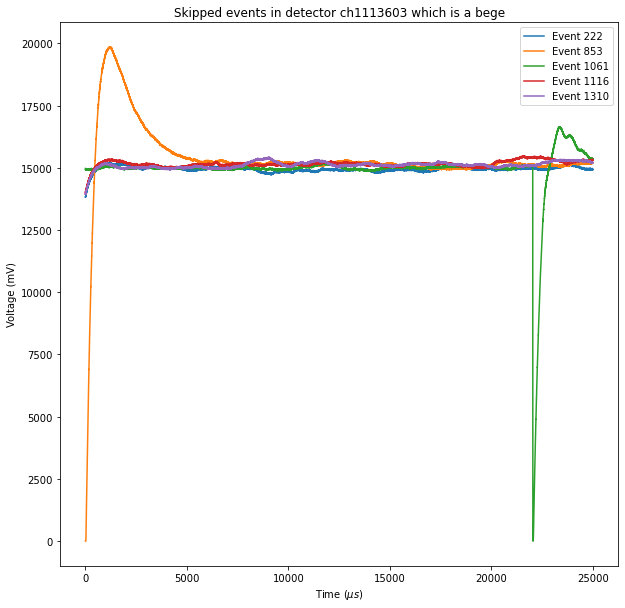

Skipped waveforms for detector ch1113604: [222, 326, 1116, 1310]
Percentage of discharges present: 0.28348688873139904%


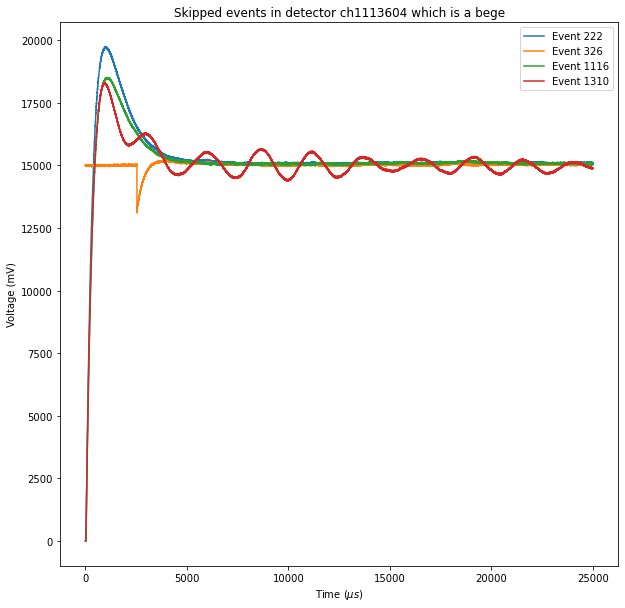

This detector ch1113605 doesn't have any discharges
Skipped waveforms for detector ch1120003: [20, 76, 492, 570, 751]
Percentage of discharges present: 0.3543586109142405%


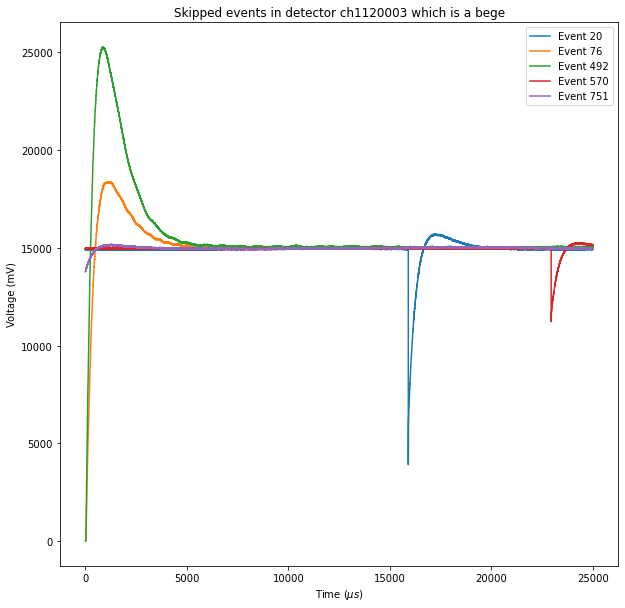

Skipped waveforms for detector ch1120004: [128, 317, 928, 948, 1325]
Percentage of discharges present: 0.3543586109142405%


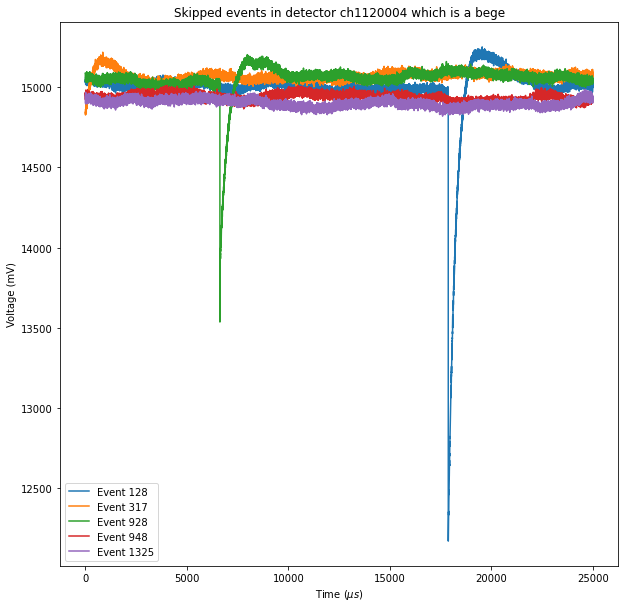

This detector ch1078405 doesn't have any discharges
Skipped waveforms for detector ch1080000: [584, 906, 1179, 1247]
Percentage of discharges present: 0.28348688873139904%


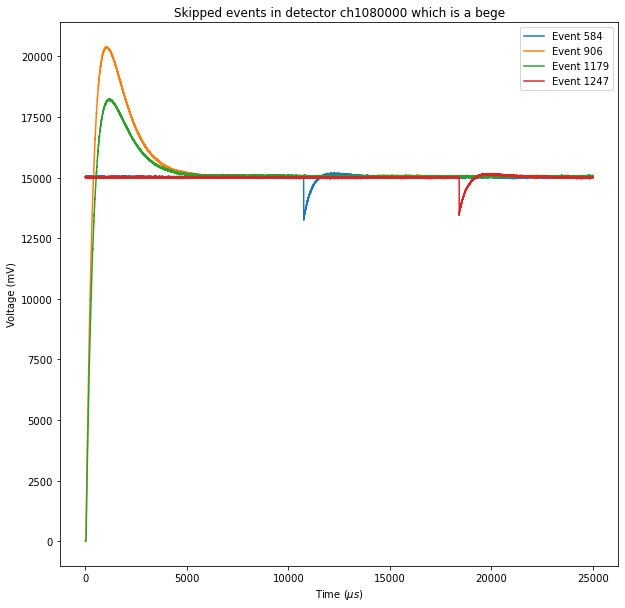

Skipped waveforms for detector ch1080001: [171, 174, 1232]
Percentage of discharges present: 0.2126151665485465%


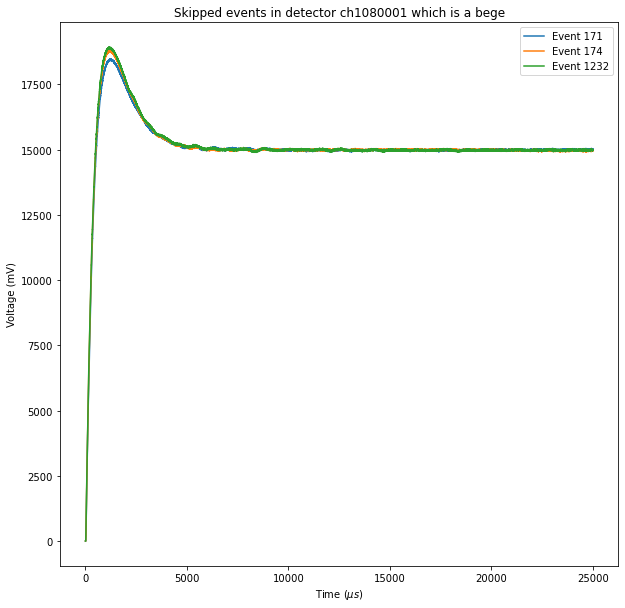

This detector ch1080002 doesn't have any discharges
This detector ch1083200 doesn't have any discharges
Skipped waveforms for detector ch1083201: [528, 750, 771, 772, 781, 789, 1136, 1180, 1197, 1360]
Percentage of discharges present: 0.7087172218284921%


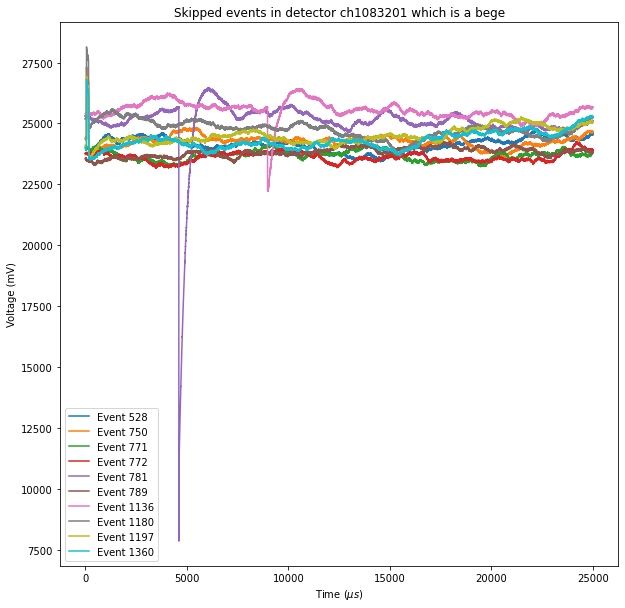

Skipped waveforms for detector ch1083202: [61, 108, 116, 126, 170, 494, 735, 898, 963]
Percentage of discharges present: 0.6378454996456395%


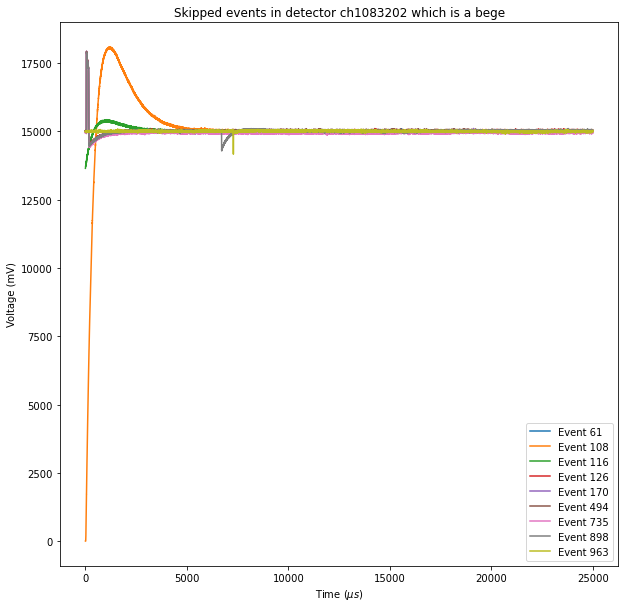

Skipped waveforms for detector ch1083203: [115, 116, 351, 479, 515, 927, 963, 1030, 1049, 1118, 1120, 1152, 1170, 1180, 1362]
Percentage of discharges present: 1.0630758327427325%


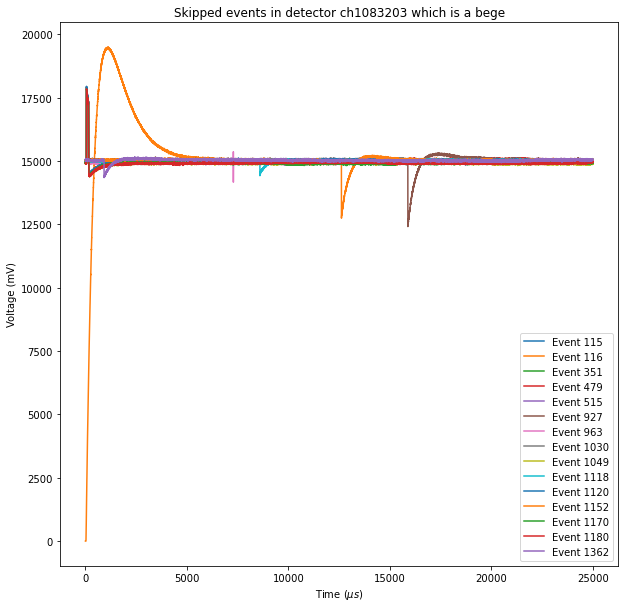

Skipped waveforms for detector ch1083204: [105, 963]
Percentage of discharges present: 0.14174344436569397%


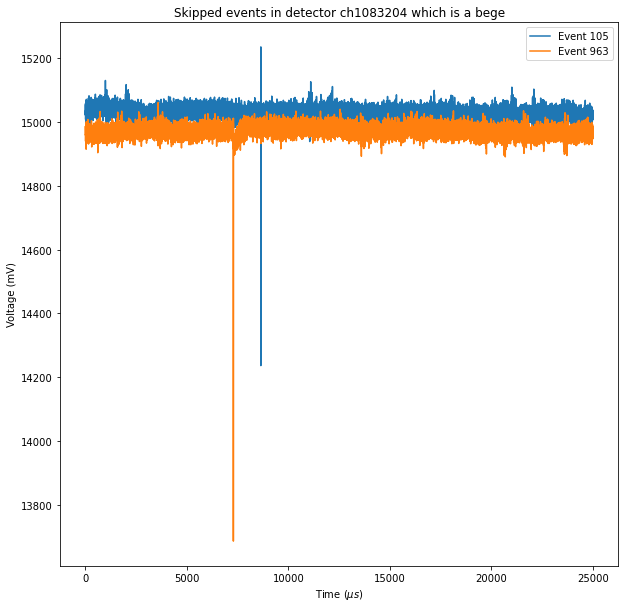

Skipped waveforms for detector ch1083205: [105, 935, 963, 982]
Percentage of discharges present: 0.28348688873139904%


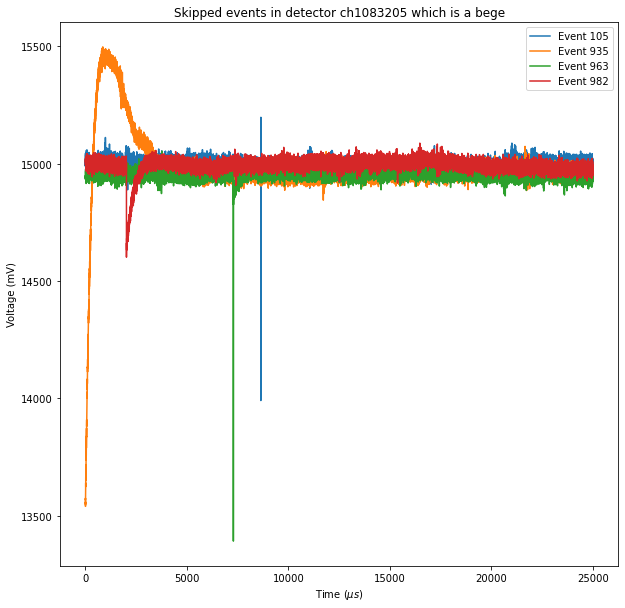

Skipped waveforms for detector ch1084800: [105, 365, 935]
Percentage of discharges present: 0.2126151665485465%


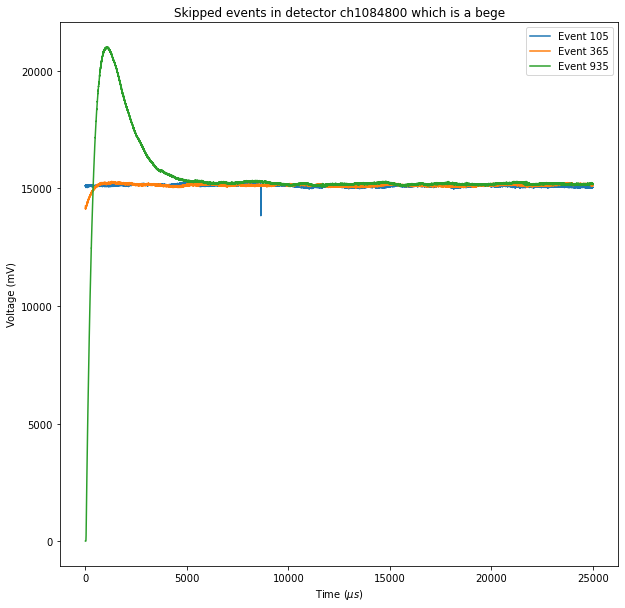

Skipped waveforms for detector ch1084801: [105, 365, 963]
Percentage of discharges present: 0.2126151665485465%


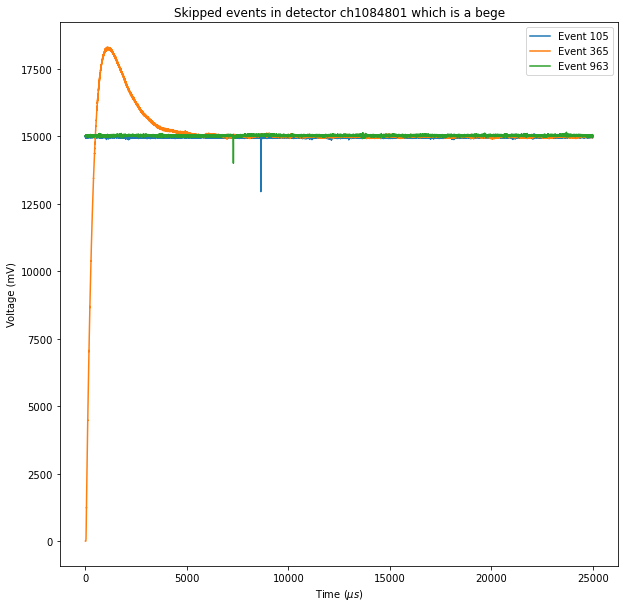

Skipped waveforms for detector ch1084802: [105, 963]
Percentage of discharges present: 0.14174344436569397%


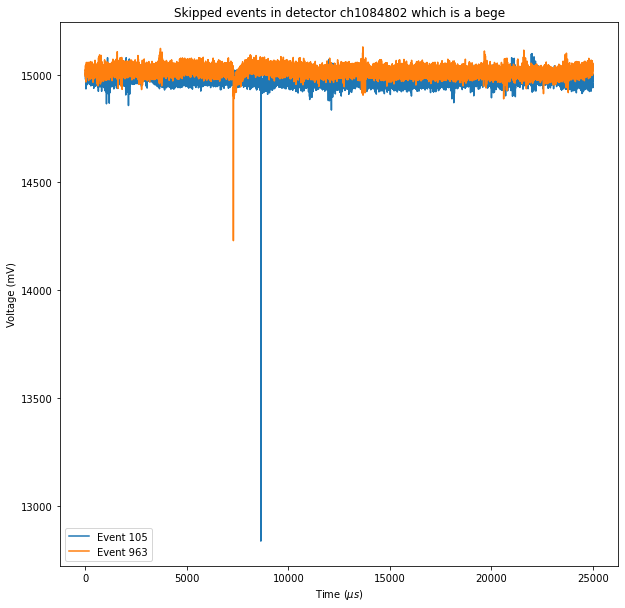

Skipped waveforms for detector ch1086403: [185, 465, 999]
Percentage of discharges present: 0.2126151665485465%


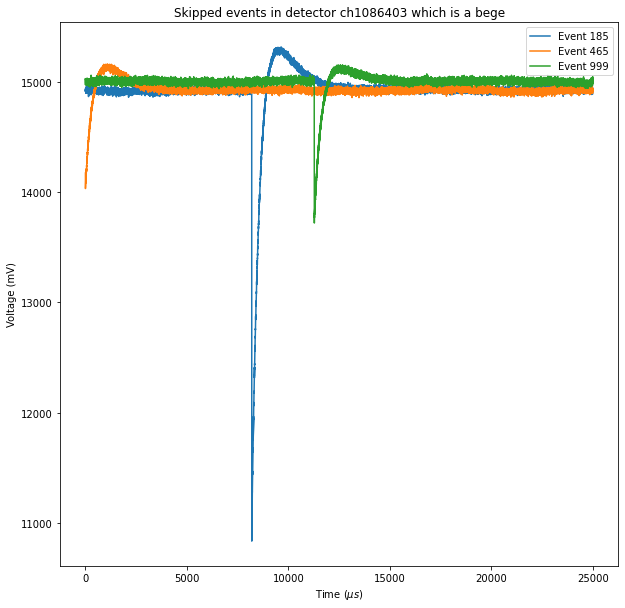

Skipped waveforms for detector ch1086404: [465, 1361]
Percentage of discharges present: 0.14174344436569397%


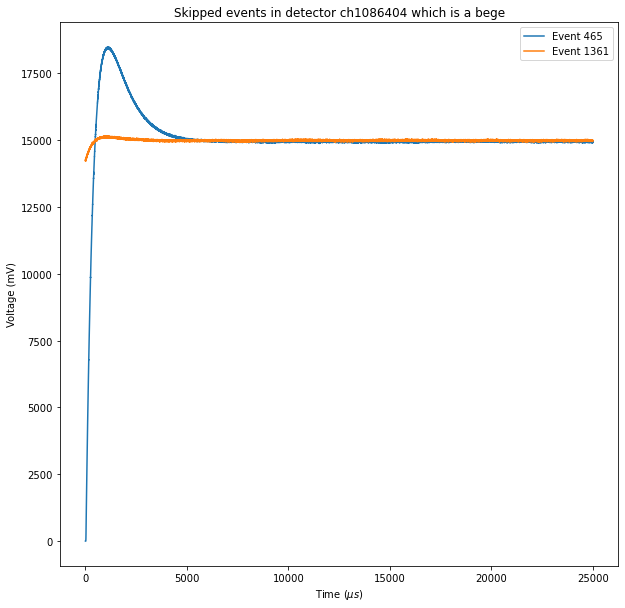

Skipped waveforms for detector ch1086405: [1034, 1361]
Percentage of discharges present: 0.14174344436569397%


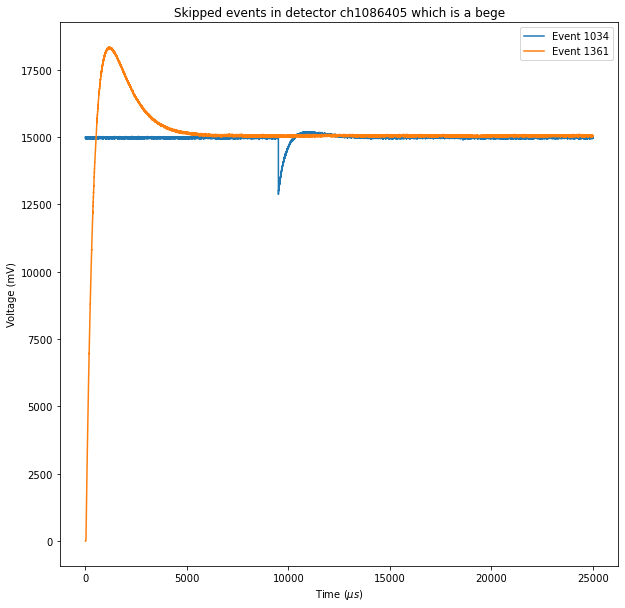

In [16]:
percent_discharge = {}
skipped_waveforms = {}
maxima_skipped = []
skipped_index1 = []
detectors_with_discharges=[]
for j in detectors_bege:
    wfs_all = wfs_all_dict[j]
    index_skip1 = index_skipm[j]

    if len(index_skip1) < 20:
        skipped_waveforms[j] = index_skip1  # Store all skipped indices for the detector
        print(f"Skipped waveforms for detector {j}: {index_skip1}")

        for i in index_skip1:
            maxima_skipped.append(np.max(wfs_all))
            skipped_index1.append(i)
            wf0 = wfs_all[i, :]
            ts = np.arange(0, wf0.shape[0], 1) * 0.8  # micro s 
            x = j[2:]
            test = cmap[x]['type']
            detectors_with_discharges.append(j)

            plt.plot(ts[:], wf0[:], label=f'Event {i}')  # plot each skipped waveform

        # Customize plot
        plt.xlabel('Time ($\mu s$)')
        plt.ylabel('Voltage (mV)')
        plt.title(f'Skipped events in detector {j} which is a {test}')
        plt.legend()

        diff = len(minimum_dict[j]) - len(index_skip1)
        percentage = (1 - (diff / len(minimum_dict[j]))) * 100
        percent_discharge[j] = percentage
        print(f"Percentage of discharges present: {percentage}%")
        plt.show()
    else:
        print(f"This detector {j} doesn't have any discharges")

Another selection criteria which states that if the size of the skipped indices is larger than 20, after the 2 cuts, this suggests we have no discharges.

recovery rate 4996.8s
DISCHARGE
Maximum difference: 461.6, 4996.8
Next maximum difference: 5306.400000000001, 5798.400000000001


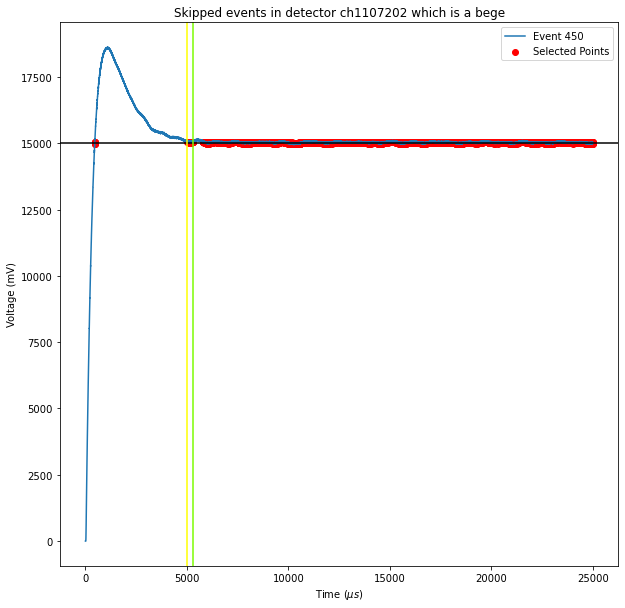

recovery rate 3614.3999999999996s
MICRODISCHARGE
Maximum difference: 4526.400000000001, 7228.0
Next Maximum difference: 3613.6000000000004, 4442.400000000001


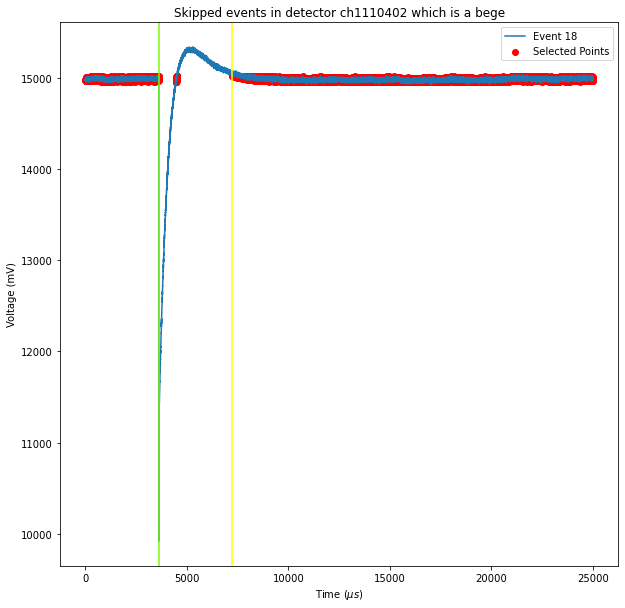

recovery rate 0.0s
MICRODISCHARGE
Maximum difference: 24956.0, 24957.600000000002
Next Maximum difference: 24957.600000000002, 24959.2


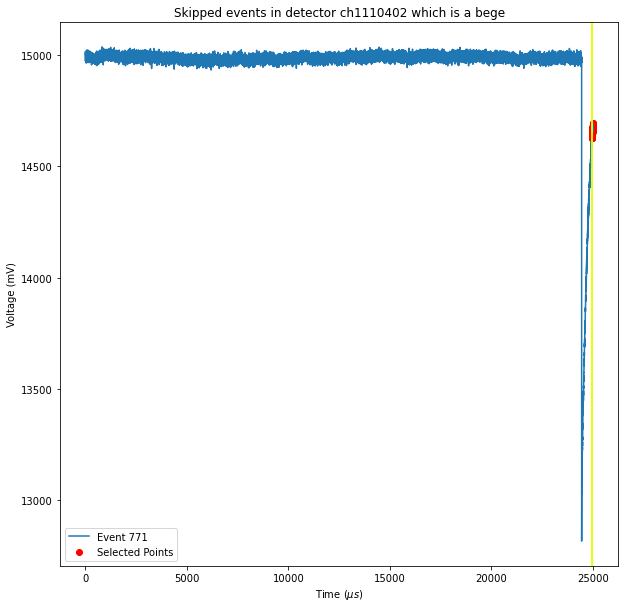

recovery rate 3212.0s
MICRODISCHARGE
Maximum difference: 465.6, 3212.0
Next Maximum difference: 3458.4, 3641.6000000000004


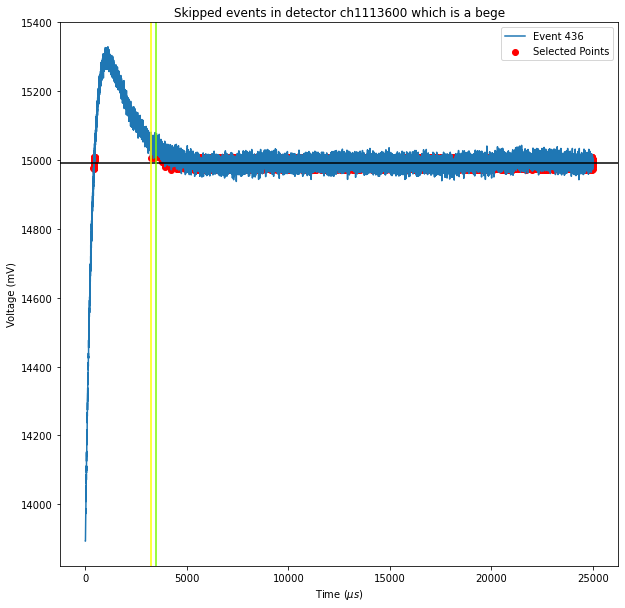

recovery rate 3184.8s
MICRODISCHARGE
Maximum difference: 391.20000000000005, 3184.8
Next Maximum difference: 3184.8, 3808.8


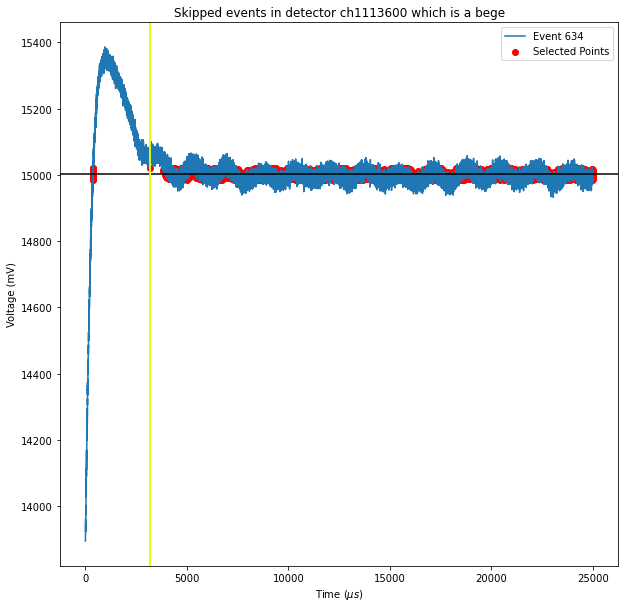

recovery rate 3439.2000000000003s
MICRODISCHARGE
Maximum difference: 215.20000000000002, 3439.2000000000003
Next Maximum difference: 3458.4, 3496.0


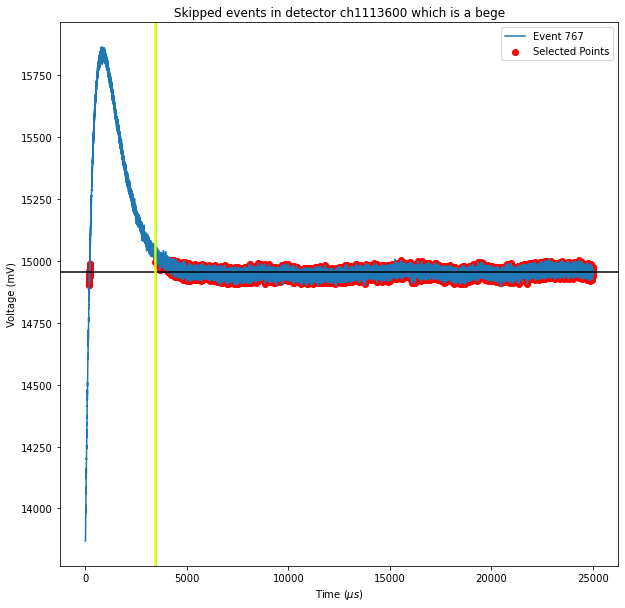

recovery rate 3245.6000000000004s
MICRODISCHARGE
Maximum difference: 332.0, 3245.6000000000004
Next Maximum difference: 3245.6000000000004, 3317.6000000000004


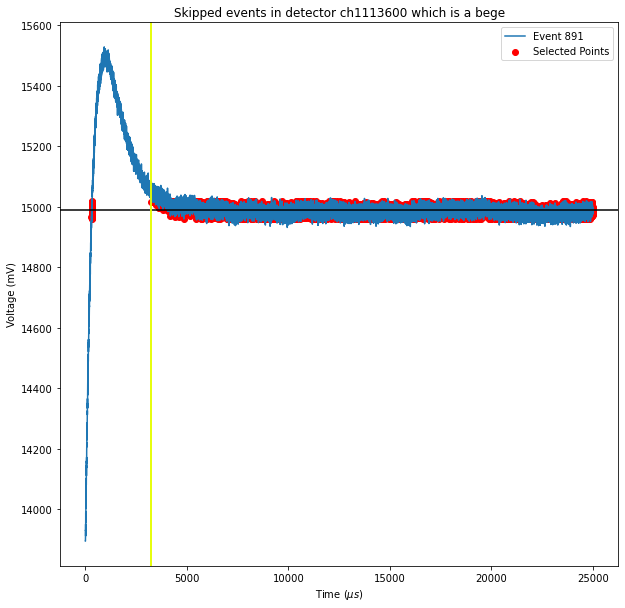

recovery rate 2916.8s
MICRODISCHARGE
Maximum difference: 557.6, 2916.8
Next Maximum difference: 2943.2000000000003, 3012.8


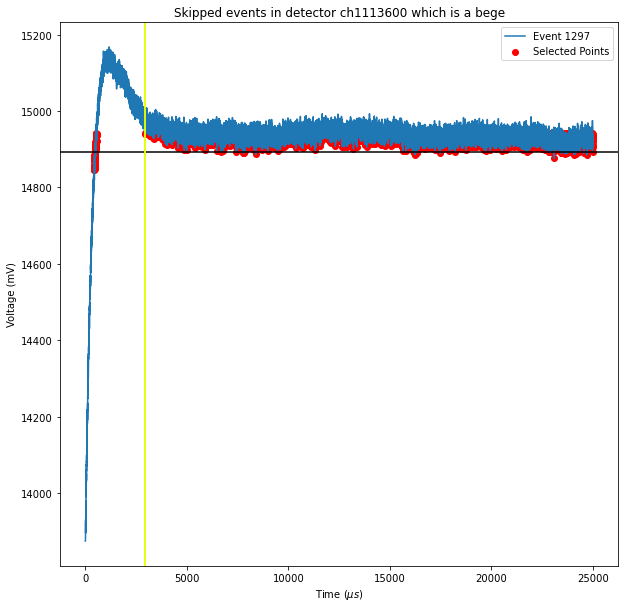

recovery rate 4839.2s
DISCHARGE
Maximum difference: 477.6, 4839.2
Next maximum difference: 5103.200000000001, 5494.400000000001


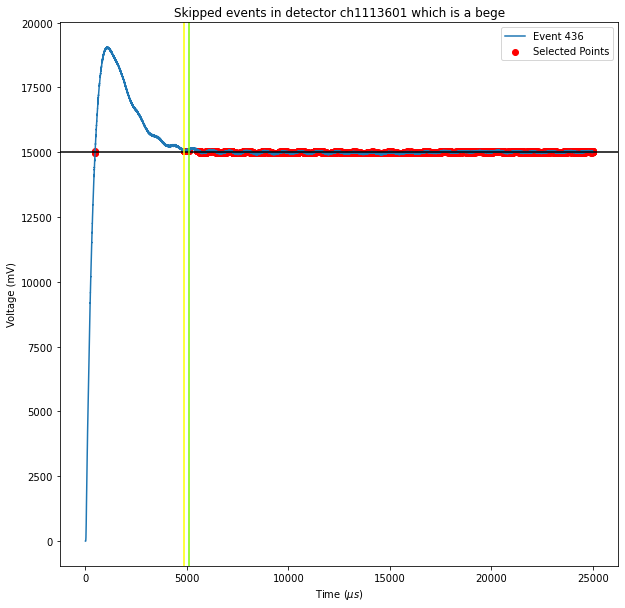

recovery rate 4421.6s
DISCHARGE
Maximum difference: 390.40000000000003, 4421.6
Next maximum difference: 4631.2, 5892.8


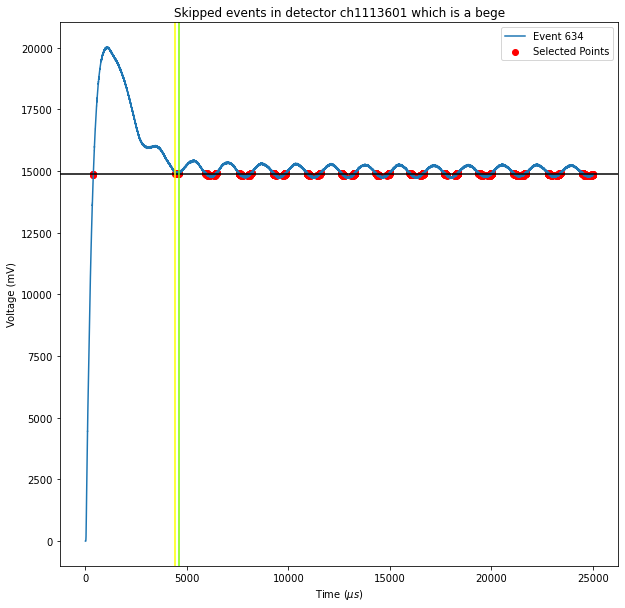

recovery rate 6455.200000000001s
DISCHARGE
Maximum difference: 227.20000000000002, 6455.200000000001
Next maximum difference: 6476.8, 6555.200000000001


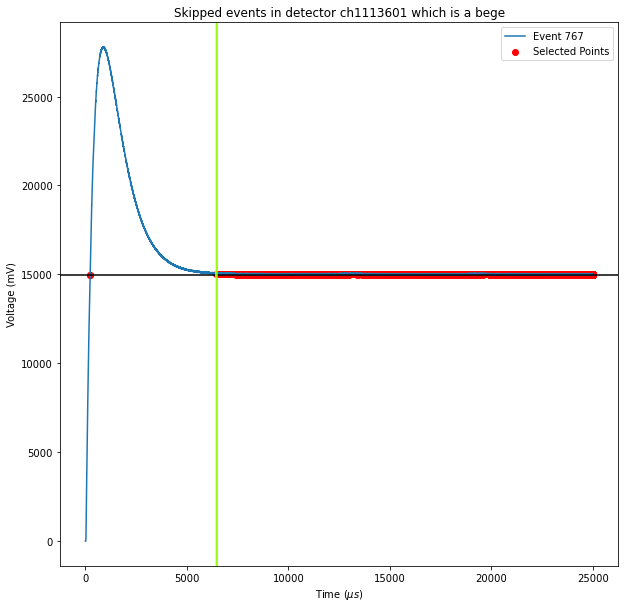

recovery rate 2537.6000000000004s
MICRODISCHARGE
Maximum difference: 12631.2, 14270.400000000001
Next Maximum difference: 11732.800000000001, 12433.6


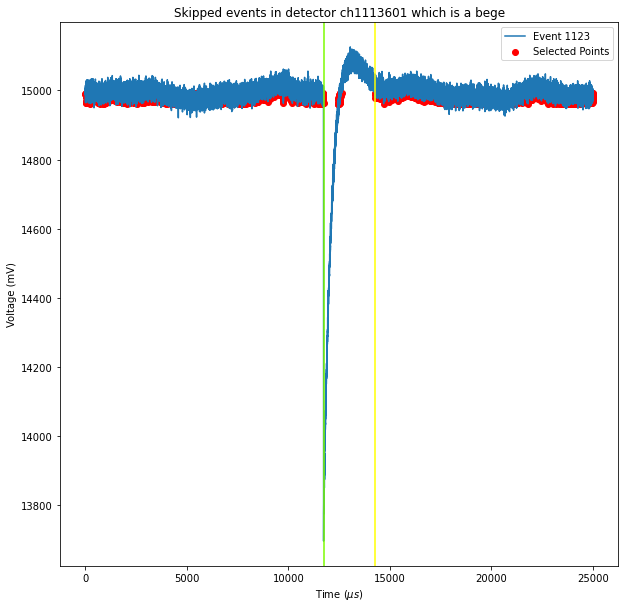

recovery rate 2774.4000000000015s
MICRODISCHARGE
Maximum difference: 17340.0, 19262.4
Next Maximum difference: 16488.0, 17170.4


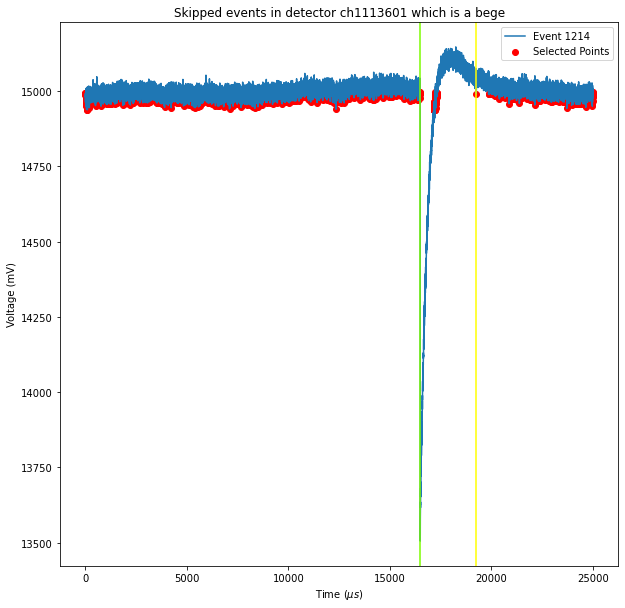

recovery rate 4782.400000000001s
DISCHARGE
Maximum difference: 567.2, 4782.400000000001
Next maximum difference: 7697.6, 7776.0


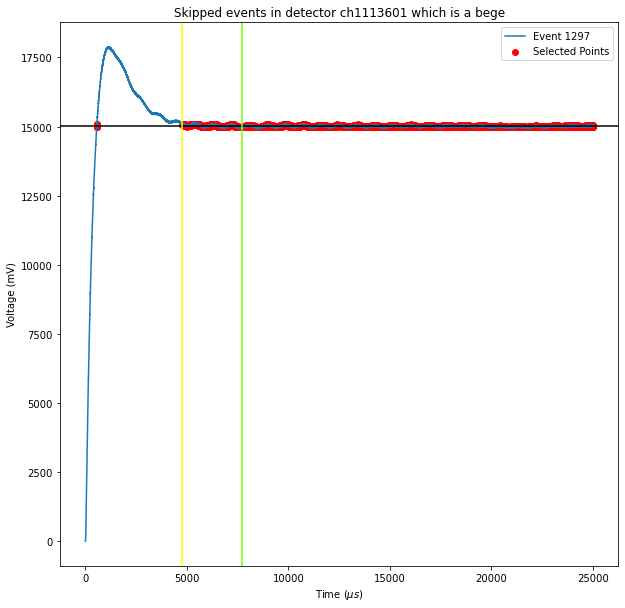

recovery rate 3324.8s
MICRODISCHARGE
Maximum difference: 440.8, 3324.8
Next Maximum difference: 5687.200000000001, 5727.200000000001


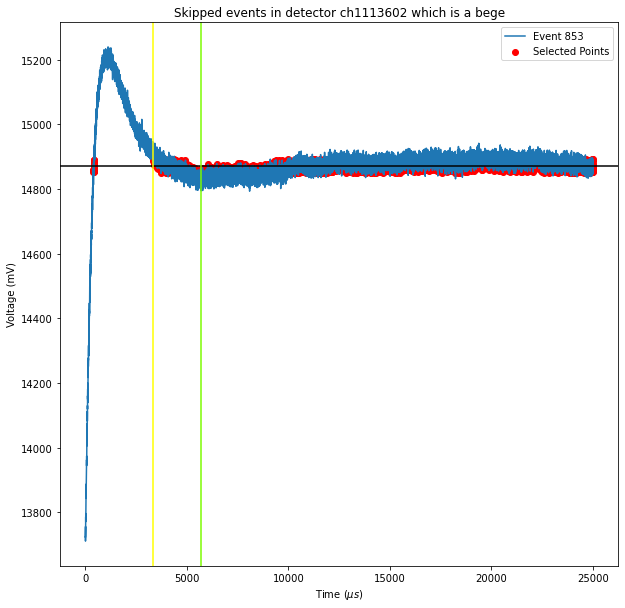

recovery rate 2072.7999999999993s
MICRODISCHARGE
Maximum difference: 23021.600000000002, 24115.2
Next Maximum difference: 22042.4, 22714.4


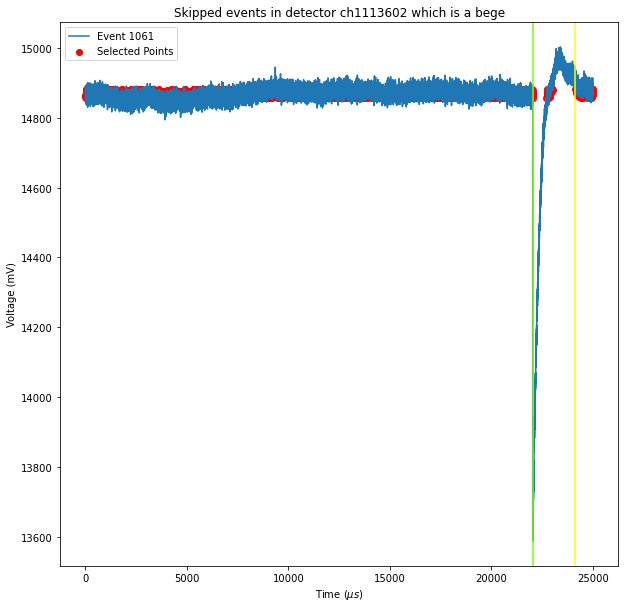

recovery rate 5127.999999999998s
DISCHARGE
Maximum difference: 12559.2, 16860.8
Next maximum difference: 11732.800000000001, 12536.800000000001


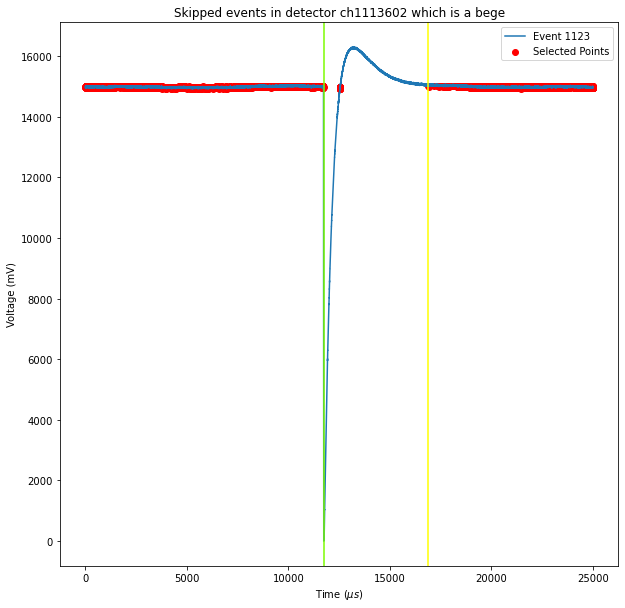

recovery rate 5308.0s
DISCHARGE
Maximum difference: 17319.2, 21802.4
Next maximum difference: 16494.4, 17309.600000000002


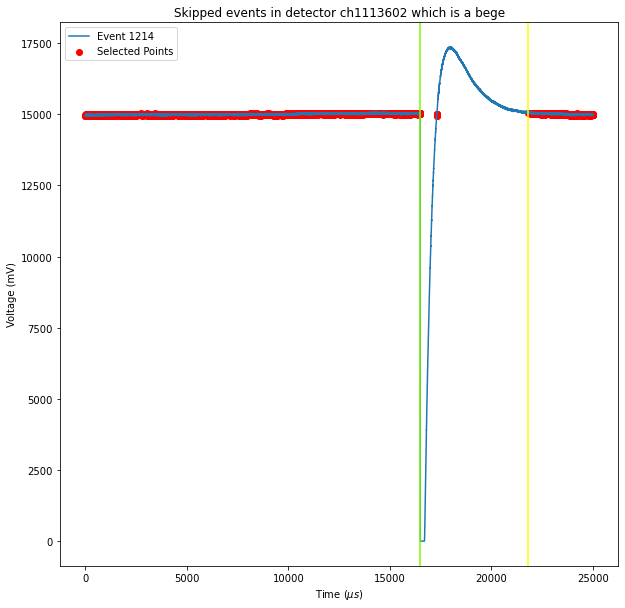

recovery rate 2660.8s
MICRODISCHARGE
Maximum difference: 585.6, 2660.8
Next Maximum difference: 6089.6, 7597.6


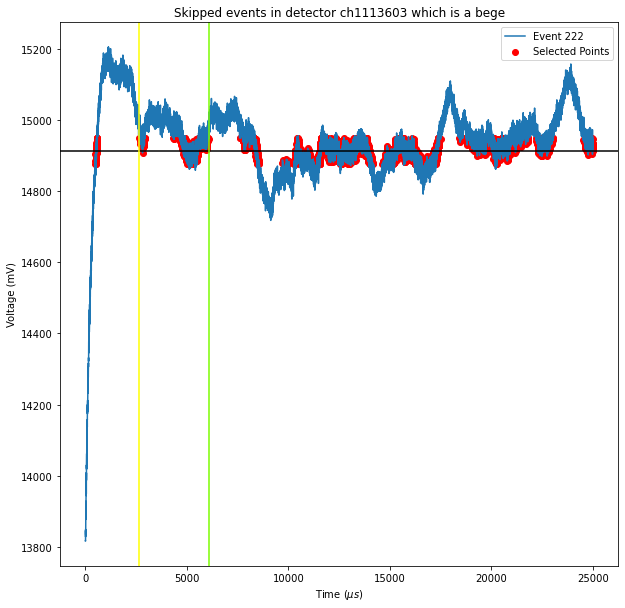

recovery rate 5491.200000000001s
DISCHARGE
Maximum difference: 473.6, 5491.200000000001
Next maximum difference: 15272.800000000001, 20059.2


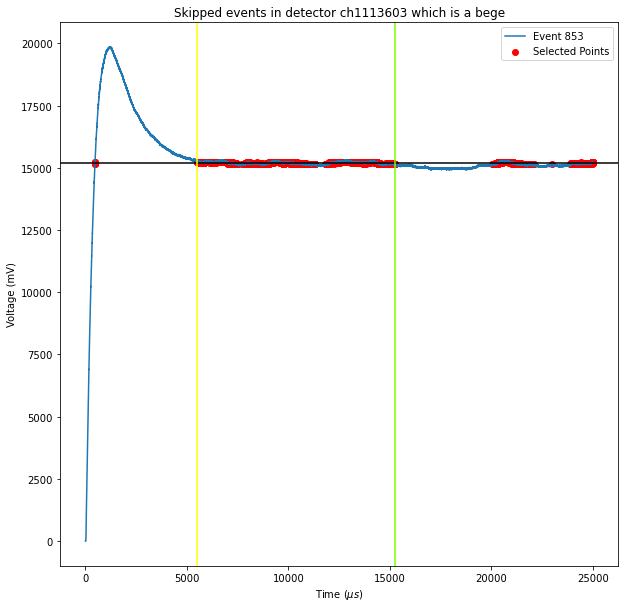

recovery rate 0.0s
DISCHARGE
Maximum difference: 22967.2, 24798.4
Next maximum difference: 24798.4, 24815.2


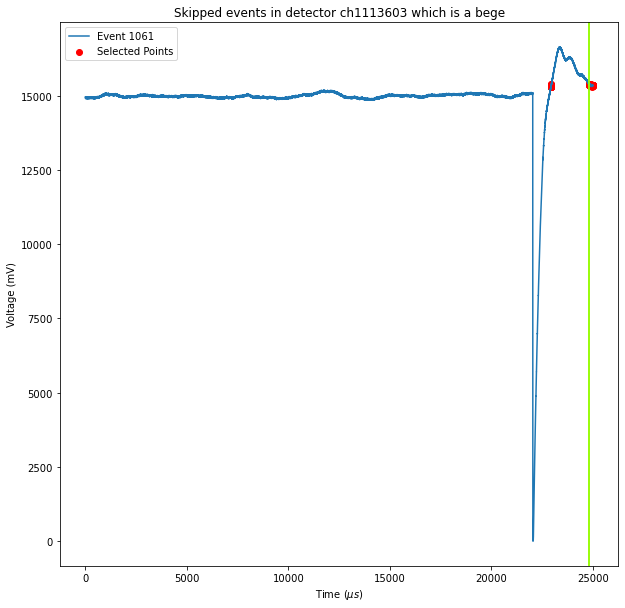

recovery rate 20262.4s
MICRODISCHARGE
Maximum difference: 1811.2, 20262.4
Next Maximum difference: 23409.600000000002, 24295.2


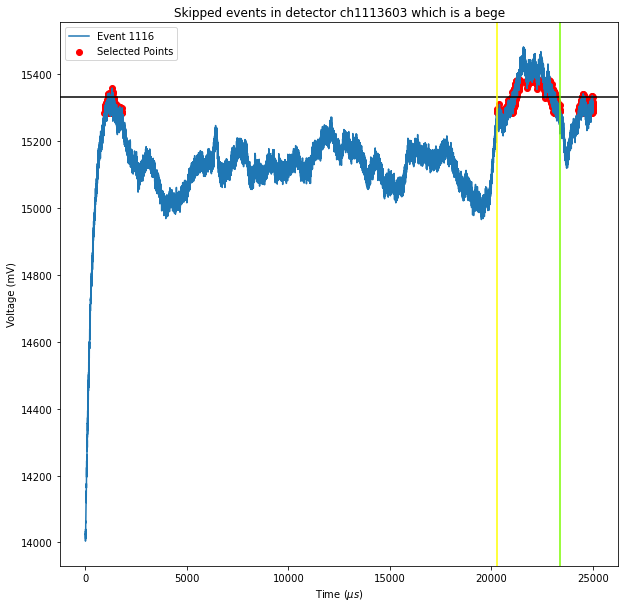

recovery rate 7856.8s
MICRODISCHARGE
Maximum difference: 1227.2, 7856.8
Next Maximum difference: 19468.8, 22373.600000000002


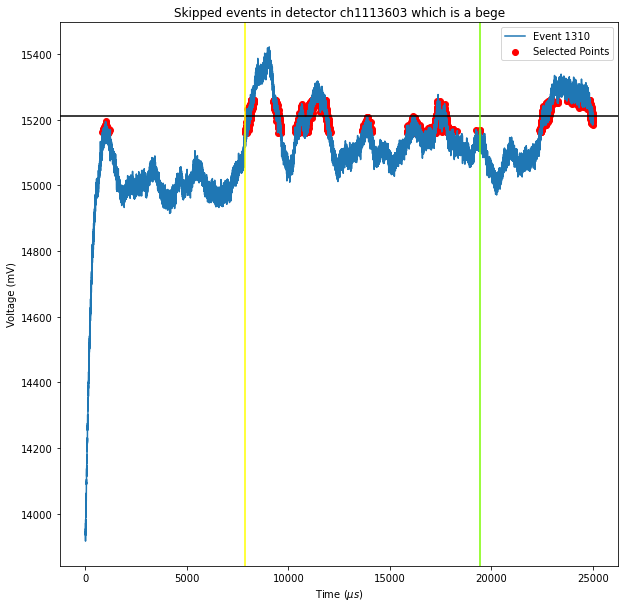

recovery rate 5296.8s
DISCHARGE
Maximum difference: 400.0, 5296.8
Next maximum difference: 5448.8, 6225.6


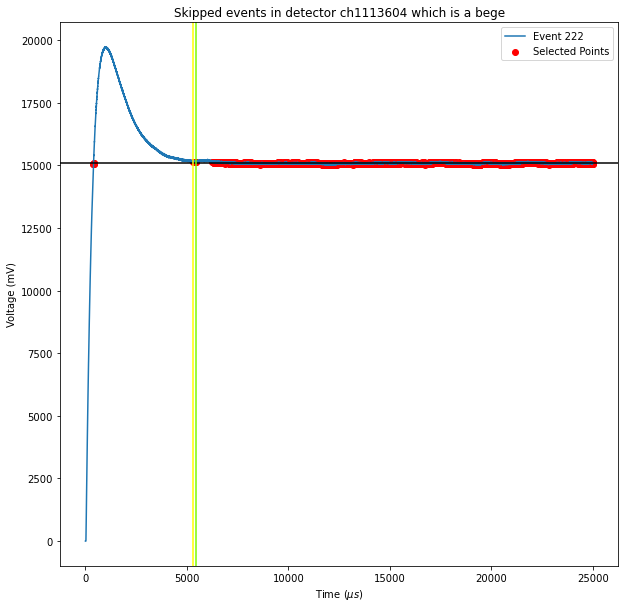

recovery rate 2123.2s
MICRODISCHARGE
Maximum difference: 3488.0, 4659.2
Next Maximum difference: 2536.0, 3245.6000000000004


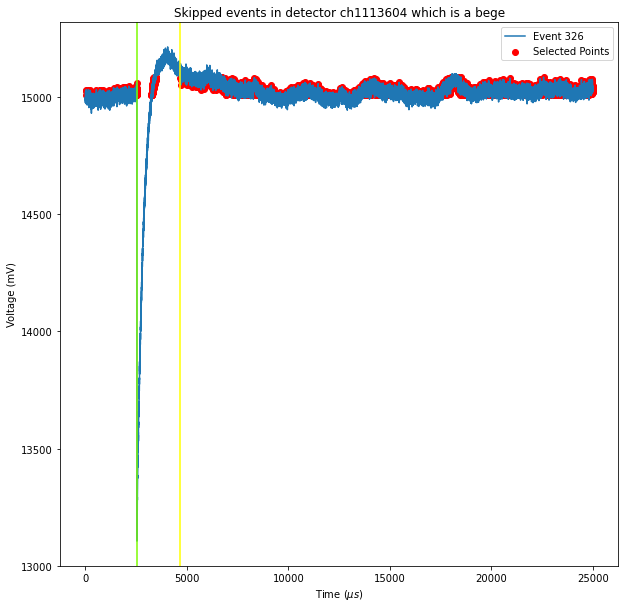

recovery rate 5168.0s
DISCHARGE
Maximum difference: 471.20000000000005, 5168.0
Next maximum difference: 18298.4, 19329.600000000002


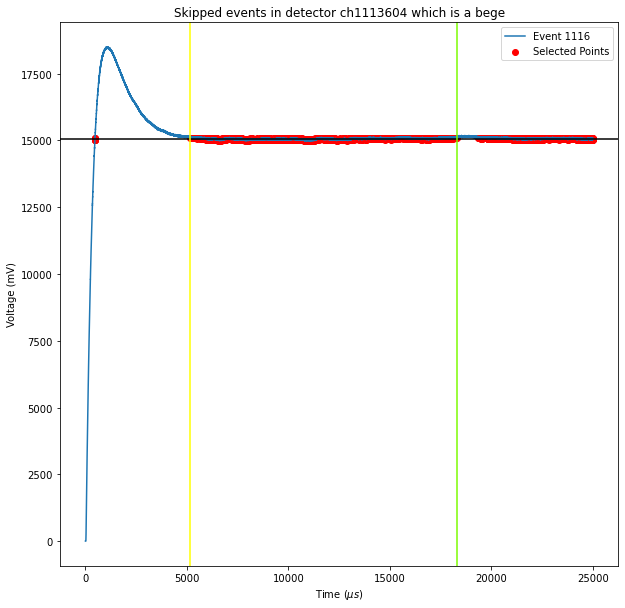

recovery rate 4048.8s
DISCHARGE
Maximum difference: 454.40000000000003, 4048.8
Next maximum difference: 5148.8, 6767.200000000001


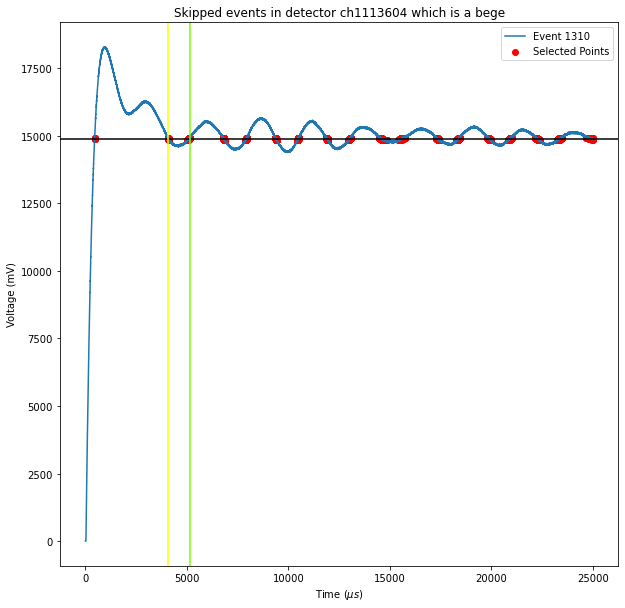

recovery rate 3599.2000000000007s
MICRODISCHARGE
Maximum difference: 16685.600000000002, 19509.600000000002
Next Maximum difference: 15910.400000000001, 16648.0


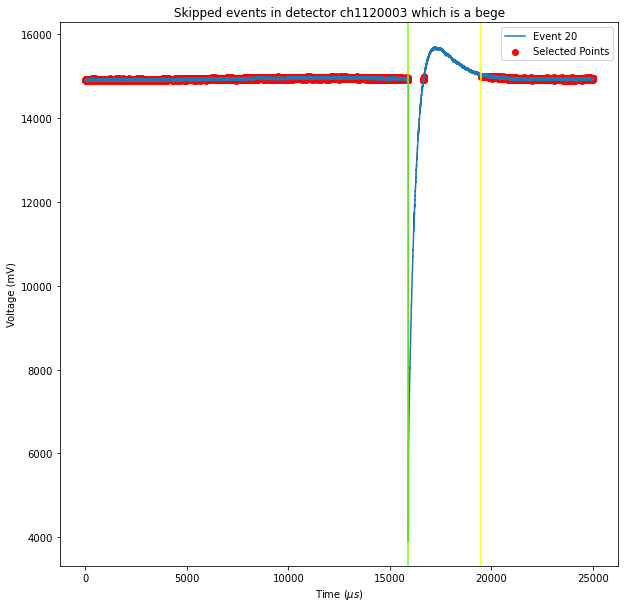

recovery rate 4780.8s
DISCHARGE
Maximum difference: 492.8, 4780.8
Next maximum difference: 4905.6, 5130.400000000001


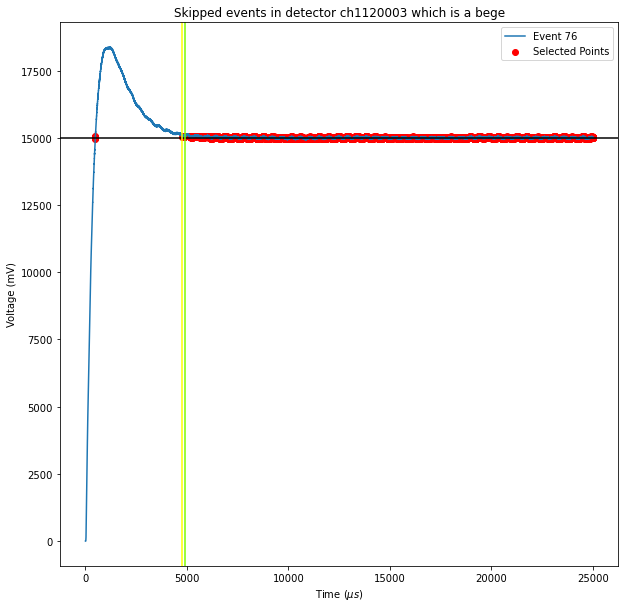

recovery rate 6174.400000000001s
DISCHARGE
Maximum difference: 254.4, 6174.400000000001
Next maximum difference: 6764.0, 6860.0


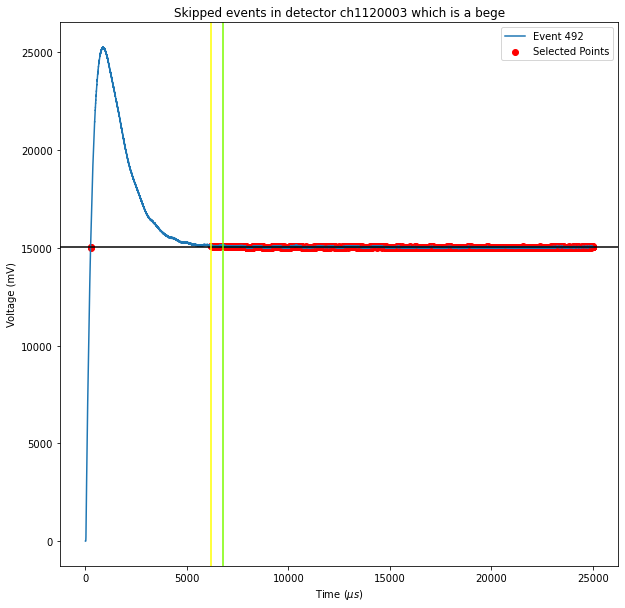

recovery rate -152.79999999999927s
MICRODISCHARGE
Maximum difference: 24231.2, 24288.800000000003
Next Maximum difference: 24441.600000000002, 24492.800000000003


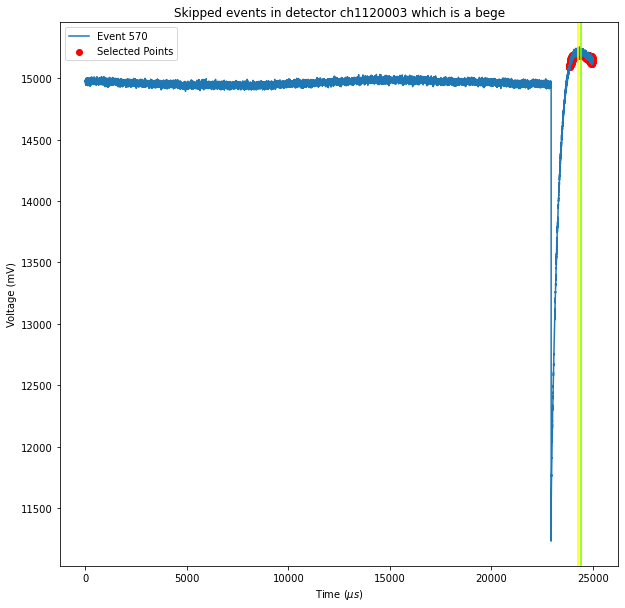

recovery rate 2883.2000000000003s
MICRODISCHARGE
Maximum difference: 652.0, 2883.2000000000003
Next Maximum difference: 2883.2000000000003, 3024.8


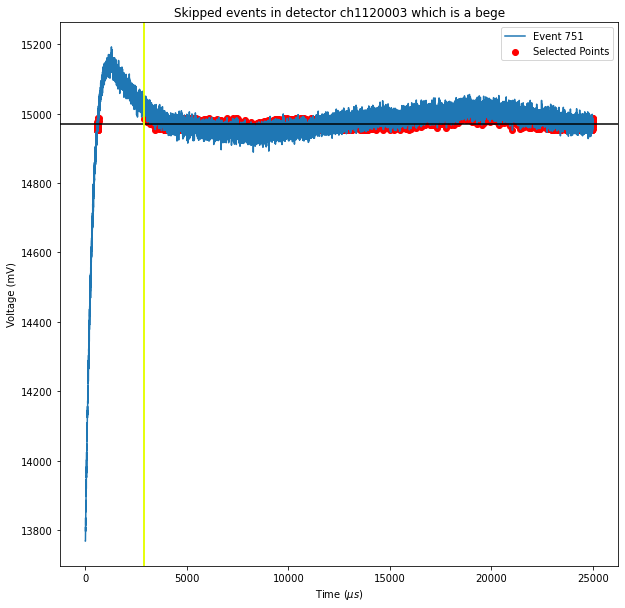

recovery rate 3248.800000000003s
MICRODISCHARGE
Maximum difference: 18838.4, 21120.800000000003
Next Maximum difference: 17872.0, 18713.600000000002


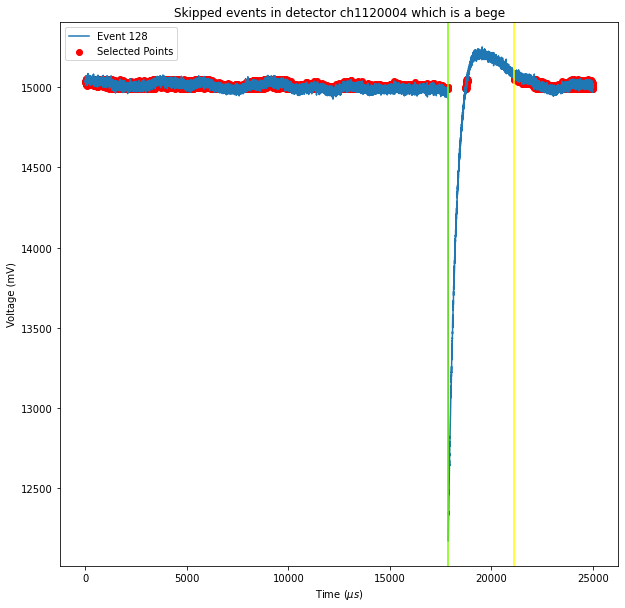

recovery rate -1888.8s
MICRODISCHARGE
Maximum difference: 405.6, 1735.2
Next Maximum difference: 3624.0, 3909.6000000000004


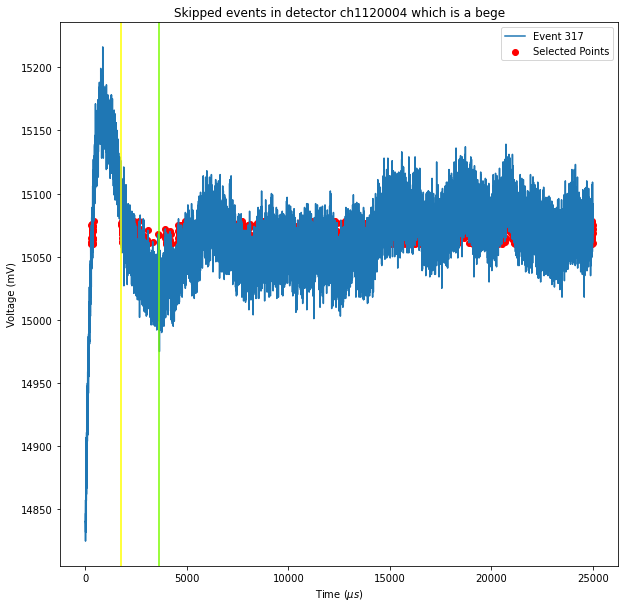

recovery rate -7588.799999999999s
MICRODISCHARGE
Maximum difference: 7588.8, 9760.0
Next Maximum difference: 17348.8, 18864.8


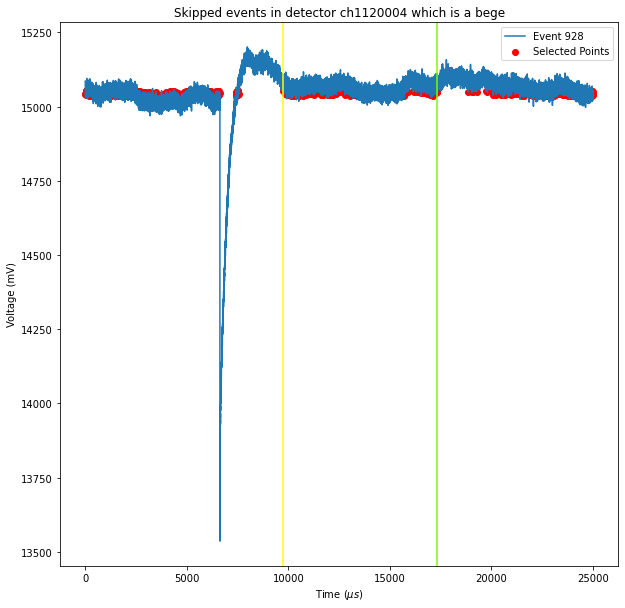

recovery rate -6204.000000000001s
MICRODISCHARGE
Maximum difference: 3764.8, 4119.2
Next Maximum difference: 10323.2, 10548.0


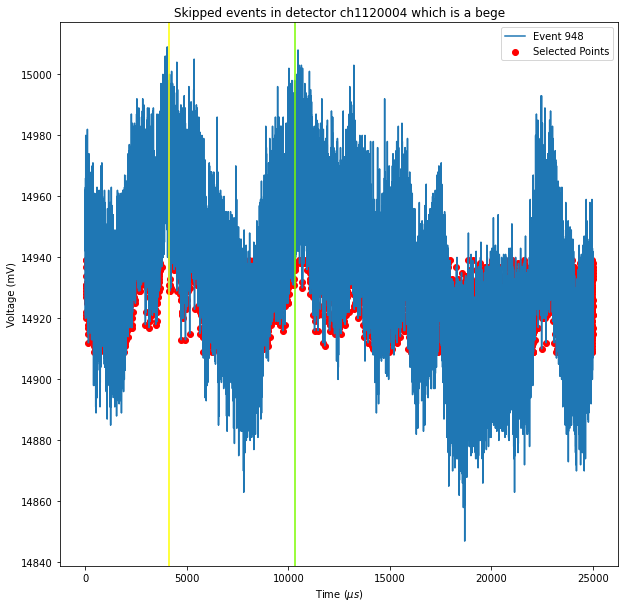

recovery rate 6783.200000000001s
MICRODISCHARGE
Maximum difference: 17613.600000000002, 17961.600000000002
Next Maximum difference: 11178.400000000001, 11403.2


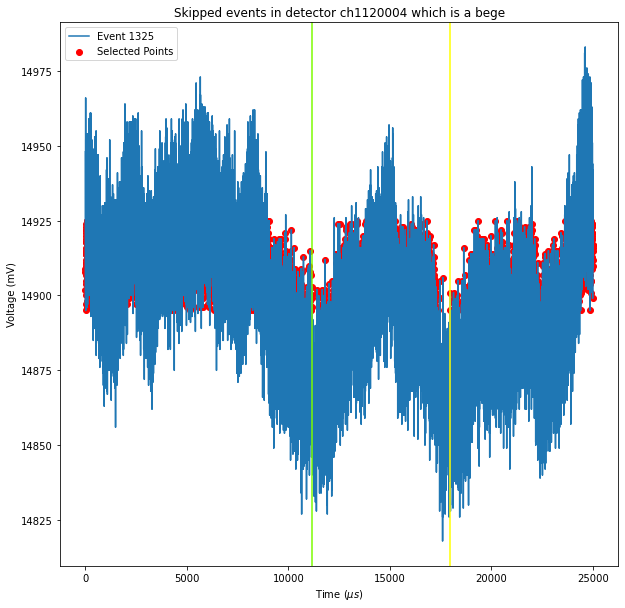

recovery rate 2504.0s
MICRODISCHARGE
Maximum difference: 11708.800000000001, 13256.0
Next Maximum difference: 10752.0, 11516.0


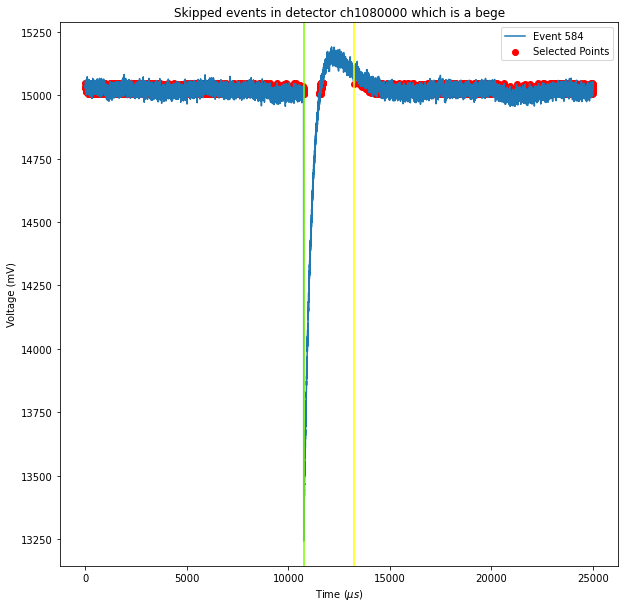

recovery rate 5357.6s
DISCHARGE
Maximum difference: 400.8, 5357.6
Next maximum difference: 5364.8, 5386.400000000001


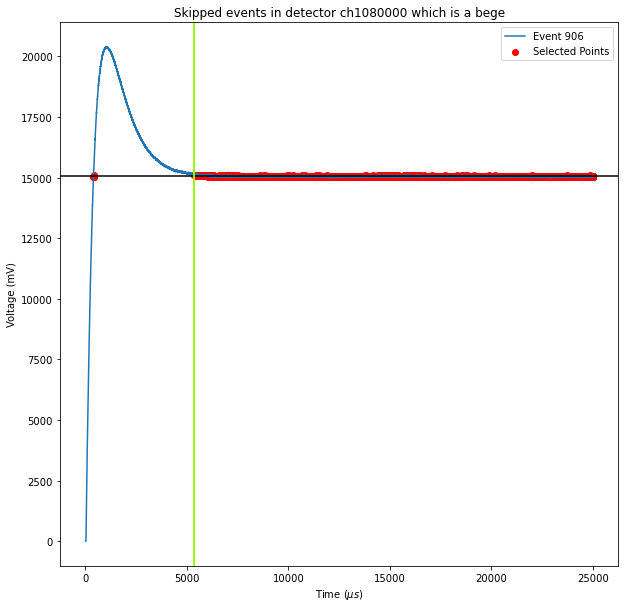

recovery rate 5039.200000000001s
DISCHARGE
Maximum difference: 534.4, 5039.200000000001
Next maximum difference: 5172.0, 5265.6


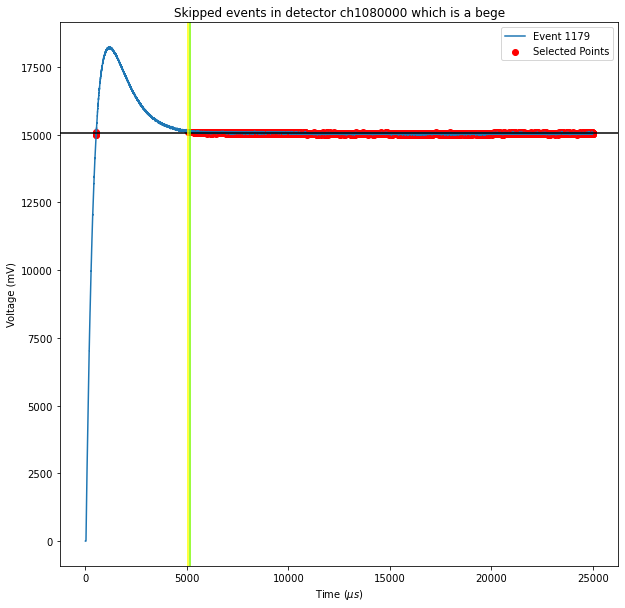

recovery rate 3216.7999999999993s
MICRODISCHARGE
Maximum difference: 19282.4, 21635.2
Next Maximum difference: 18418.4, 19168.8


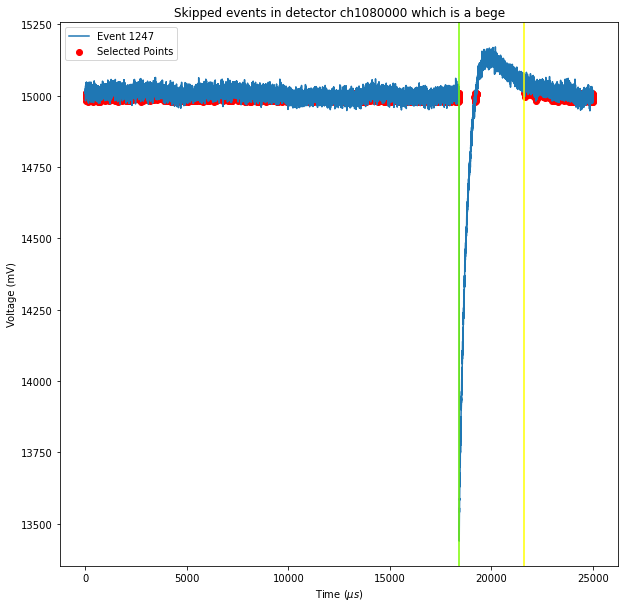

recovery rate 4785.6s
DISCHARGE
Maximum difference: 542.4, 4785.6
Next maximum difference: 5130.400000000001, 5552.0


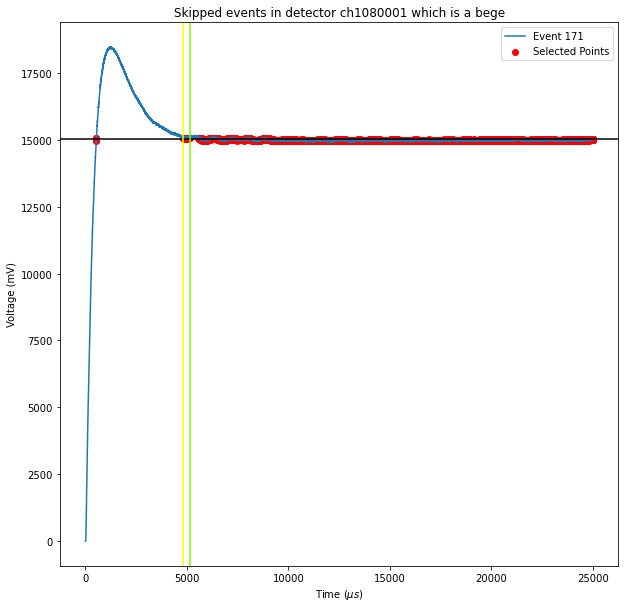

recovery rate 5832.0s
DISCHARGE
Maximum difference: 508.8, 5832.0
Next maximum difference: 7692.8, 7822.400000000001


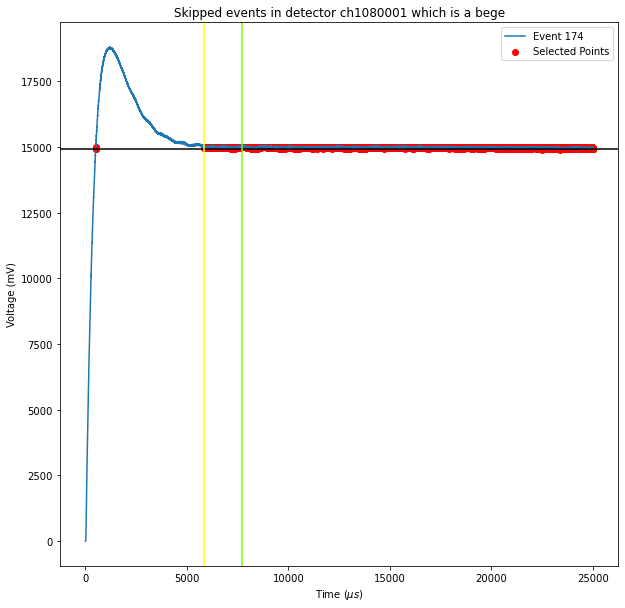

recovery rate 5743.200000000001s
DISCHARGE
Maximum difference: 500.8, 5743.200000000001
Next maximum difference: 6314.400000000001, 6392.0


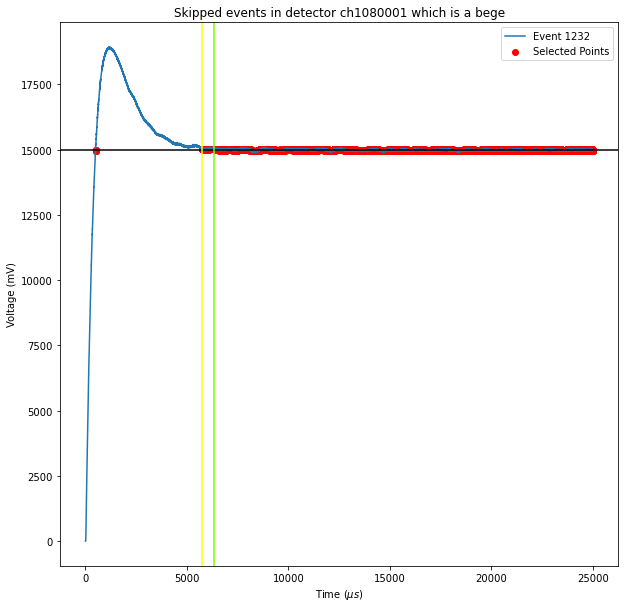

recovery rate 20412.800000000003s
MICRODISCHARGE
Maximum difference: 4004.0, 21638.4
Next Maximum difference: 1225.6000000000001, 2276.8


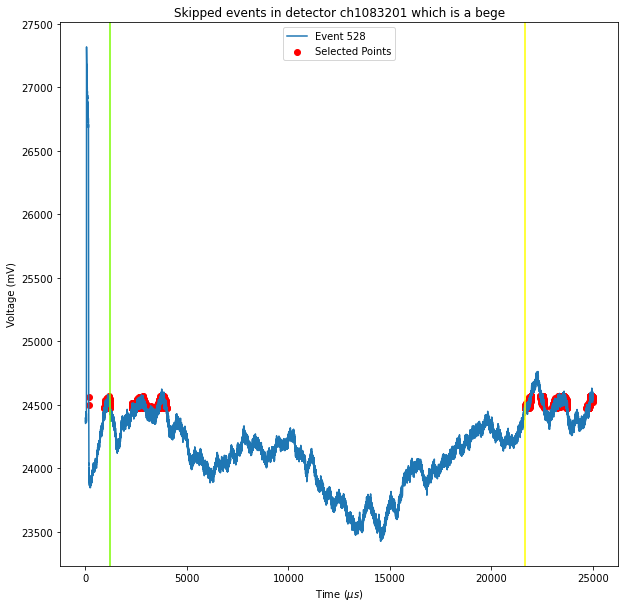

recovery rate 24423.2s
MICRODISCHARGE
Maximum difference: 5737.6, 24582.4
Next Maximum difference: 159.20000000000002, 4222.400000000001


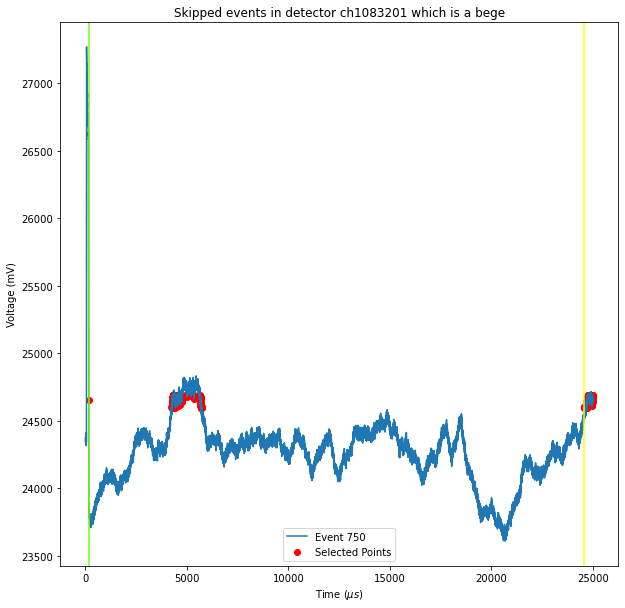

recovery rate 18839.2s
MICRODISCHARGE
Maximum difference: 15240.800000000001, 20414.4
Next Maximum difference: 1575.2, 6014.400000000001


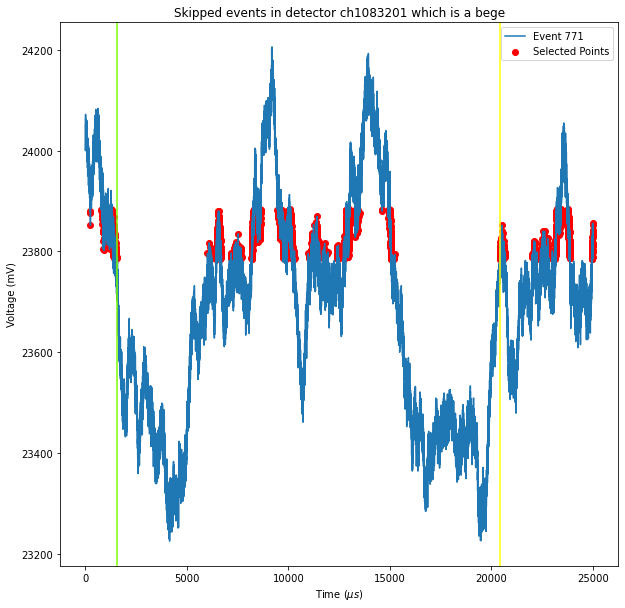

recovery rate 22691.2s
MICRODISCHARGE
Maximum difference: 16224.800000000001, 23519.2
Next Maximum difference: 828.0, 7444.8


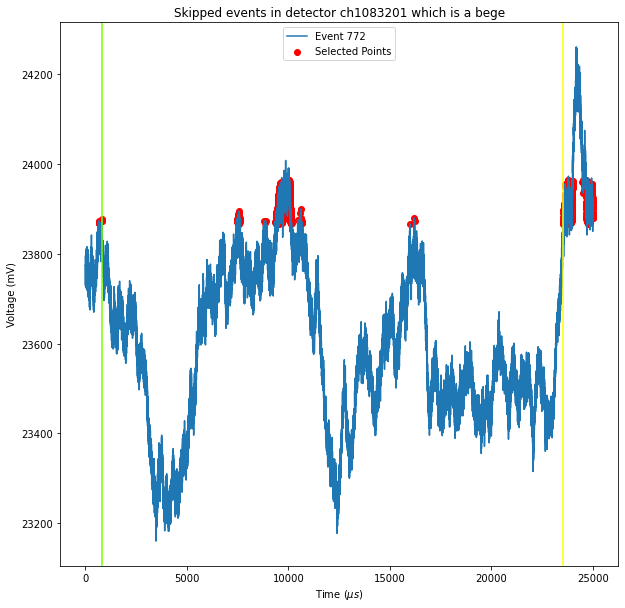

recovery rate 17156.0s
MICRODISCHARGE
Maximum difference: 19100.8, 24764.0
Next Maximum difference: 7608.0, 11417.6


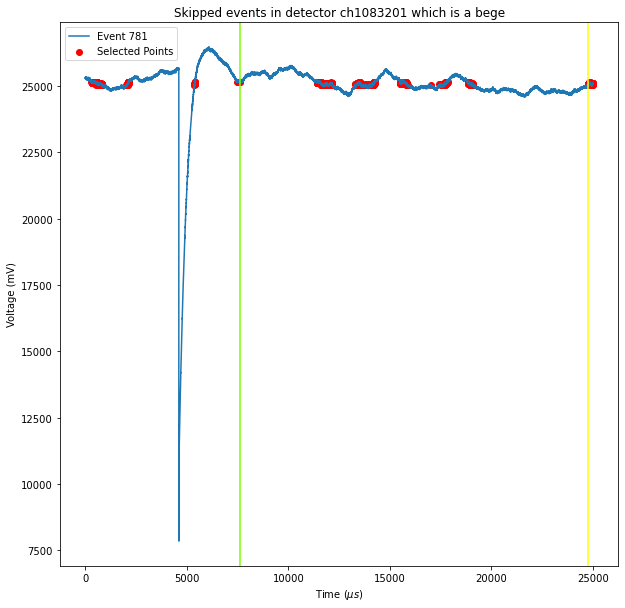

recovery rate 6404.0s
MICRODISCHARGE
Maximum difference: 15320.800000000001, 18435.2
Next Maximum difference: 12031.2, 14320.0


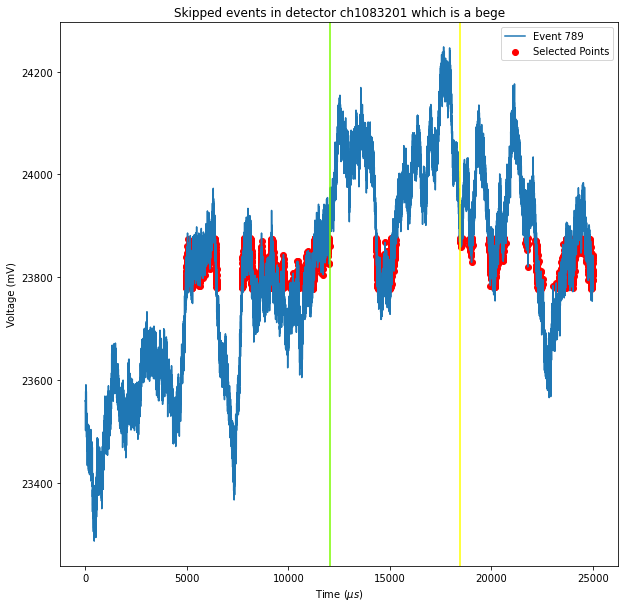

recovery rate 21642.4s
MICRODISCHARGE
Maximum difference: 16015.2, 24336.0
Next Maximum difference: 2693.6000000000004, 4886.400000000001


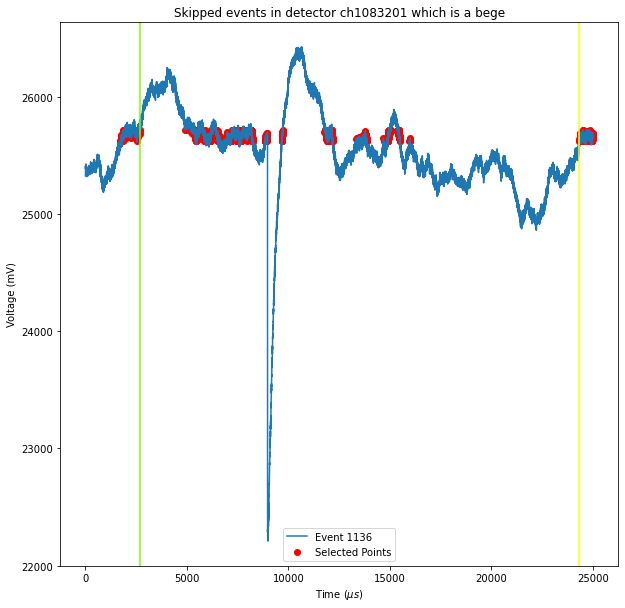

recovery rate 21600.0s
MICRODISCHARGE
Maximum difference: 5625.6, 24726.4
Next Maximum difference: 3126.4, 5226.400000000001


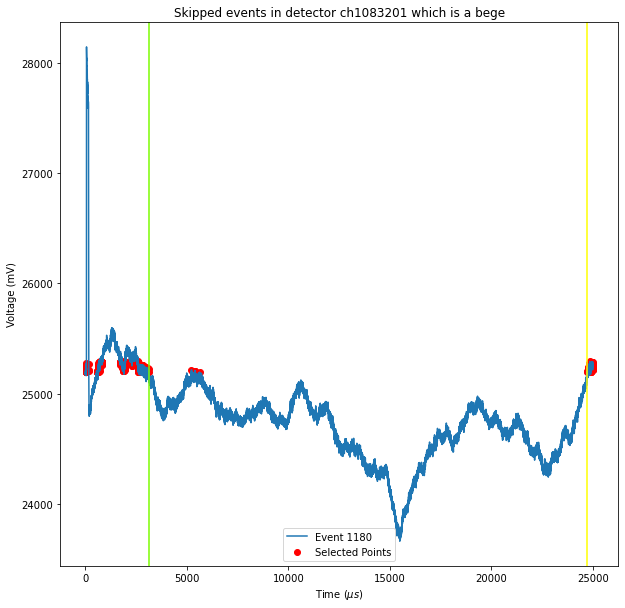

recovery rate 3748.0s
MICRODISCHARGE
Maximum difference: 22500.800000000003, 24373.600000000002
Next Maximum difference: 20625.600000000002, 20872.0


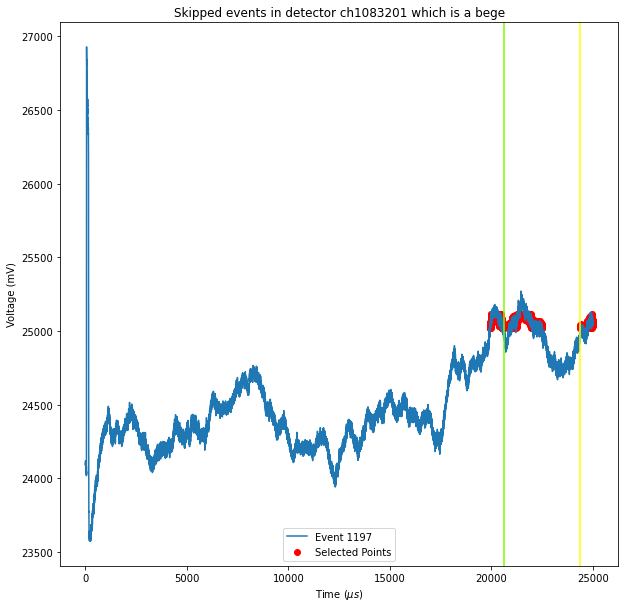

recovery rate -56.0s
MICRODISCHARGE
Maximum difference: 153.60000000000002, 24690.4
Next Maximum difference: 24746.4, 24769.600000000002


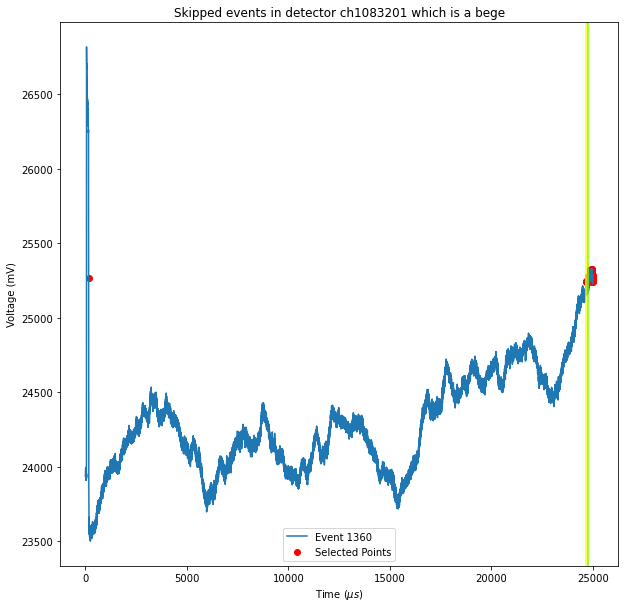

recovery rate -13591.2s
MICRODISCHARGE
Maximum difference: 49.6, 1189.6000000000001
Next Maximum difference: 14780.800000000001, 14837.6


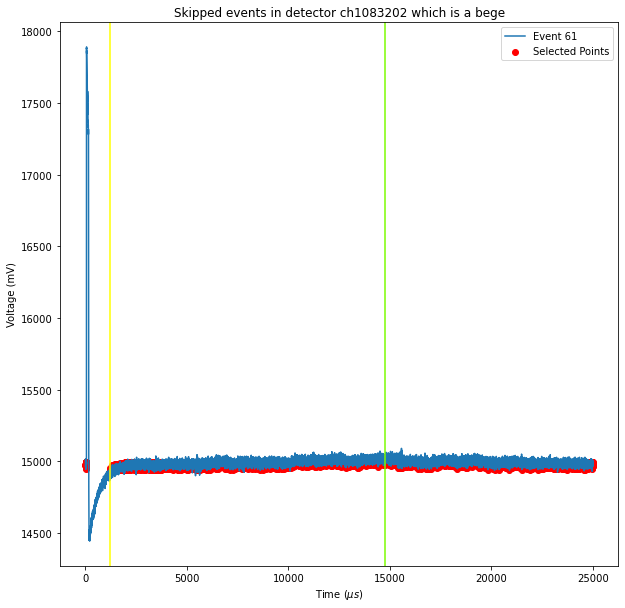

recovery rate 5074.400000000001s
DISCHARGE
Maximum difference: 531.2, 5074.400000000001
Next maximum difference: 5074.400000000001, 5193.6


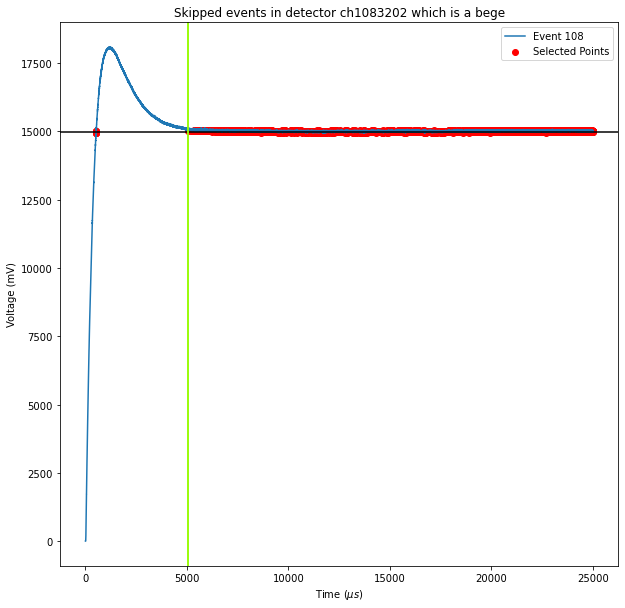

recovery rate 2828.0s
MICRODISCHARGE
Maximum difference: 427.20000000000005, 2828.0
Next Maximum difference: 2861.6000000000004, 3106.4


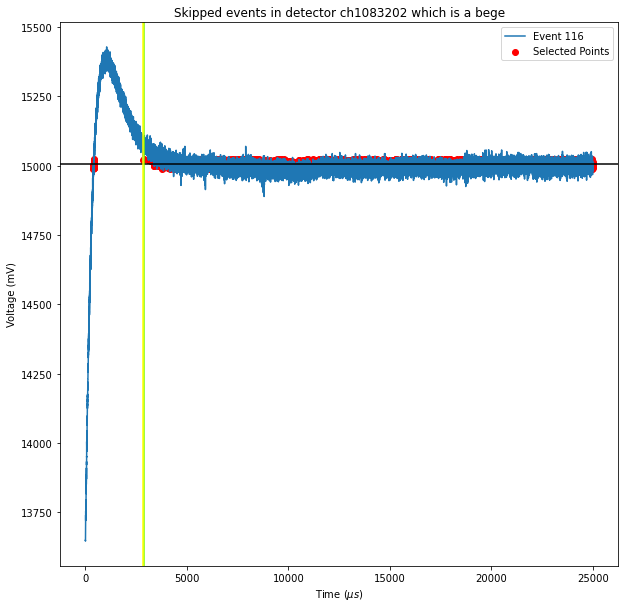

recovery rate 0.0s
MICRODISCHARGE
Maximum difference: 162.4, 1360.0
Next Maximum difference: 1360.0, 1526.4


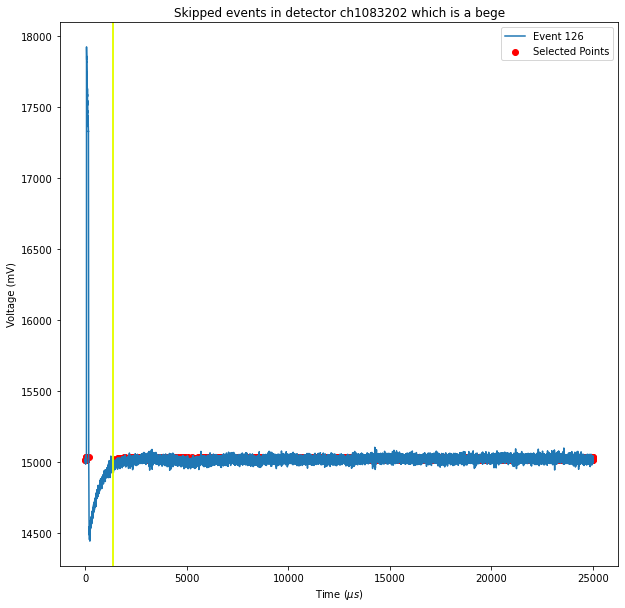

recovery rate 1361.6000000000001s
MICRODISCHARGE
Maximum difference: 163.20000000000002, 1411.2
Next Maximum difference: 49.6, 163.20000000000002


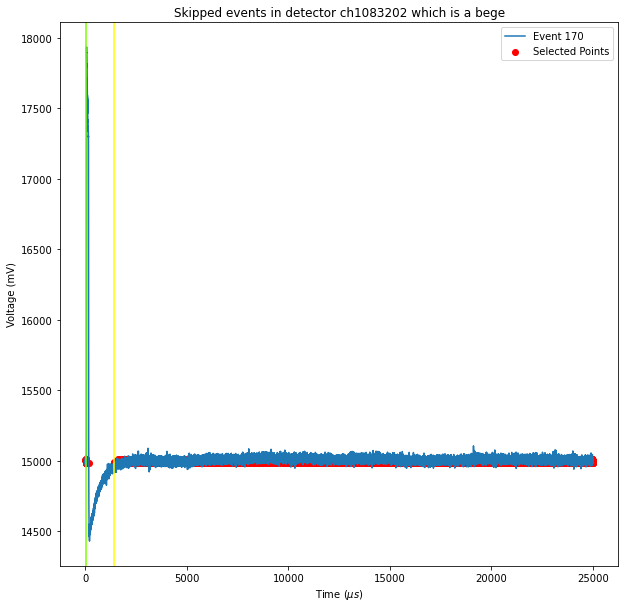

recovery rate 1384.8s
MICRODISCHARGE
Maximum difference: 162.4, 1431.2
Next Maximum difference: 46.400000000000006, 162.4


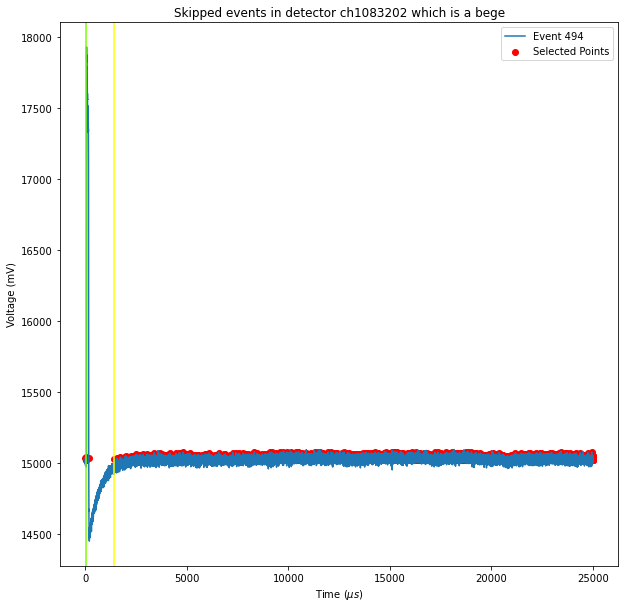

recovery rate -8.0s
MICRODISCHARGE
Maximum difference: 48.800000000000004, 1448.0
Next Maximum difference: 1456.0, 1480.8000000000002


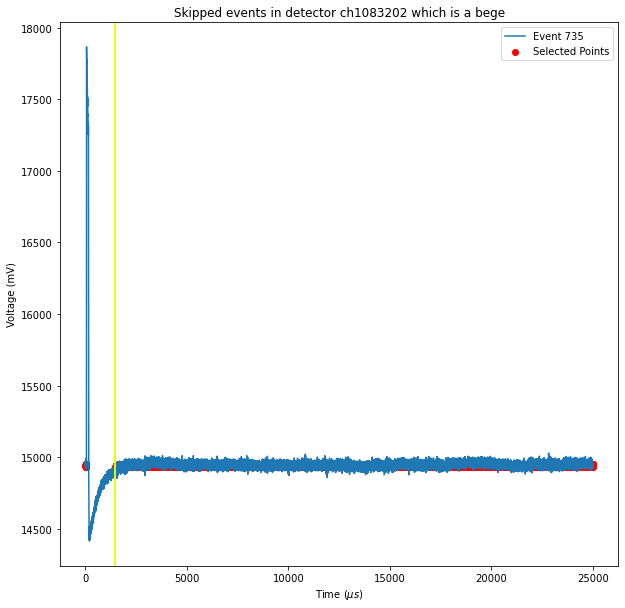

recovery rate -5330.400000000001s
MICRODISCHARGE
Maximum difference: 162.4, 1376.8000000000002
Next Maximum difference: 6707.200000000001, 7338.400000000001


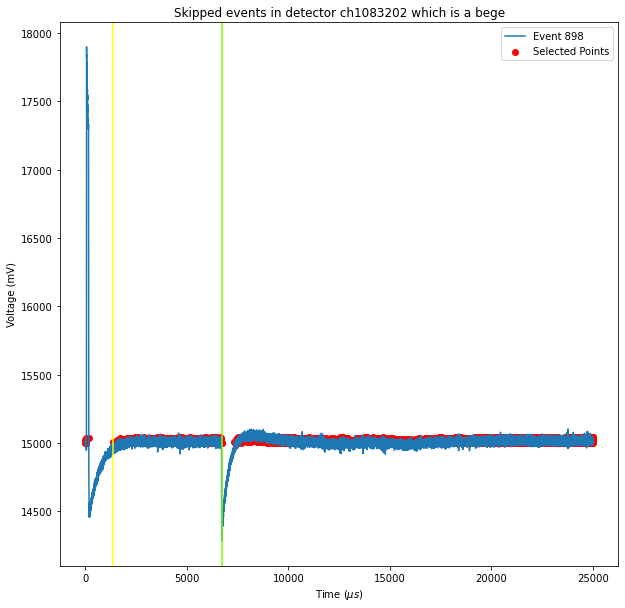

recovery rate -3238.4000000000015s
MICRODISCHARGE
Maximum difference: 8457.6, 8494.4
Next Maximum difference: 11732.800000000001, 11762.400000000001


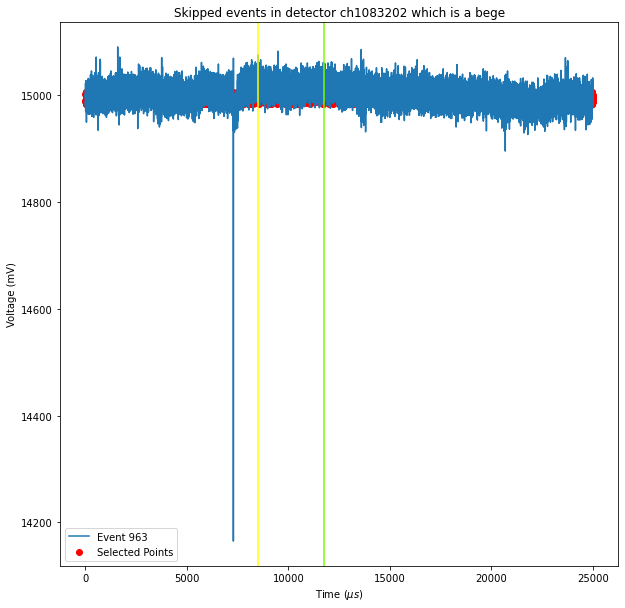

recovery rate -12568.0s
MICRODISCHARGE
Maximum difference: 161.60000000000002, 2724.0
Next Maximum difference: 15292.0, 15360.0


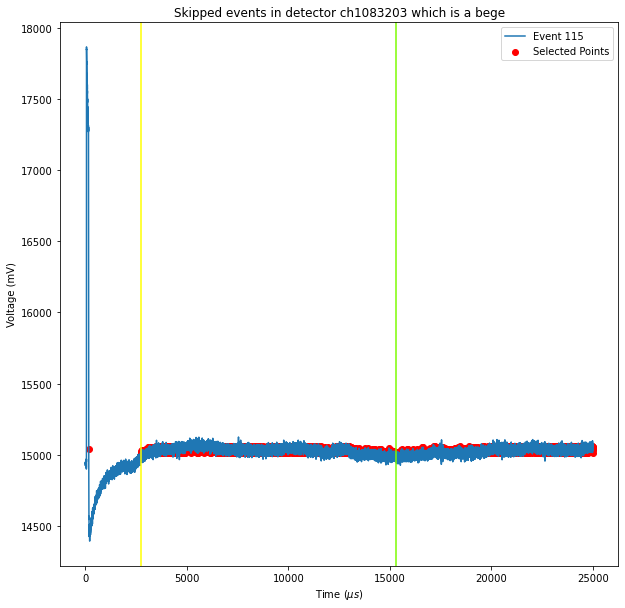

recovery rate 5138.400000000001s
DISCHARGE
Maximum difference: 445.6, 5138.400000000001
Next maximum difference: 5138.400000000001, 5280.8


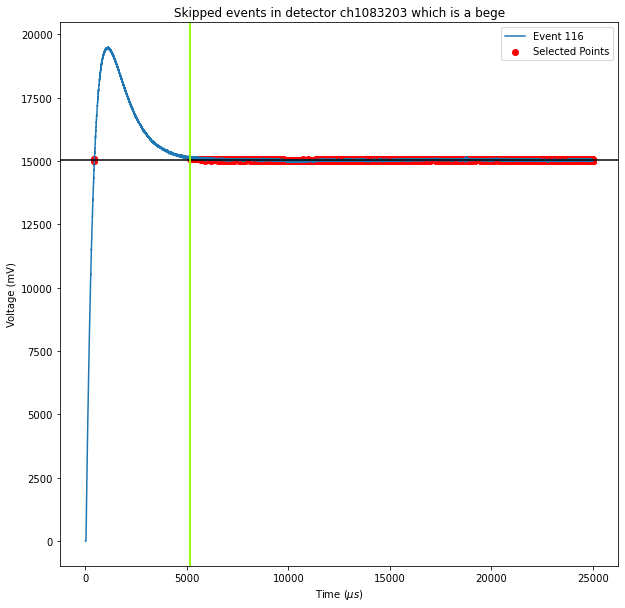

recovery rate 1749.6000000000001s
MICRODISCHARGE
Maximum difference: 163.20000000000002, 1797.6000000000001
Next Maximum difference: 48.0, 162.4


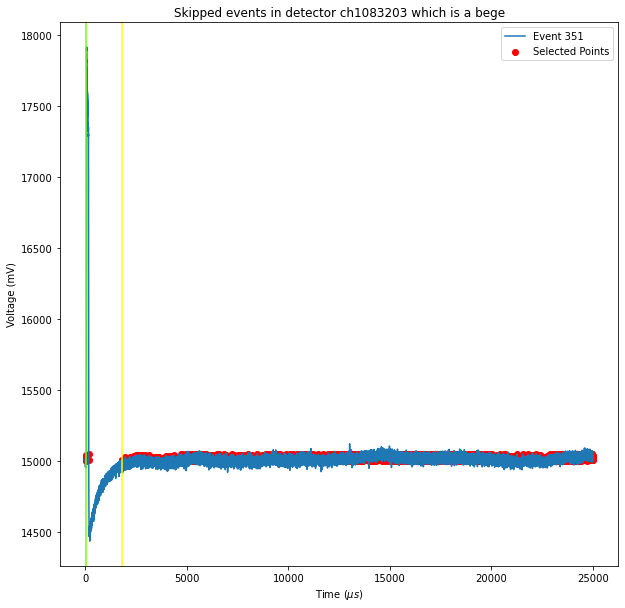

recovery rate 1523.2000000000003s
MICRODISCHARGE
Maximum difference: 162.4, 1572.8000000000002
Next Maximum difference: 49.6, 161.60000000000002


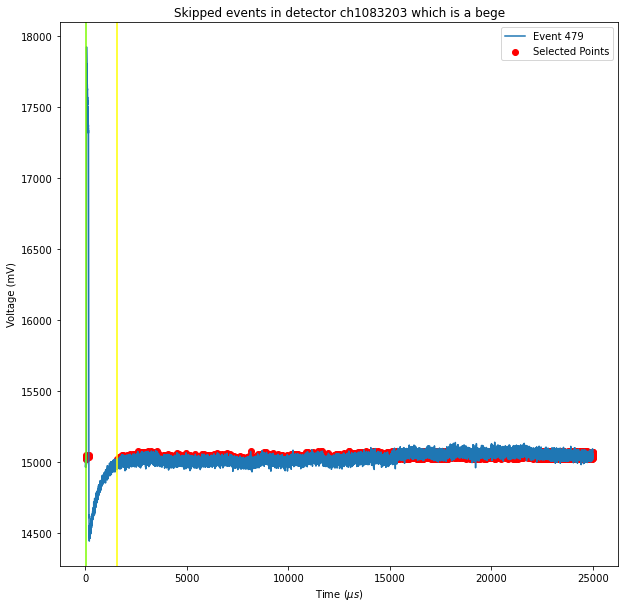

recovery rate 0.0s
MICRODISCHARGE
Maximum difference: 47.2, 1252.0
Next Maximum difference: 1252.0, 1374.4


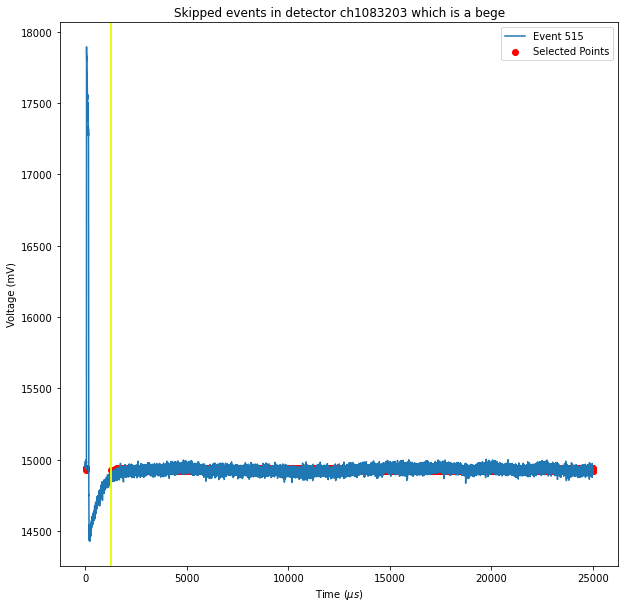

recovery rate 3457.600000000002s
MICRODISCHARGE
Maximum difference: 16691.2, 19345.600000000002
Next Maximum difference: 15888.0, 16597.600000000002


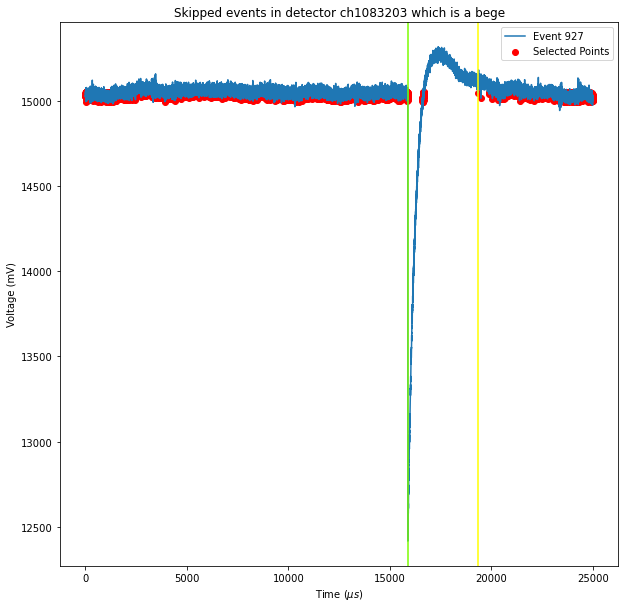

recovery rate -1105.6000000000004s
MICRODISCHARGE
Maximum difference: 7098.400000000001, 7295.200000000001
Next Maximum difference: 8400.800000000001, 8571.2


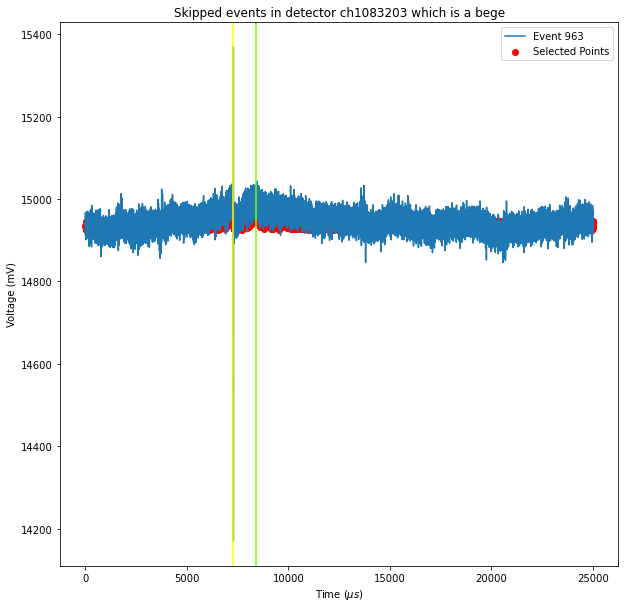

recovery rate 0.0s
MICRODISCHARGE
Maximum difference: 162.4, 1455.2
Next Maximum difference: 1455.2, 1750.4


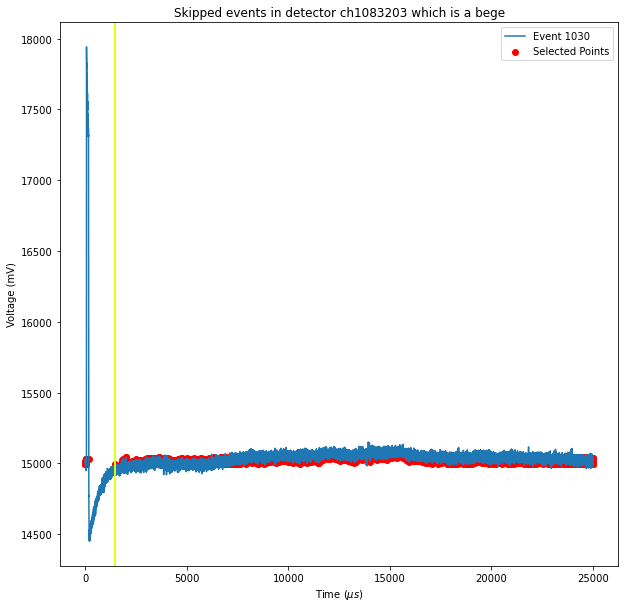

recovery rate 1081.6000000000001s
MICRODISCHARGE
Maximum difference: 164.0, 1130.4
Next Maximum difference: 48.800000000000004, 164.0


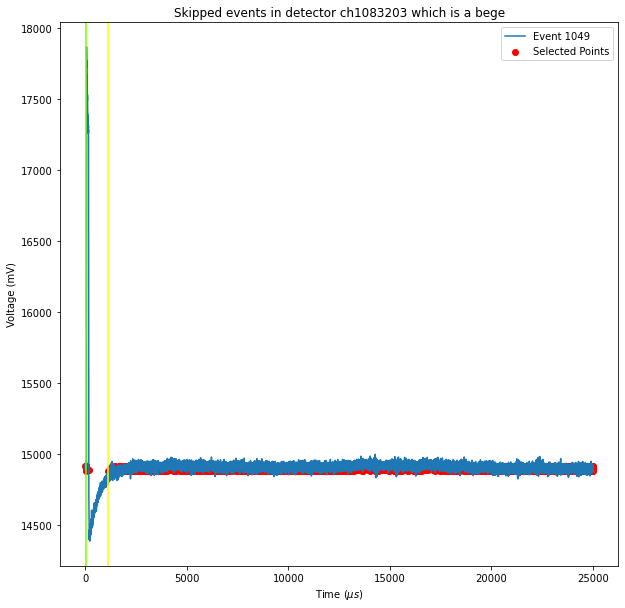

recovery rate 3257.6000000000004s
MICRODISCHARGE
Maximum difference: 8596.800000000001, 9344.800000000001
Next Maximum difference: 6087.200000000001, 6216.8


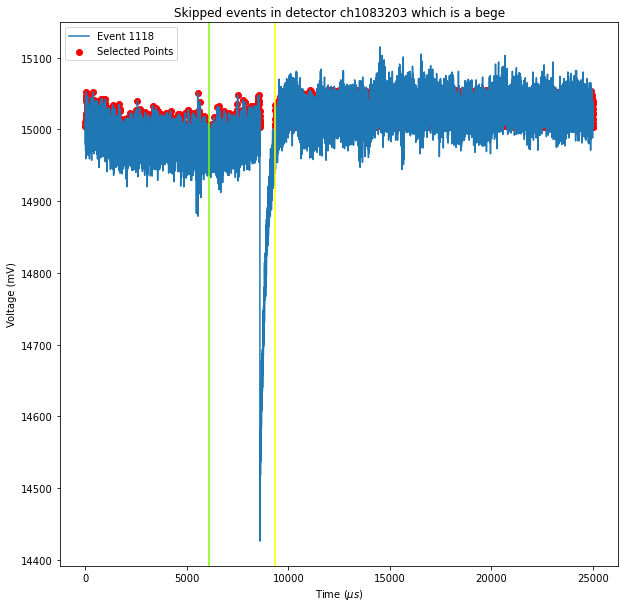

recovery rate 1167.2s
MICRODISCHARGE
Maximum difference: 163.20000000000002, 1216.8
Next Maximum difference: 49.6, 163.20000000000002


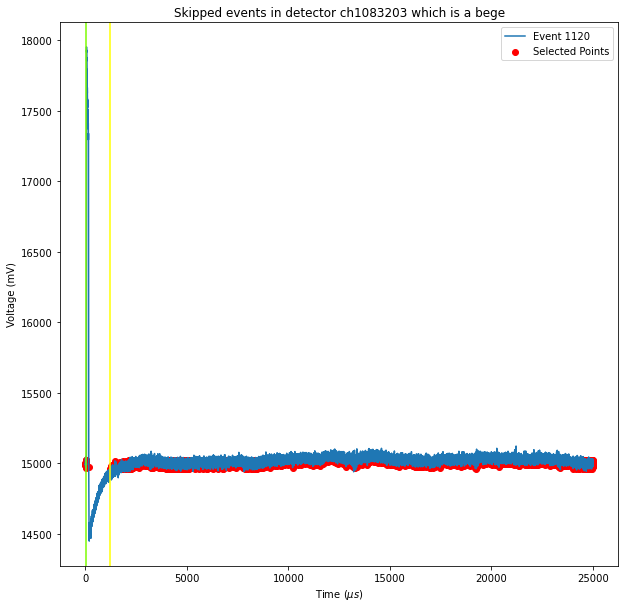

recovery rate -356.7999999999993s
MICRODISCHARGE
Maximum difference: 12612.0, 13403.2
Next Maximum difference: 13760.0, 14421.6


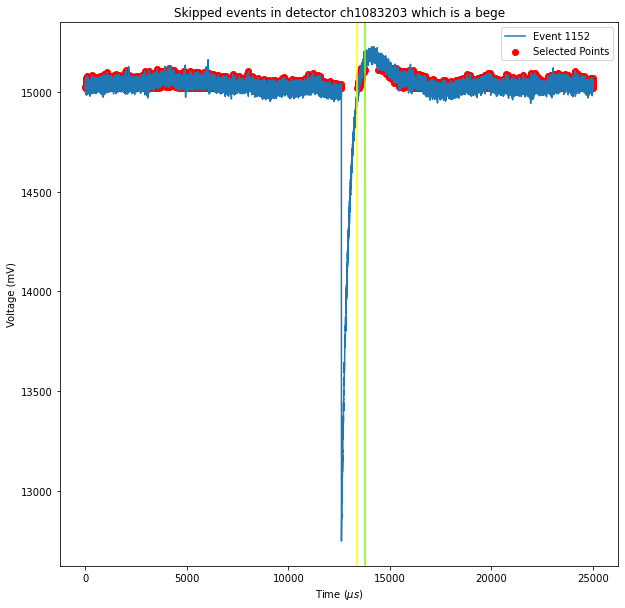

recovery rate 1149.6000000000001s
MICRODISCHARGE
Maximum difference: 163.20000000000002, 1199.2
Next Maximum difference: 49.6, 163.20000000000002


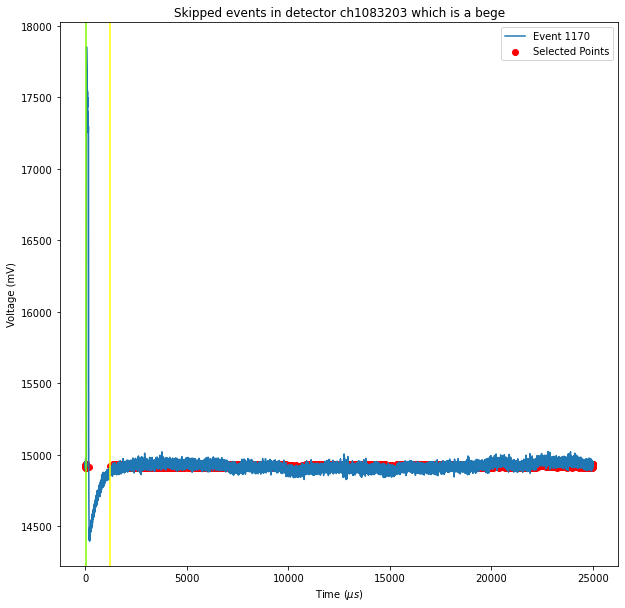

recovery rate 2116.0s
MICRODISCHARGE
Maximum difference: 163.20000000000002, 2164.8
Next Maximum difference: 48.800000000000004, 162.4


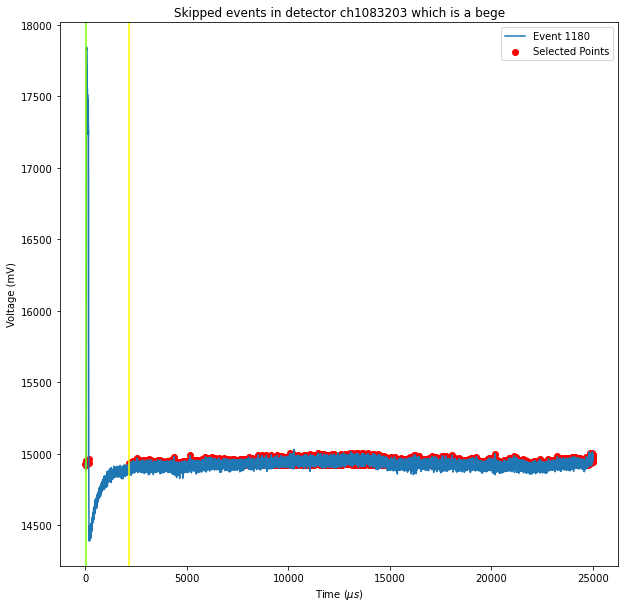

recovery rate -19336.0s
MICRODISCHARGE
Maximum difference: 916.0, 1534.4
Next Maximum difference: 20870.4, 20929.600000000002


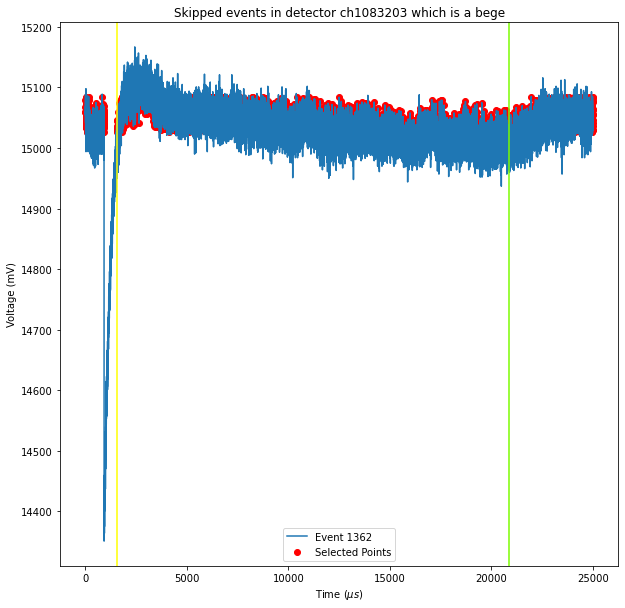

recovery rate -305.6s
MICRODISCHARGE
Maximum difference: 475.20000000000005, 504.0
Next Maximum difference: 809.6, 834.4000000000001


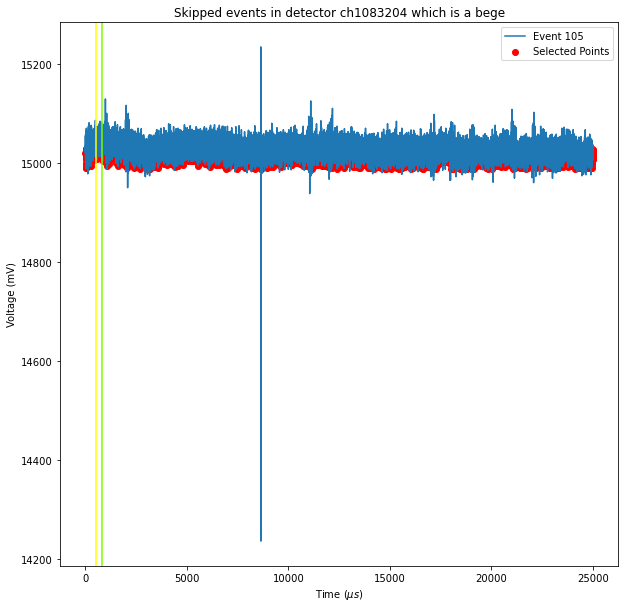

recovery rate -16289.600000000002s
MICRODISCHARGE
Maximum difference: 7288.8, 7416.8
Next Maximum difference: 23706.4, 23730.4


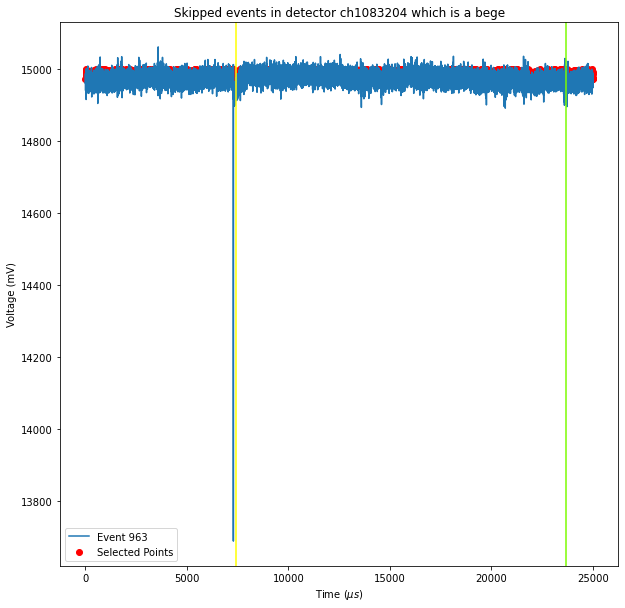

recovery rate 224.8000000000011s
MICRODISCHARGE
Maximum difference: 8820.800000000001, 8895.2
Next Maximum difference: 8670.4, 8709.6


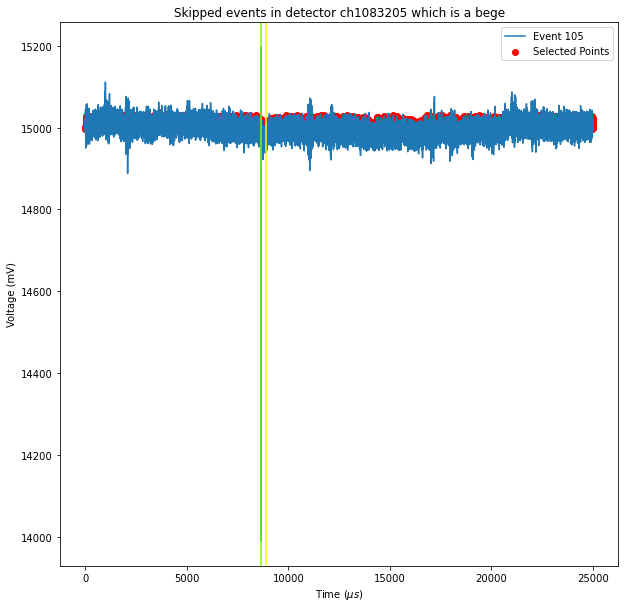

recovery rate 3394.4s
MICRODISCHARGE
Maximum difference: 368.0, 3394.4
Next Maximum difference: 7623.200000000001, 7646.400000000001


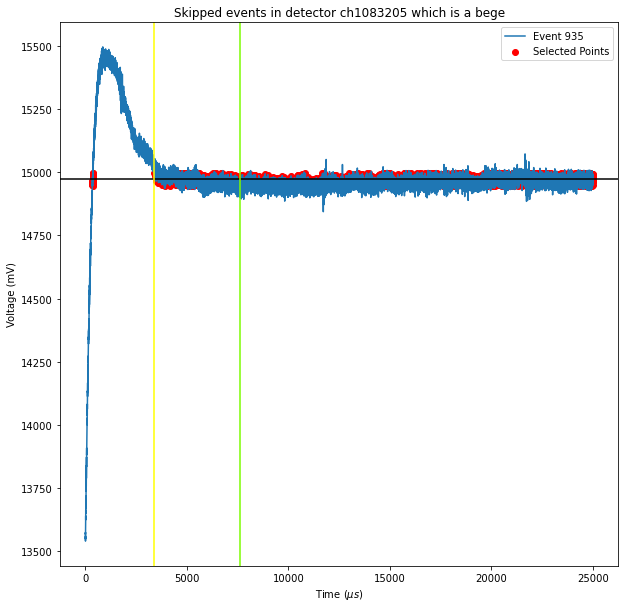

recovery rate 0.0s
MICRODISCHARGE
Maximum difference: 7292.8, 7496.8
Next Maximum difference: 7496.8, 7584.8


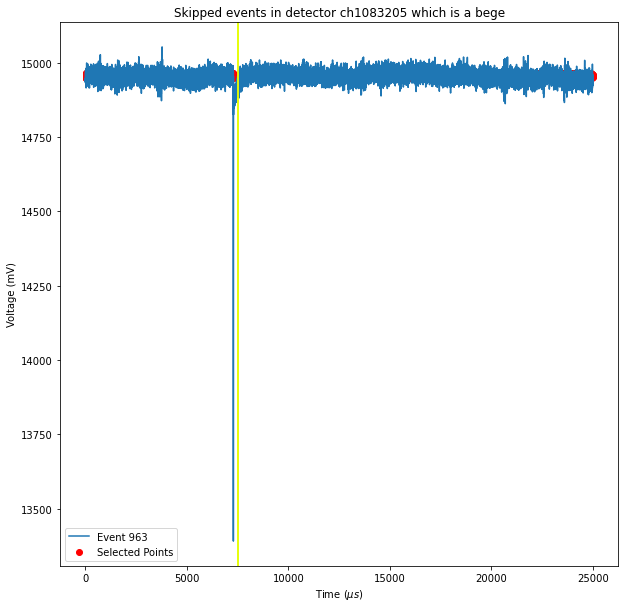

recovery rate -14039.199999999999s
MICRODISCHARGE
Maximum difference: 2020.0, 2561.6000000000004
Next Maximum difference: 16600.8, 16663.2


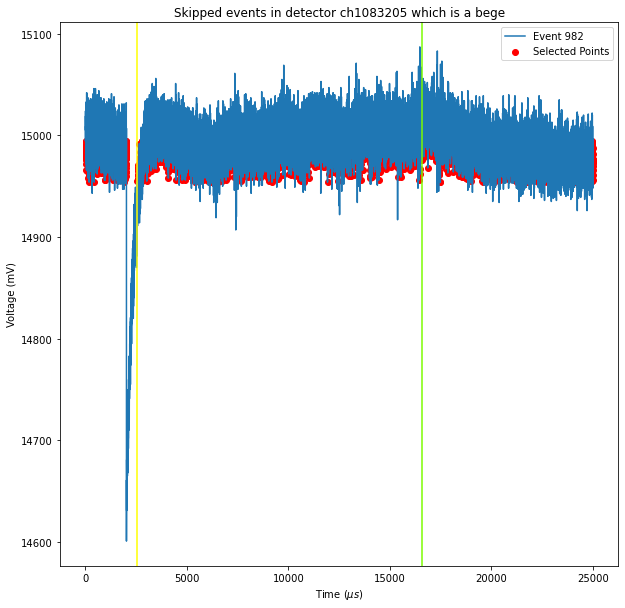

recovery rate 6858.400000000001s
MICRODISCHARGE
Maximum difference: 7420.0, 8979.2
Next Maximum difference: 2120.8, 3662.4


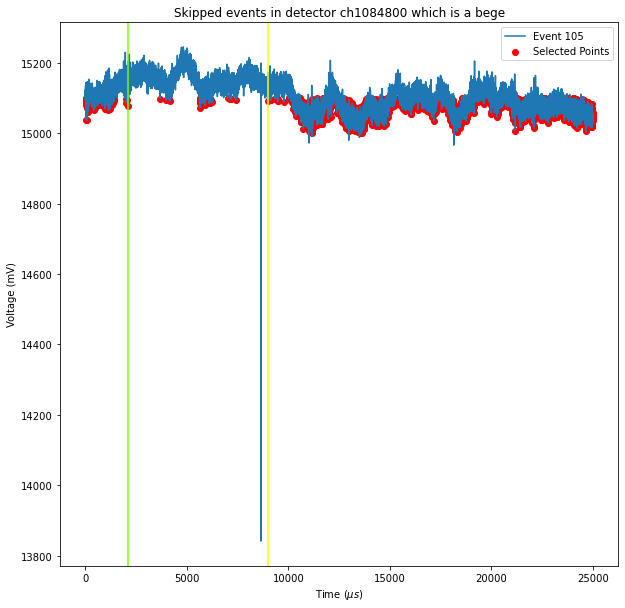

recovery rate 1800.8000000000002s
MICRODISCHARGE
Maximum difference: 1043.2, 1800.8000000000002
Next Maximum difference: 13126.400000000001, 13792.0


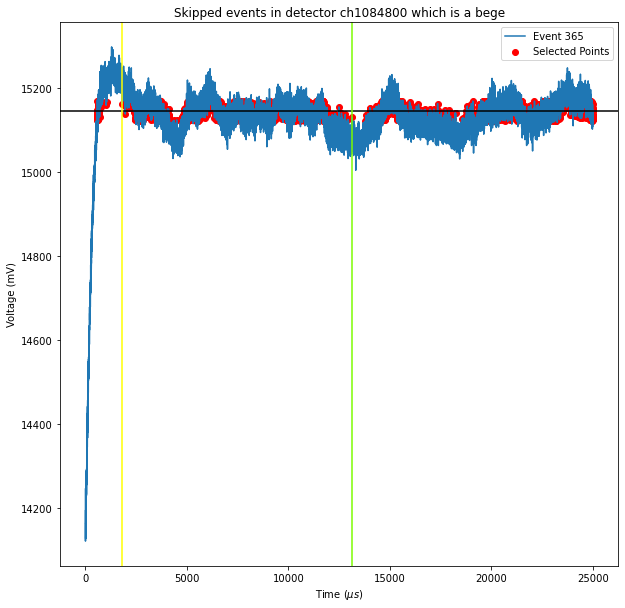

recovery rate 5810.400000000001s
DISCHARGE
Maximum difference: 385.6, 5810.400000000001
Next maximum difference: 7752.0, 8743.2


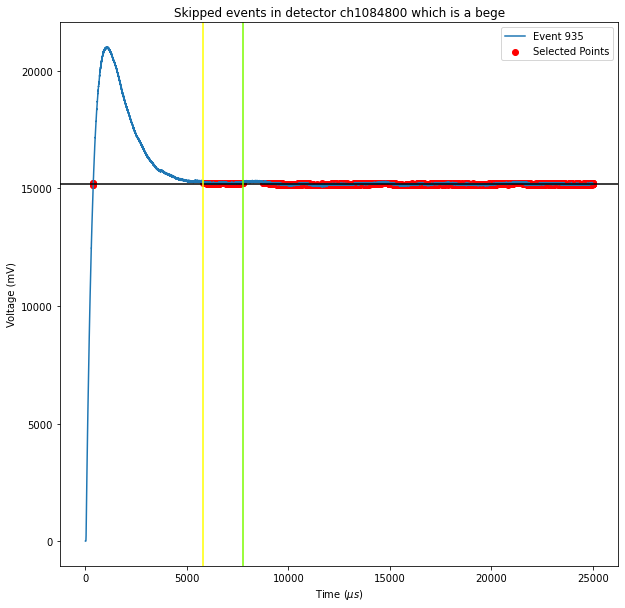

recovery rate 56.79999999999927s
MICRODISCHARGE
Maximum difference: 8679.2, 8706.4
Next Maximum difference: 8649.6, 8676.0


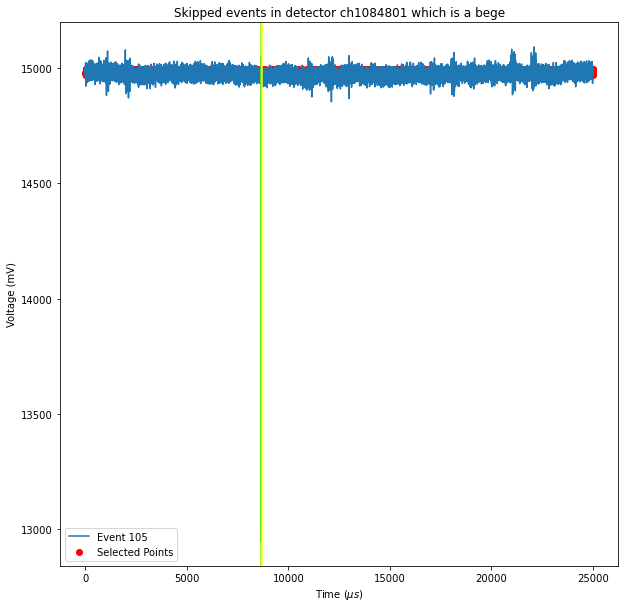

recovery rate 5037.6s
DISCHARGE
Maximum difference: 491.20000000000005, 5037.6
Next maximum difference: 5037.6, 5063.200000000001


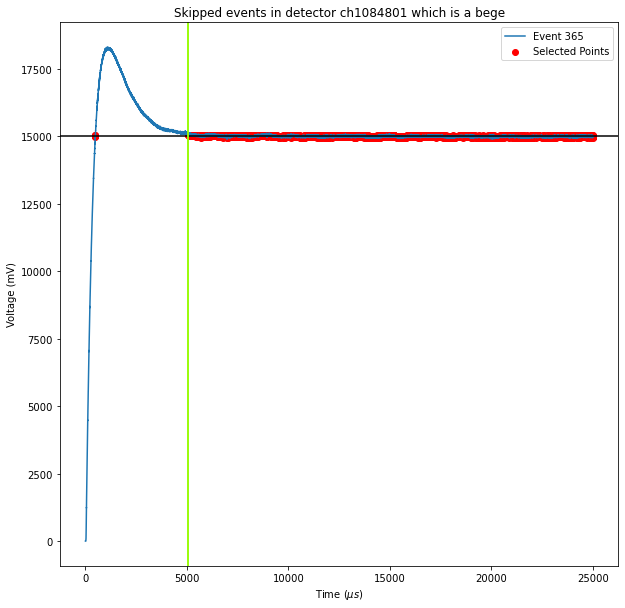

recovery rate -12.0s
MICRODISCHARGE
Maximum difference: 7288.8, 7388.8
Next Maximum difference: 7400.8, 7448.0


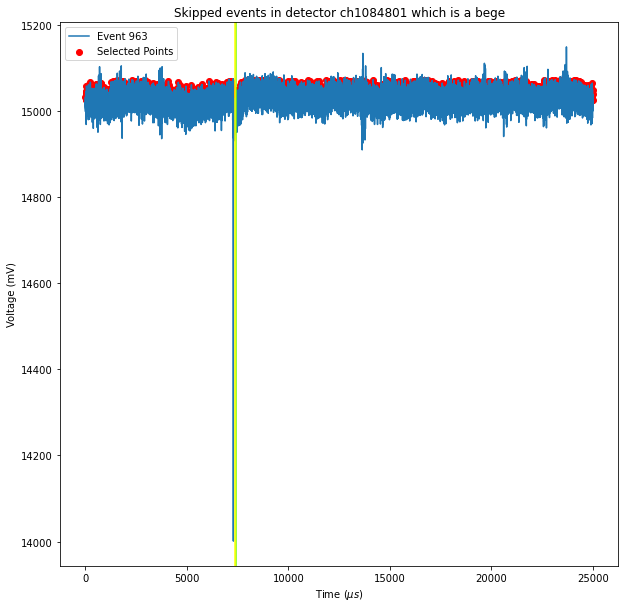

recovery rate -148.0s
MICRODISCHARGE
Maximum difference: 2877.6000000000004, 2964.8
Next Maximum difference: 3112.8, 3185.6000000000004


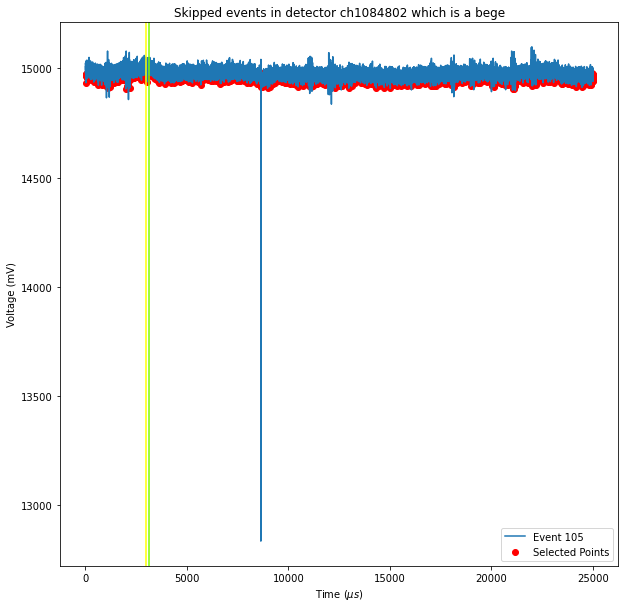

recovery rate 0.0s
MICRODISCHARGE
Maximum difference: 7287.200000000001, 7455.200000000001
Next Maximum difference: 7455.200000000001, 7495.200000000001


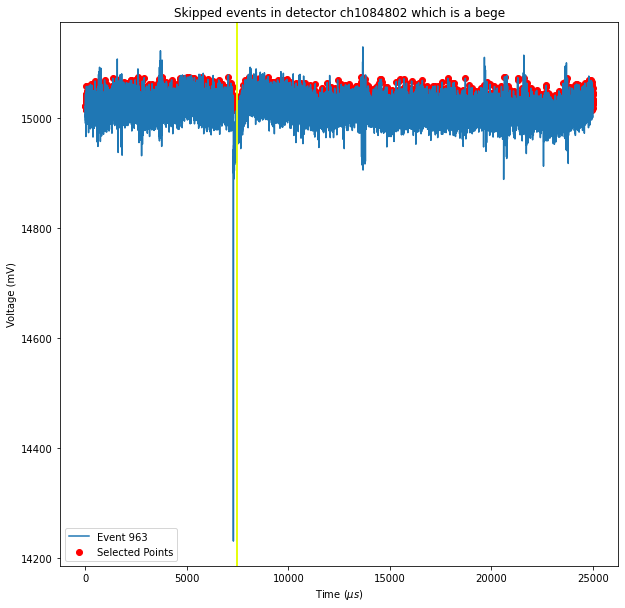

recovery rate 3707.2000000000007s
MICRODISCHARGE
Maximum difference: 8932.0, 11901.6
Next Maximum difference: 8194.4, 8880.800000000001


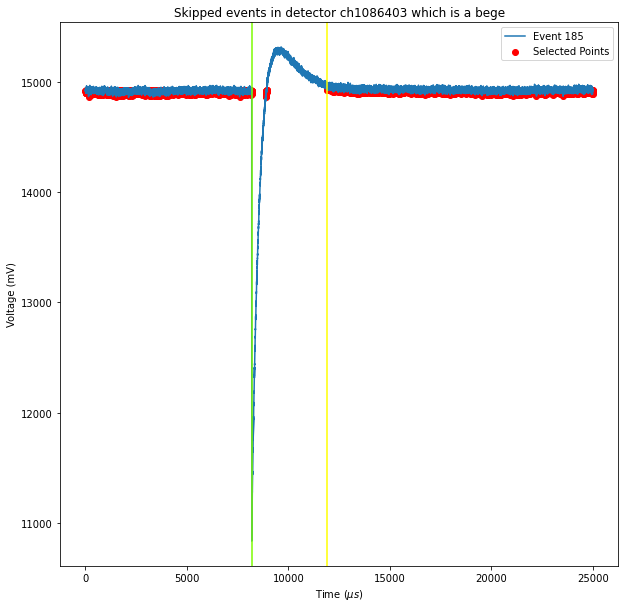

recovery rate 2538.4s
MICRODISCHARGE
Maximum difference: 528.0, 2538.4
Next Maximum difference: 2550.4, 2612.0


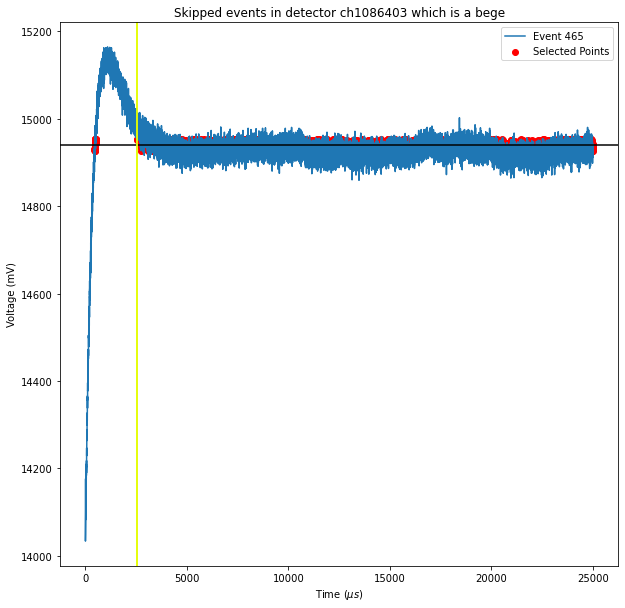

recovery rate 2084.0s
MICRODISCHARGE
Maximum difference: 12120.800000000001, 13357.6
Next Maximum difference: 11273.6, 11931.2


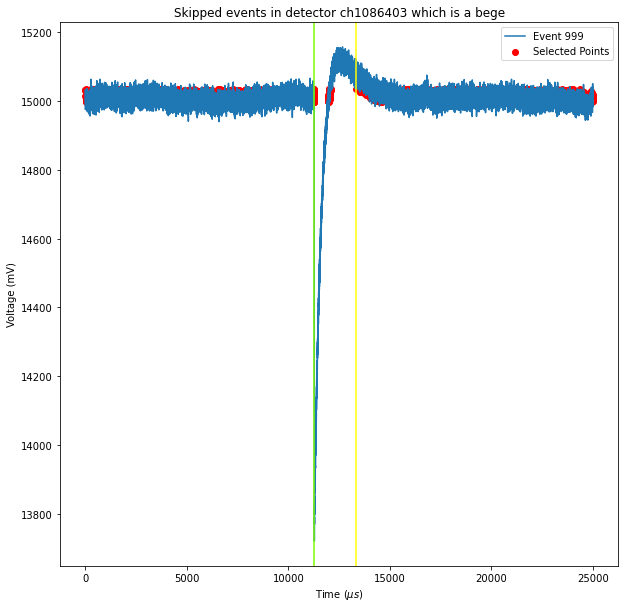

recovery rate 5368.8s
DISCHARGE
Maximum difference: 479.20000000000005, 5368.8
Next maximum difference: 5368.8, 5507.200000000001


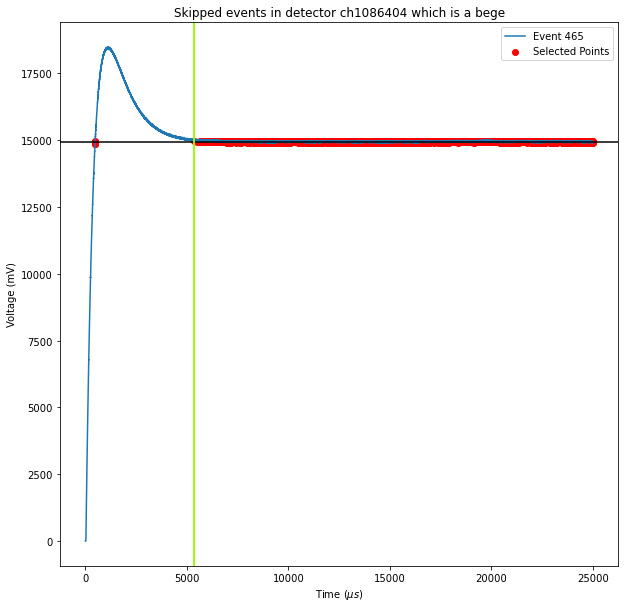

recovery rate 2221.6s
MICRODISCHARGE
Maximum difference: 572.8000000000001, 2221.6
Next Maximum difference: 2268.0, 2424.0


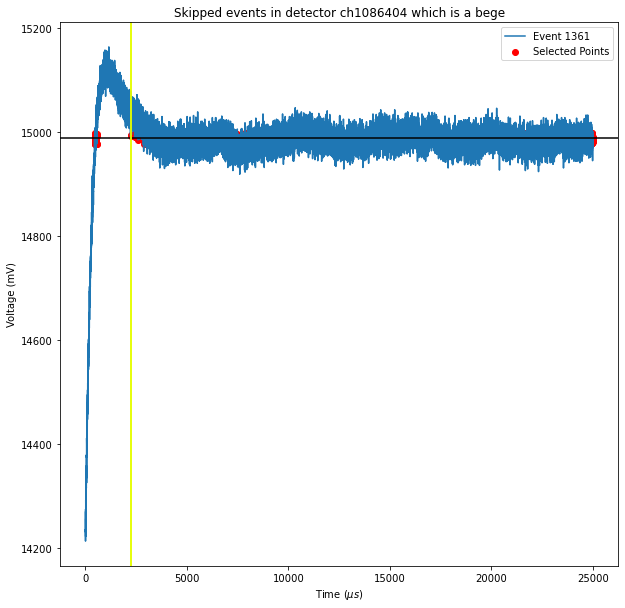

recovery rate 3384.0s
MICRODISCHARGE
Maximum difference: 10338.400000000001, 12891.2
Next Maximum difference: 9507.2, 10207.2


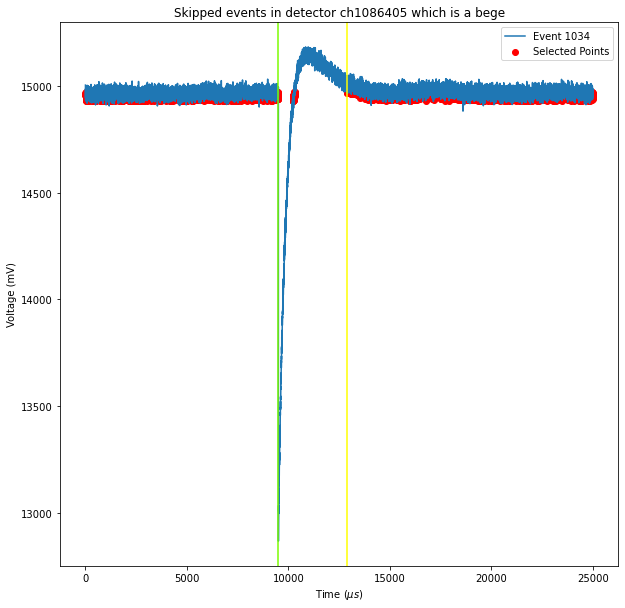

recovery rate 5132.0s
DISCHARGE
Maximum difference: 529.6, 5132.0
Next maximum difference: 5140.0, 5178.400000000001


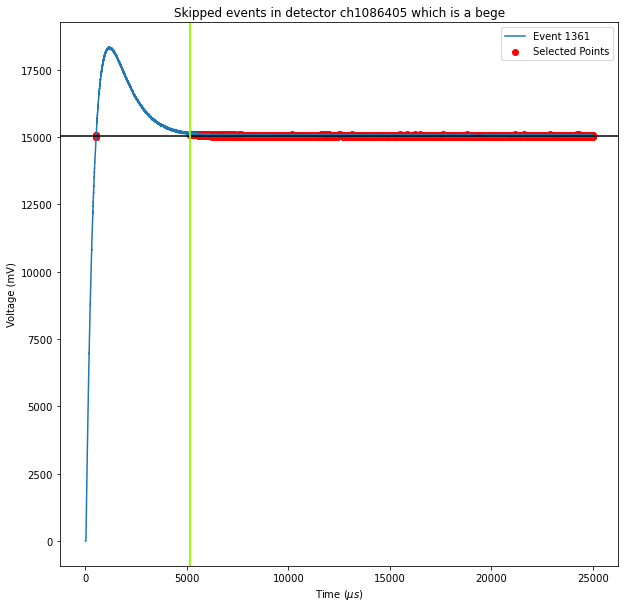

In [17]:
import pandas as pd

# Create an empty DataFrame to store the data
df = pd.DataFrame(columns=['Detector Name', 'Event','Type', 'Recovery Rate'])
df1 = pd.DataFrame(columns=['Detector Name', 'Event','Type', 'Recovery Rate'])


for j in detectors_bege:
    wfs_all = wfs_all_dict[j]
    index_skip1 = index_skipm[j]
    
    if len(index_skip1) < 20:
        for i in index_skip1:
            wf0 = wfs_all[i, :]
            mean_y = np.mean(wf0) 
            
            
            #weighted mean
            all_weight =[]
            for k in wf0:
                weight = abs(1/(k-mean_y))
                all_weight.append(weight)
                weighted_average = np.sum(k*weight)/np.sum(weight)
            
            #weighted standard deviation
            non_zero_weights = [weight for weight in all_weight if weight != 0]
            length1 = len(non_zero_weights)
            
            tops = []
            for k in wf0:
                weight = abs(1/(k-mean_y))
                top = weight*(k-weighted_average)**2
                tops.append(top)
            
            std_weight = np.sqrt(np.sum(tops)/((length1-1)*np.sum(all_weight)/length1))
            
            
                
            #print(std_weight)
            ts = np.arange(0, wf0.shape[0], 1) * 0.8  # micro s 
            #print(f"The mean y values is {mean_y}")
            #print(f"The weighted mean y values is {weighted_average}")
            plt.plot(ts[:], wf0[:], label=f'Event {i}')  # plot each skipped waveform
            
            for_append = []
            for_x = []
            if std_weight<50:
                # x values within the baseline range 
                # y values within the baseline range 
                for t, q in zip(ts, wf0):
                    if weighted_average-std_weight < q < weighted_average+std_weight:
                        for_x.append(t)
                        for_append.append(q)
            else:
                for t, q in zip(ts, wf0):
                    if weighted_average-50 < q < weighted_average+50:
                        for_x.append(t)
                        for_append.append(q)
                
            
            # Plot the x values
            
            plt.scatter(for_x, for_append, color='r', label='Selected Points')
            x_diff = [for_x[i+1] - for_x[i] for i in range(len(for_x)-1)]
            
            if len(x_diff)>0:
                # Determine the index for the maximum difference
                max_diff_index = np.argmax(x_diff)

                masked_data = np.ma.masked_equal(x_diff, np.max(x_diff))

                next_max_index = np.argmax(masked_data)

                # Use the index to get the corresponding x values
                max_diff_x1 = for_x[max_diff_index]
                max_diff_x2 = for_x[max_diff_index + 1]

                max_diff_x3 = for_x[next_max_index]
                max_diff_x4 = for_x[next_max_index + 1]
                
                if (wf0[0]<14800):
                    rec_rate = max_diff_x2
                    print(f"recovery rate {rec_rate}s")
                    plt.axhline(y=weighted_average,color='k')
                else:
                    rec_rate = max_diff_x2-max_diff_x3
                    print(f"recovery rate {rec_rate}s")
                
                
                if np.any(wf0[:]==0):
                    discharge_type = "discharge"
                    #plt.axvline(x=rec_rate,color='lawngreen')
                    plt.axvline(x=max_diff_x2,color='yellow')
                    plt.axvline(x=max_diff_x3,color='lawngreen')
                    print("DISCHARGE")
                    print(f"Maximum difference: {max_diff_x1}, {max_diff_x2}")
                    print(f"Next maximum difference: {max_diff_x3}, {max_diff_x4}")
                    df = df.append({
                        'Detector Name': j,
                        'Event':i,
                        'Type': discharge_type,
                        'Recovery Rate': rec_rate
                    }, ignore_index=True)                    
                else:
                    discharge_type = "microdischarge"
                    plt.axvline(x=max_diff_x3,color='lawngreen')
                    plt.axvline(x=max_diff_x2,color='yellow')
                    print("MICRODISCHARGE")
                    print(f"Maximum difference: {max_diff_x1}, {max_diff_x2}")
                    print(f"Next Maximum difference: {max_diff_x3}, {max_diff_x4}")
                    df1 = df1.append({
                        'Detector Name': j,
                        'Event':i,
                        'Type': discharge_type,
                        'Recovery Rate': rec_rate
                    }, ignore_index=True)
            
            else:
                print("NO DISCHARGE")

            
            # Customize plot
            #plt.axhline(y=mean_y,color='lawngreen')
            #plt.axhline(y=weighted_average,color='k')
            plt.xlabel('Time ($\mu s$)')
            plt.ylabel('Voltage (mV)')
            plt.title(f'Skipped events in detector {j} which is a {test}')
            plt.legend()
            plt.show()

In [18]:
excel_filename = 'discharge_bege1.xlsx'
df.to_excel(excel_filename, index=False)

excel_filename1 = 'microdischarge_bege1.xlsx'
df1.to_excel(excel_filename1, index=False)

recovery rate 4913.6s
DISCHARGE
Maximum difference: 462.40000000000003, 4913.6
Next maximum difference: 5379.200000000001, 5685.6


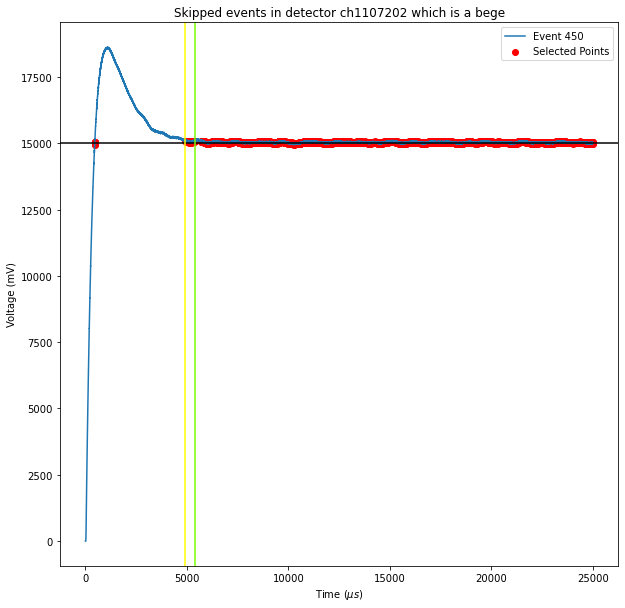

recovery rate 3176.8s
MICRODISCHARGE
Maximum difference: 4576.8, 6790.400000000001
Next Maximum difference: 3613.6000000000004, 4424.0


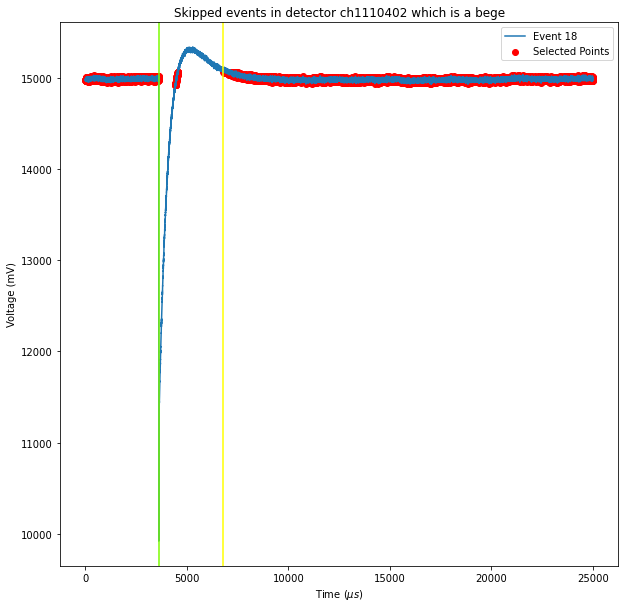

recovery rate 5.599999999998545s
MICRODISCHARGE
Maximum difference: 24944.0, 24946.4
Next Maximum difference: 24940.800000000003, 24943.2


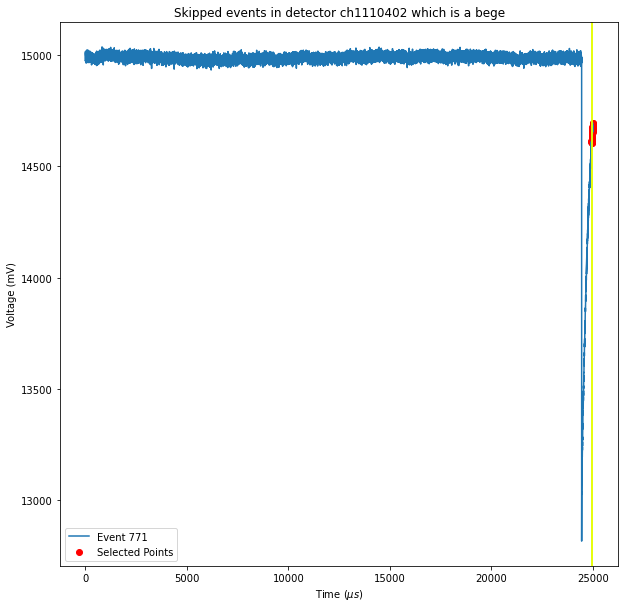

recovery rate 2772.0s
MICRODISCHARGE
Maximum difference: 509.6, 2772.0
Next Maximum difference: 2772.0, 2822.4


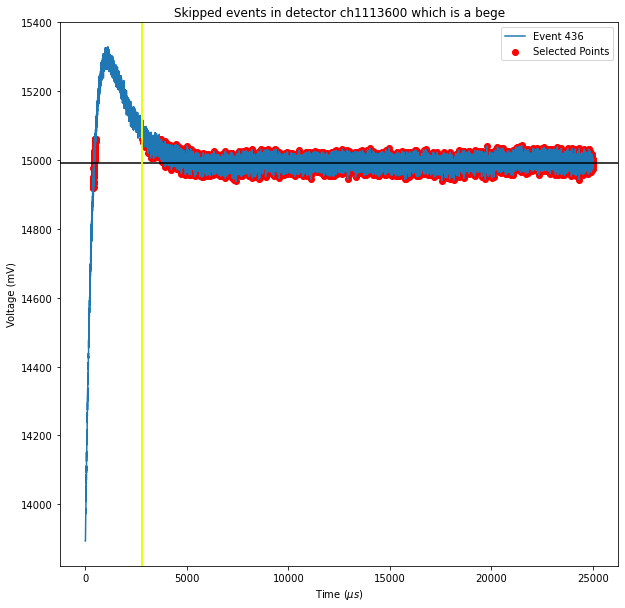

recovery rate 2583.2000000000003s
MICRODISCHARGE
Maximum difference: 424.0, 2583.2000000000003
Next Maximum difference: 2583.2000000000003, 2597.6000000000004


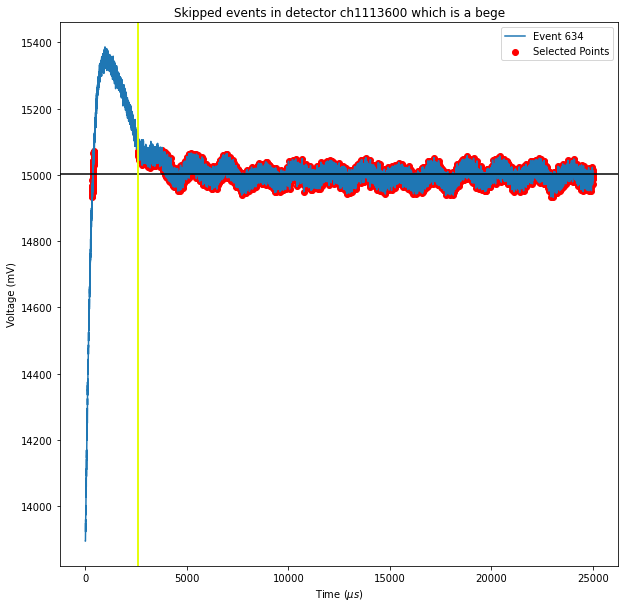

recovery rate 3160.8s
MICRODISCHARGE
Maximum difference: 222.4, 3160.8
Next Maximum difference: 3160.8, 3229.6000000000004


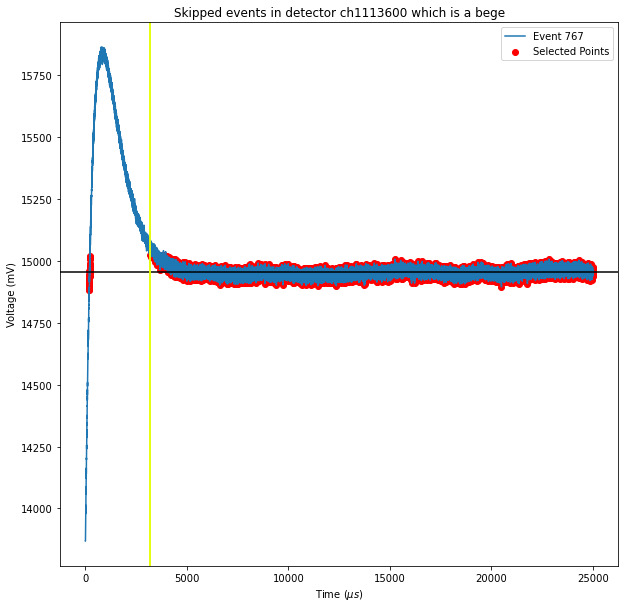

recovery rate 2846.4s
MICRODISCHARGE
Maximum difference: 356.8, 2846.4
Next Maximum difference: 2846.4, 2898.4


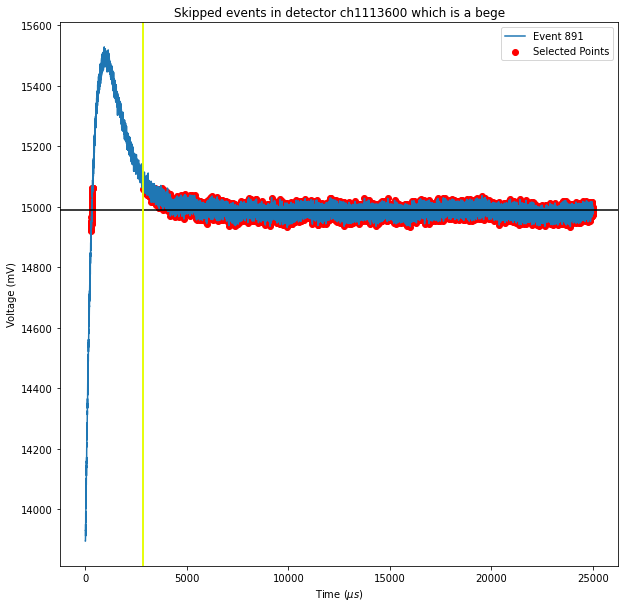

recovery rate 2747.2000000000003s
MICRODISCHARGE
Maximum difference: 594.4, 2747.2000000000003
Next Maximum difference: 2772.8, 2831.2000000000003


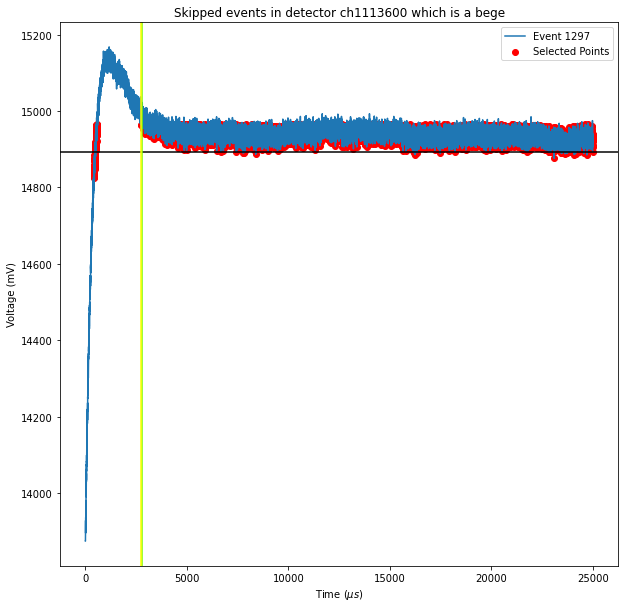

recovery rate 4787.2s
DISCHARGE
Maximum difference: 479.20000000000005, 4787.2
Next maximum difference: 5142.400000000001, 5379.200000000001


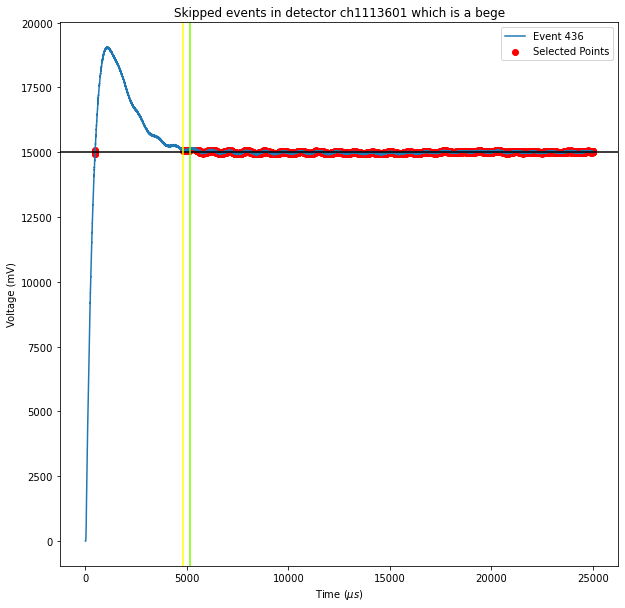

recovery rate 4406.400000000001s
DISCHARGE
Maximum difference: 392.0, 4406.400000000001
Next maximum difference: 4663.2, 5869.6


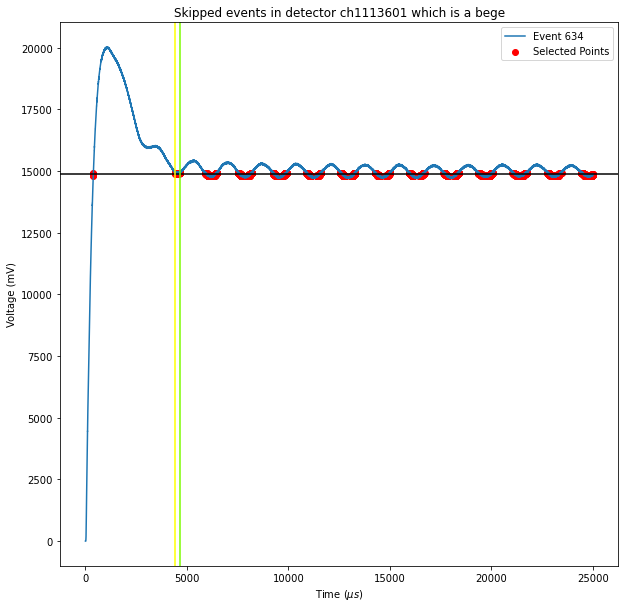

recovery rate 6129.6s
DISCHARGE
Maximum difference: 227.20000000000002, 6129.6
Next maximum difference: 6183.200000000001, 6288.0


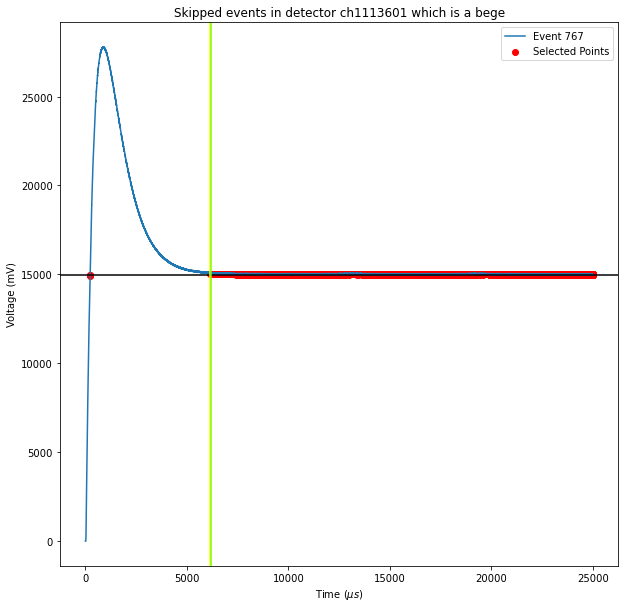

recovery rate -648.7999999999993s
MICRODISCHARGE
Maximum difference: 11732.800000000001, 12356.800000000001
Next Maximum difference: 13005.6, 13341.6


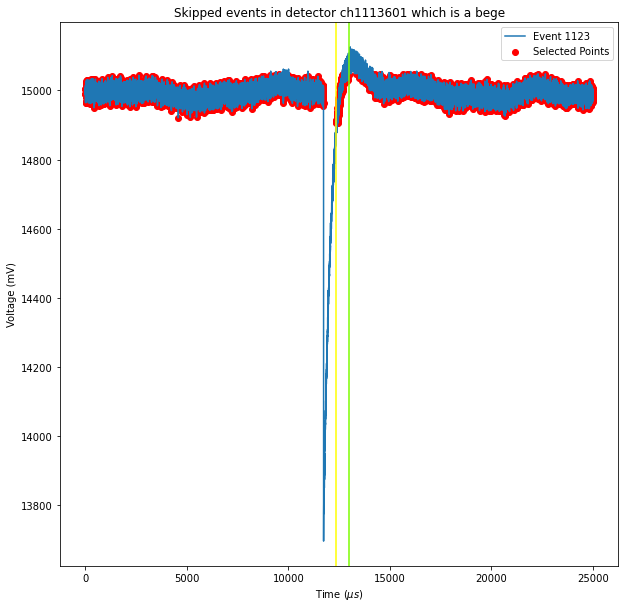

recovery rate 2226.4000000000015s
MICRODISCHARGE
Maximum difference: 17473.600000000002, 18723.2
Next Maximum difference: 16496.8, 17109.600000000002


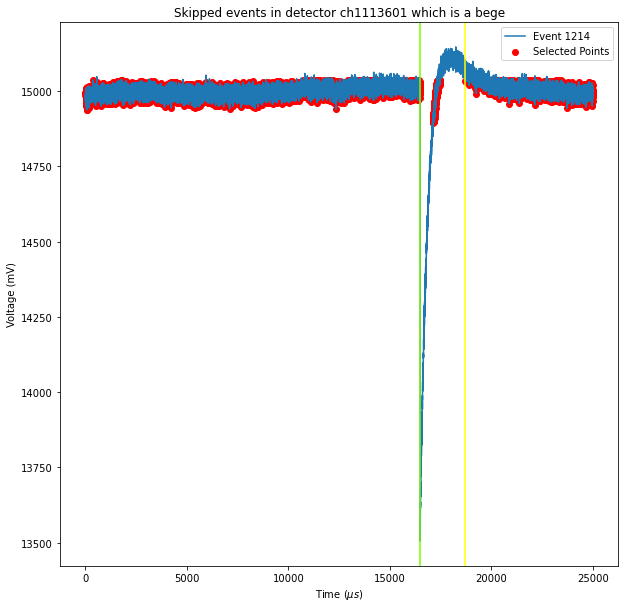

recovery rate 4688.8s
DISCHARGE
Maximum difference: 571.2, 4688.8
Next maximum difference: 4688.8, 4724.0


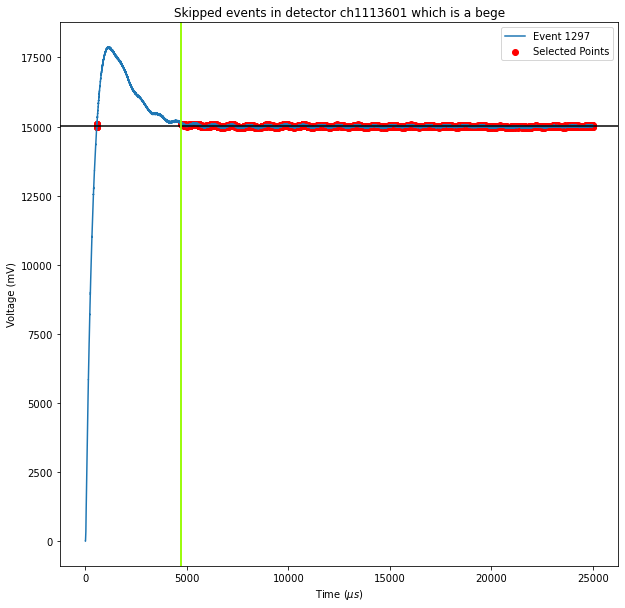

recovery rate 2626.4s
MICRODISCHARGE
Maximum difference: 488.0, 2626.4
Next Maximum difference: 2626.4, 2684.0


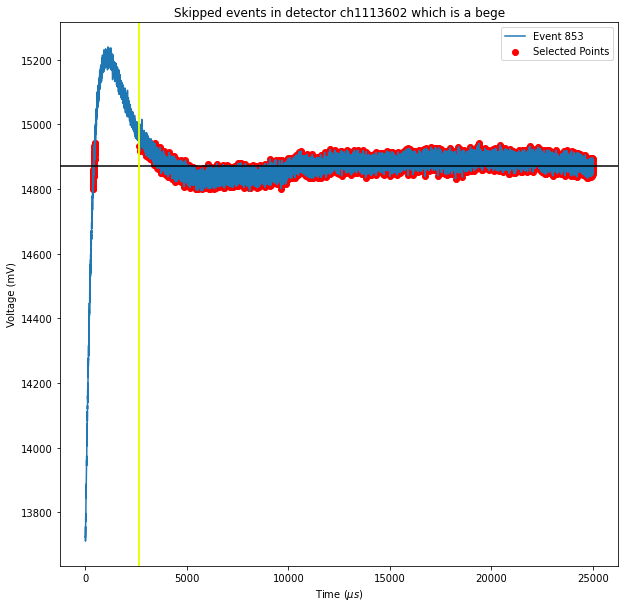

recovery rate -852.0s
MICRODISCHARGE
Maximum difference: 22043.2, 22611.2
Next Maximum difference: 23463.2, 23512.800000000003


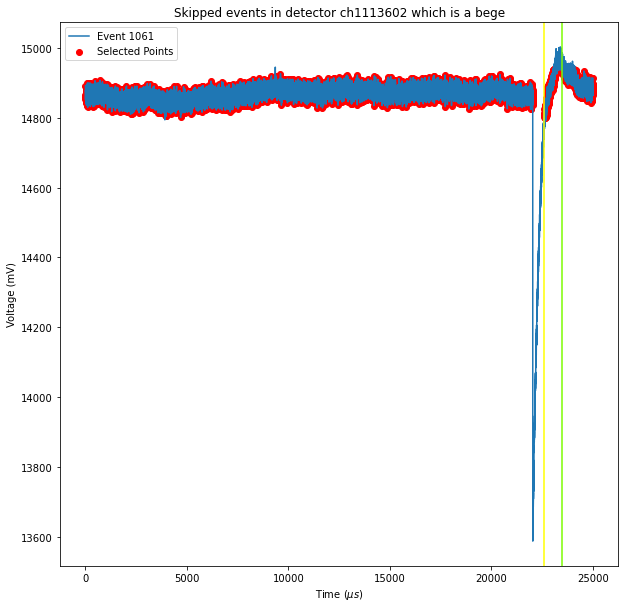

recovery rate 4737.6s
DISCHARGE
Maximum difference: 12561.6, 16470.4
Next maximum difference: 11732.800000000001, 12534.400000000001


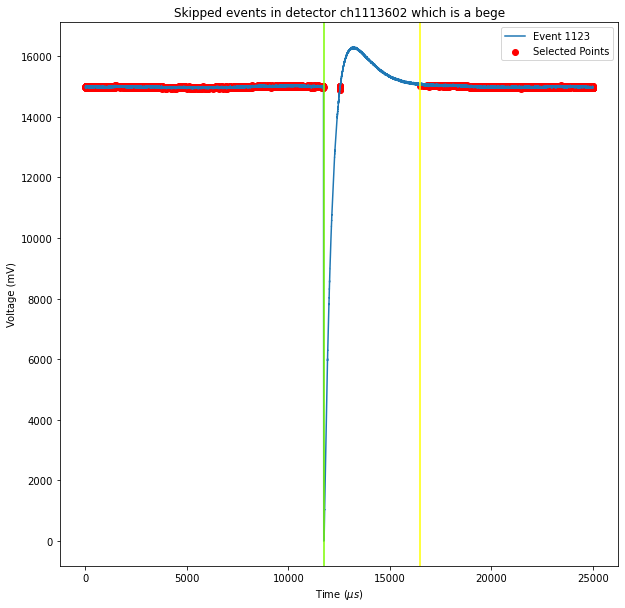

recovery rate 5034.4000000000015s
DISCHARGE
Maximum difference: 17320.8, 21531.2
Next maximum difference: 16496.8, 17304.8


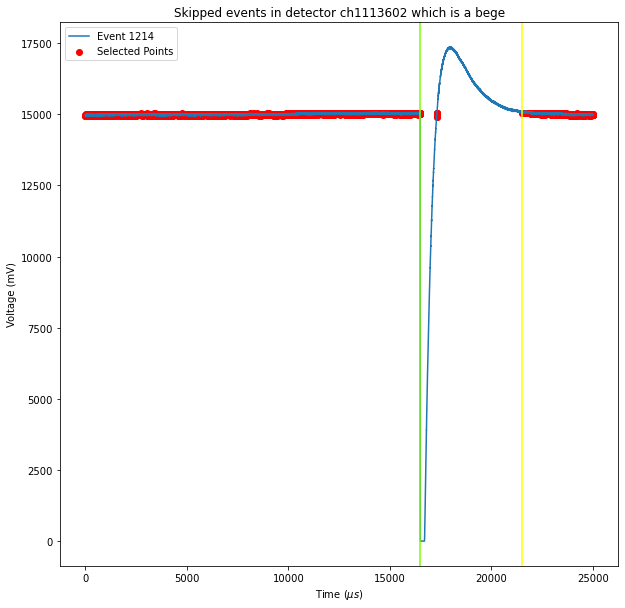

recovery rate 2592.0s
MICRODISCHARGE
Maximum difference: 632.0, 2592.0
Next Maximum difference: 23323.2, 24364.0


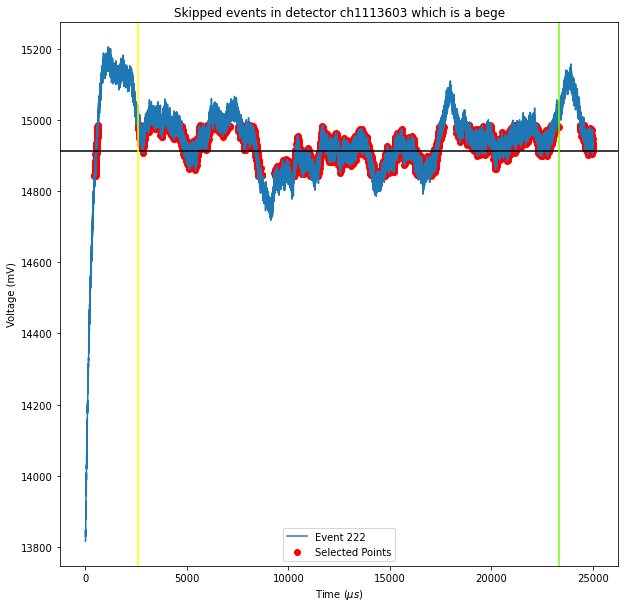

recovery rate 5452.8s
DISCHARGE
Maximum difference: 474.40000000000003, 5452.8
Next maximum difference: 15978.400000000001, 19605.600000000002


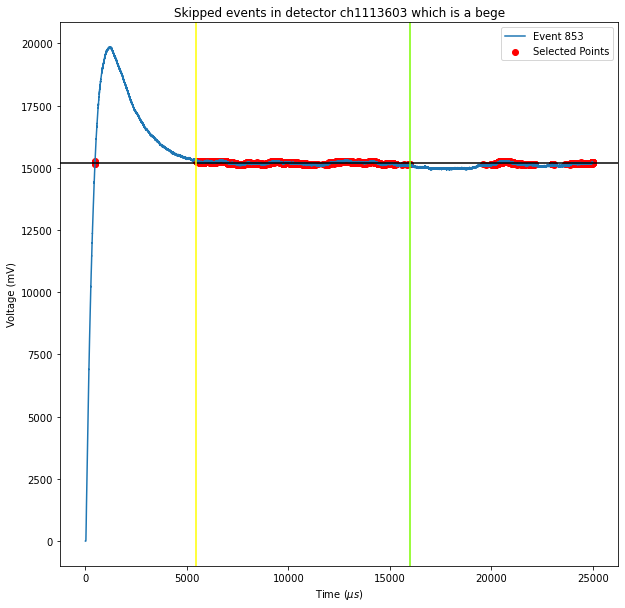

recovery rate -0.7999999999992724s
DISCHARGE
Maximum difference: 22969.600000000002, 24789.600000000002
Next maximum difference: 24790.4, 24798.4


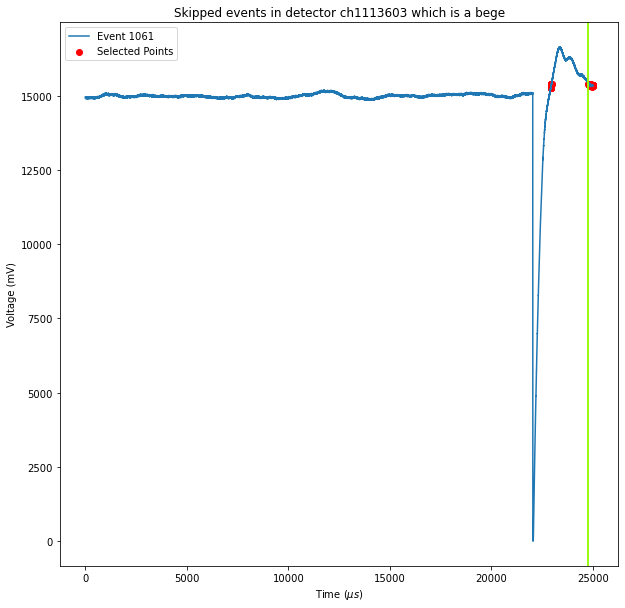

recovery rate 12065.6s
MICRODISCHARGE
Maximum difference: 1859.2, 12065.6
Next Maximum difference: 12133.6, 20243.2


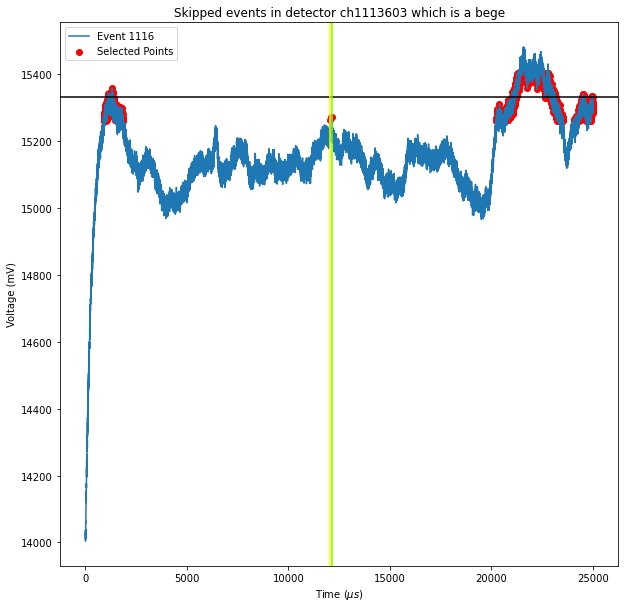

recovery rate 7816.8s
MICRODISCHARGE
Maximum difference: 1258.4, 7816.8
Next Maximum difference: 21001.600000000002, 22288.0


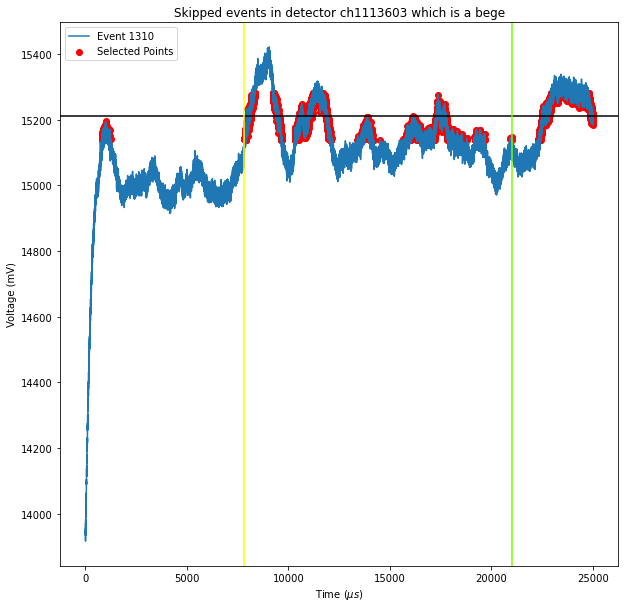

recovery rate 5195.200000000001s
DISCHARGE
Maximum difference: 400.8, 5195.200000000001
Next maximum difference: 5628.0, 6130.400000000001


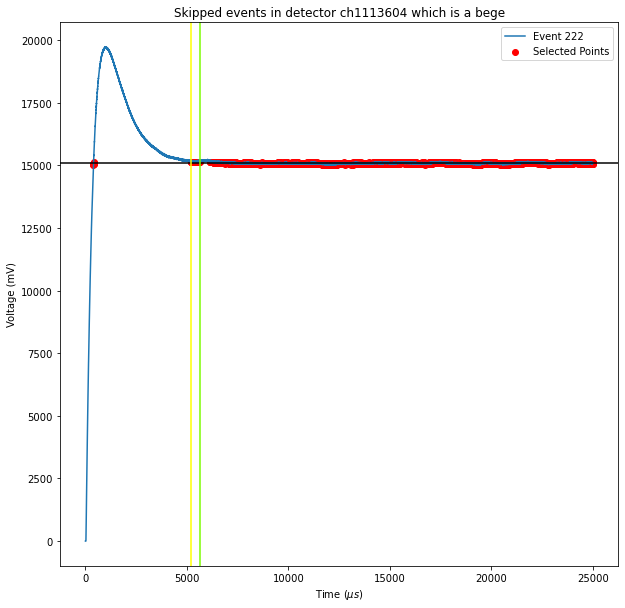

recovery rate -575.1999999999998s
MICRODISCHARGE
Maximum difference: 2536.8, 3195.2000000000003
Next Maximum difference: 3770.4, 4346.400000000001


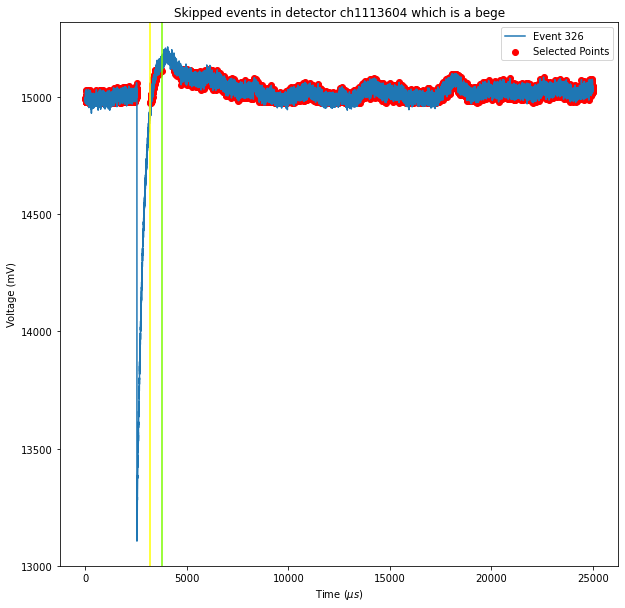

recovery rate 4859.2s
DISCHARGE
Maximum difference: 472.8, 4859.2
Next maximum difference: 18600.0, 18997.600000000002


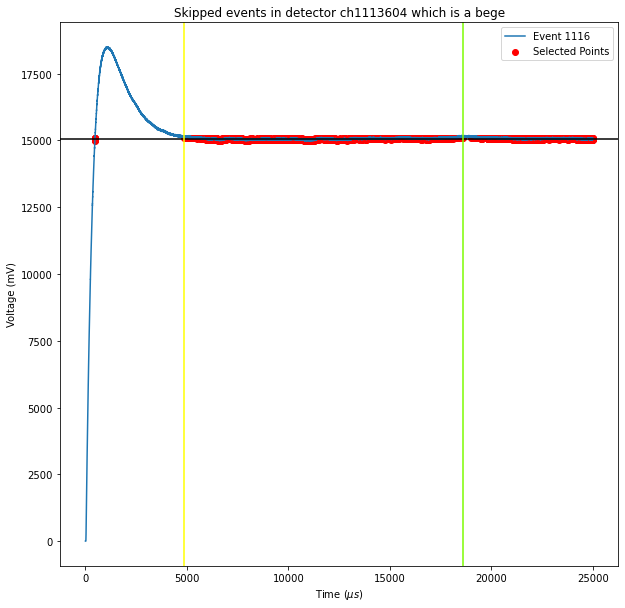

recovery rate 4027.2000000000003s
DISCHARGE
Maximum difference: 455.20000000000005, 4027.2000000000003
Next maximum difference: 5185.6, 6758.400000000001


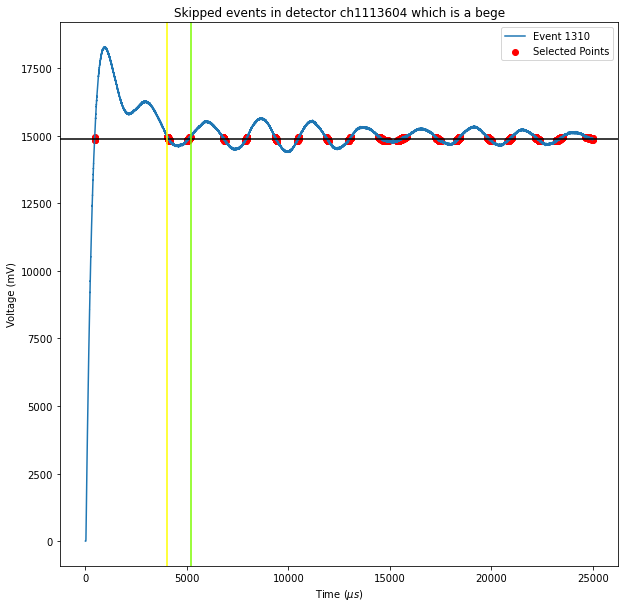

recovery rate 3465.5999999999985s
MICRODISCHARGE
Maximum difference: 16694.4, 19376.0
Next Maximum difference: 15910.400000000001, 16642.4


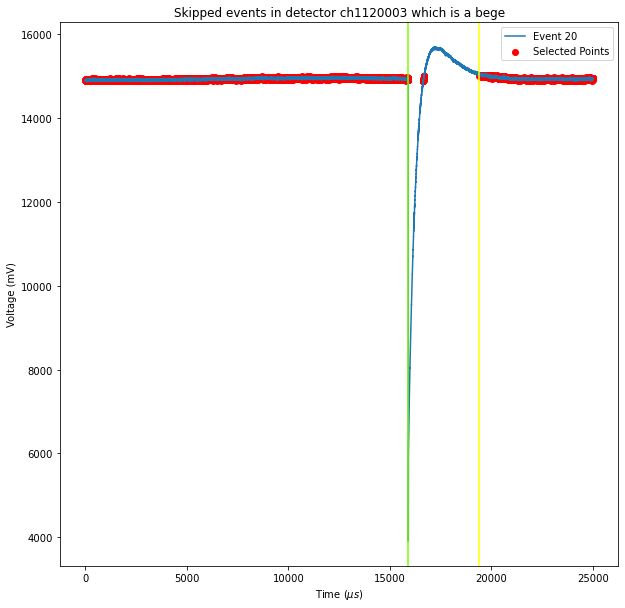

recovery rate 4740.8s
DISCHARGE
Maximum difference: 492.8, 4740.8
Next maximum difference: 5004.8, 5078.400000000001


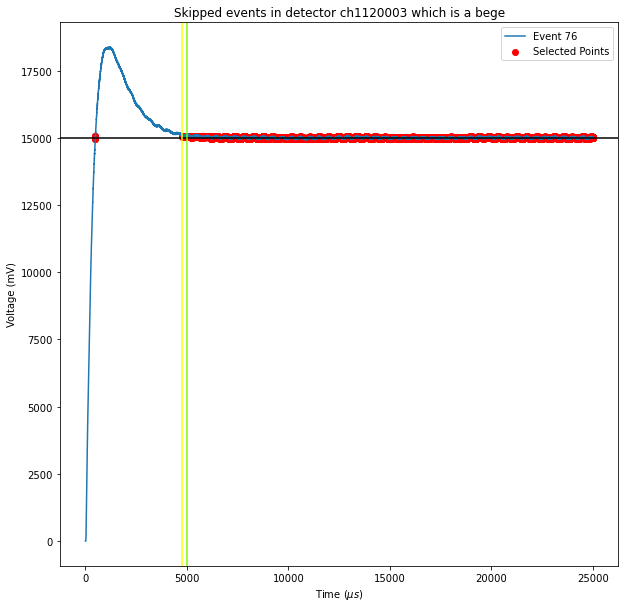

recovery rate 5440.0s
DISCHARGE
Maximum difference: 254.4, 5440.0
Next maximum difference: 5756.0, 6103.200000000001


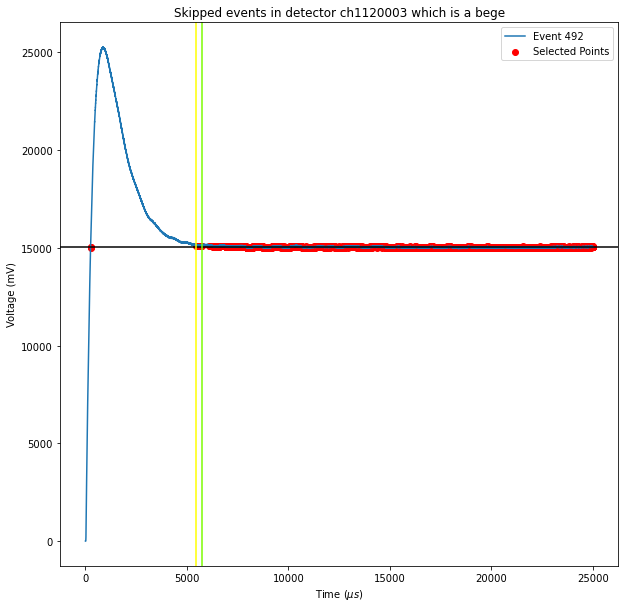

recovery rate 445.59999999999854s
MICRODISCHARGE
Maximum difference: 24217.600000000002, 24231.2
Next Maximum difference: 23785.600000000002, 23798.4


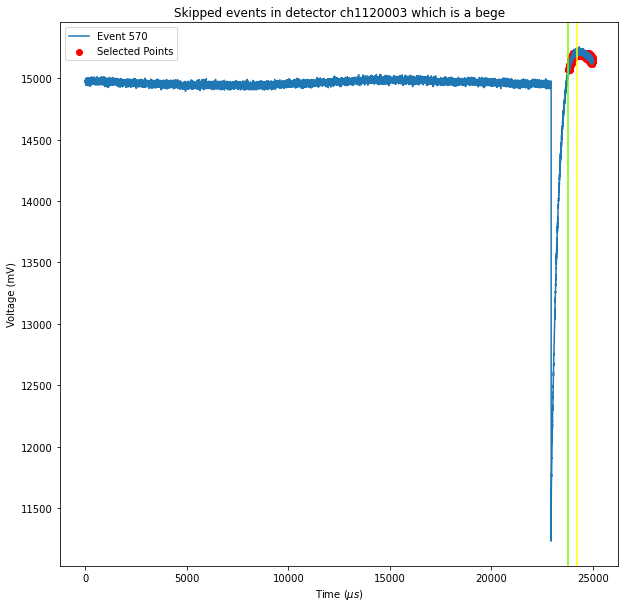

recovery rate 2180.0s
MICRODISCHARGE
Maximum difference: 776.0, 2180.0
Next Maximum difference: 2180.0, 2216.8


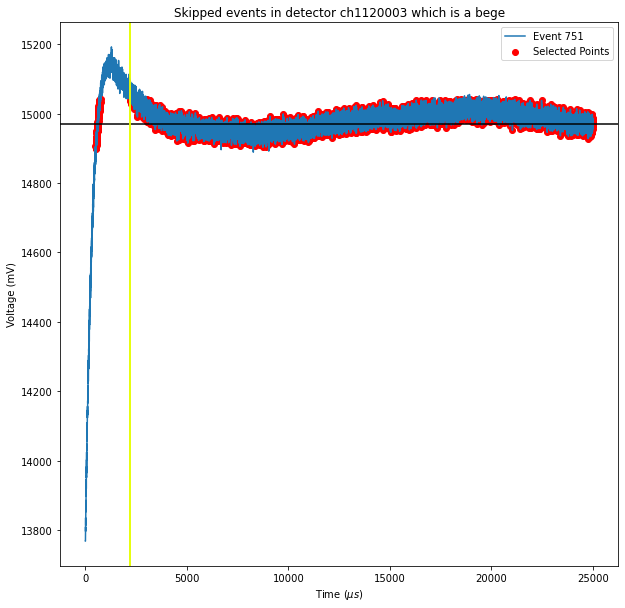

recovery rate 2815.2000000000007s
MICRODISCHARGE
Maximum difference: 18916.8, 20694.4
Next Maximum difference: 17879.2, 18679.2


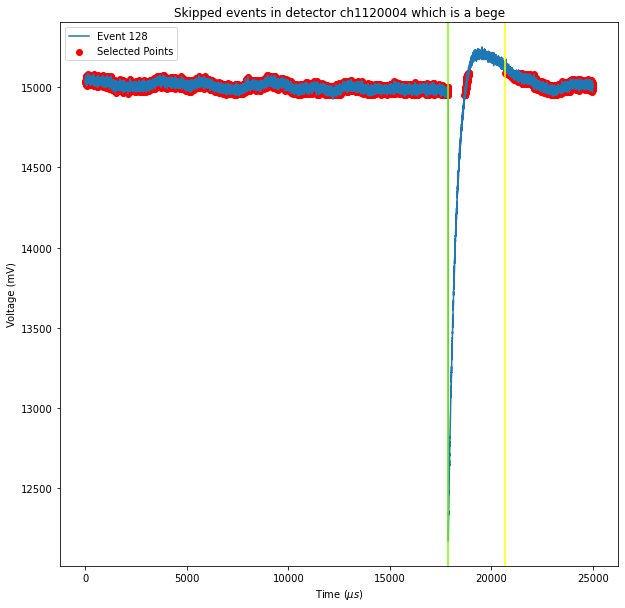

recovery rate -76.80000000000007s
MICRODISCHARGE
Maximum difference: 637.6, 728.0
Next Maximum difference: 804.8000000000001, 880.8000000000001


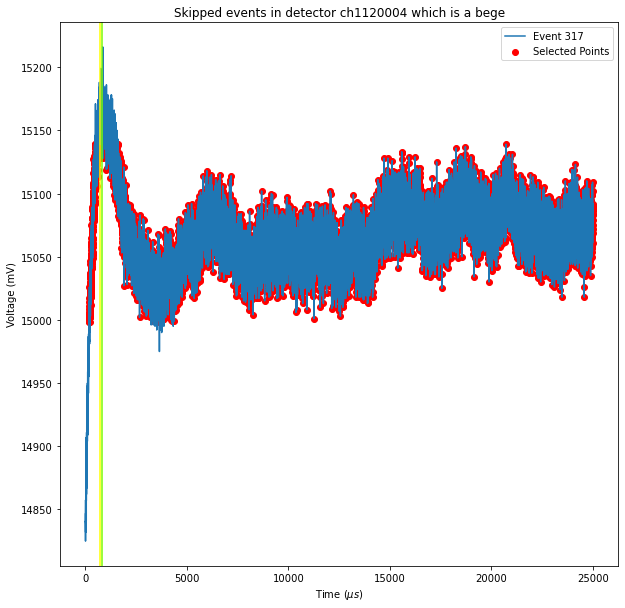

recovery rate -590.4000000000005s
MICRODISCHARGE
Maximum difference: 6626.400000000001, 7284.8
Next Maximum difference: 7875.200000000001, 8276.0


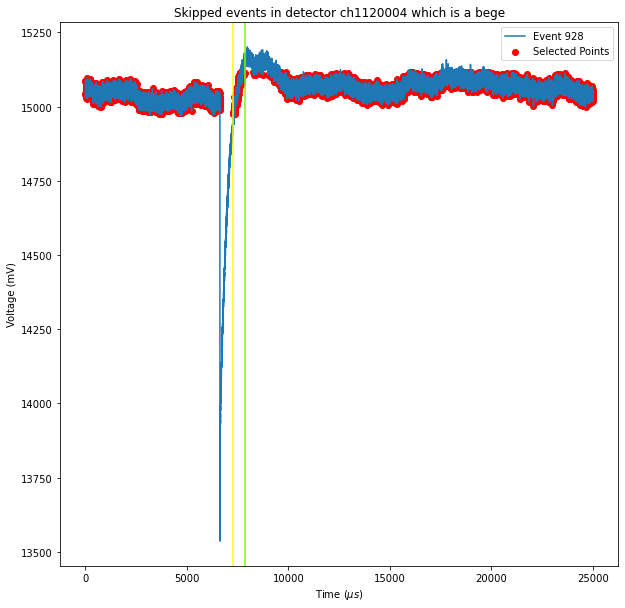

recovery rate 352.8000000000002s
MICRODISCHARGE
Maximum difference: 4503.2, 4505.6
Next Maximum difference: 4152.8, 4154.400000000001


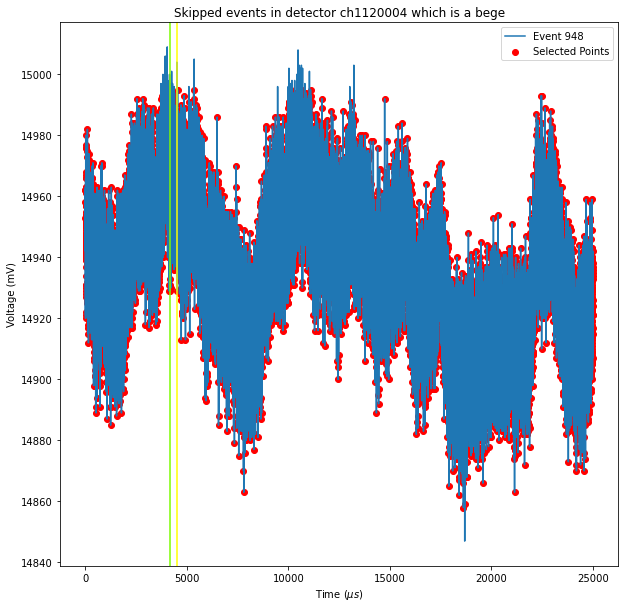

recovery rate 139.20000000000073s
MICRODISCHARGE
Maximum difference: 17644.8, 17647.2
Next Maximum difference: 17508.0, 17509.600000000002


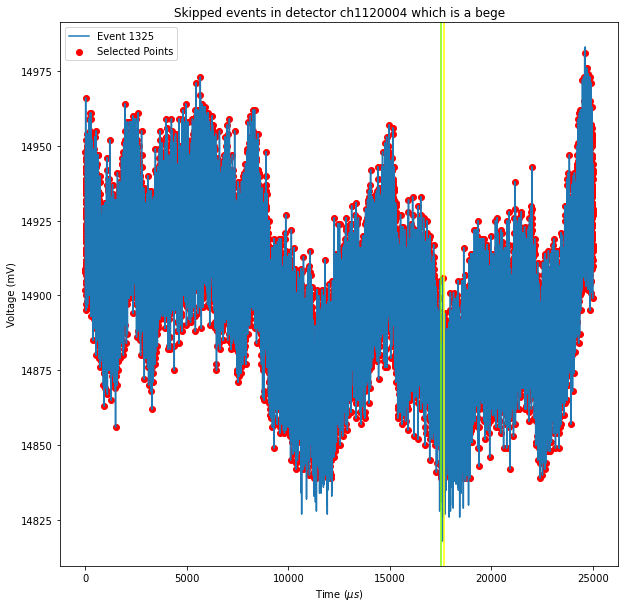

recovery rate -552.0s
MICRODISCHARGE
Maximum difference: 10752.0, 11471.2
Next Maximum difference: 12023.2, 12472.800000000001


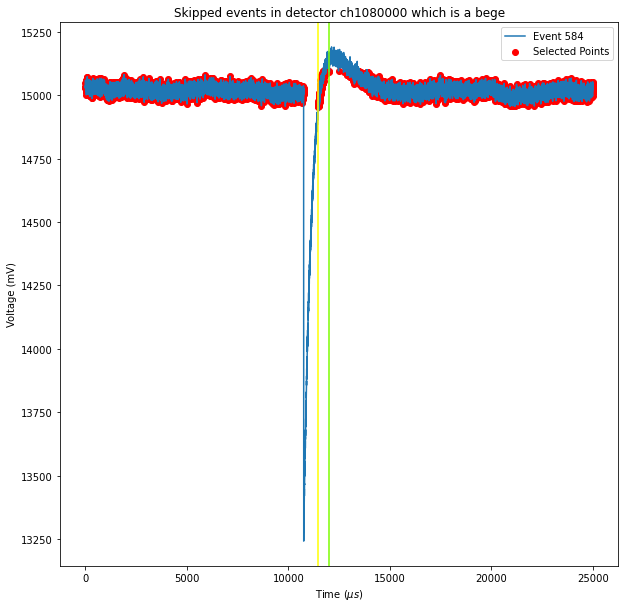

recovery rate 5143.200000000001s
DISCHARGE
Maximum difference: 401.6, 5143.200000000001
Next maximum difference: 5176.8, 5235.200000000001


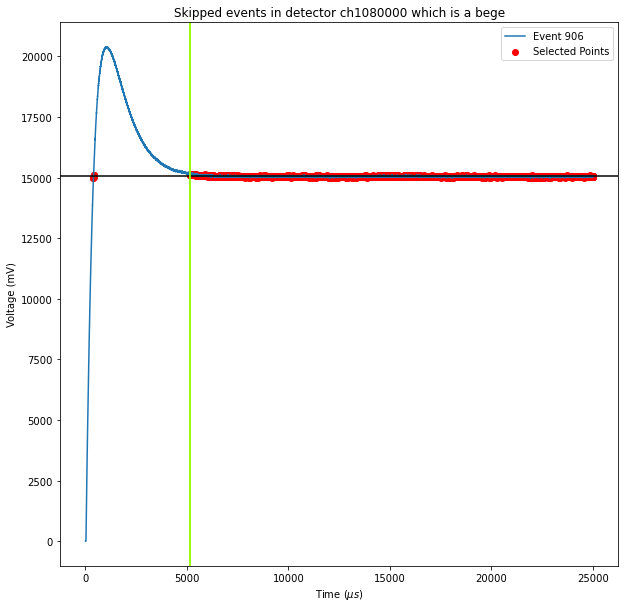

recovery rate 4728.8s
DISCHARGE
Maximum difference: 536.8000000000001, 4728.8
Next maximum difference: 4790.400000000001, 4875.2


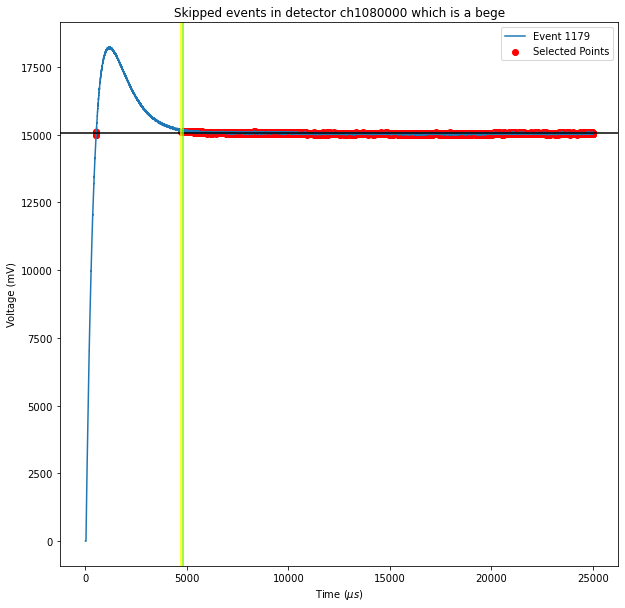

recovery rate 2138.4000000000015s
MICRODISCHARGE
Maximum difference: 19539.2, 20556.800000000003
Next Maximum difference: 18418.4, 19079.2


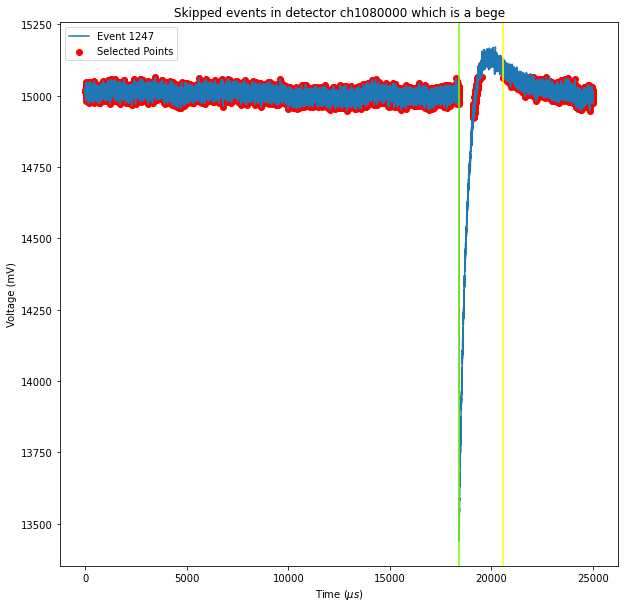

recovery rate 4724.8s
DISCHARGE
Maximum difference: 544.0, 4724.8
Next maximum difference: 5342.400000000001, 5504.0


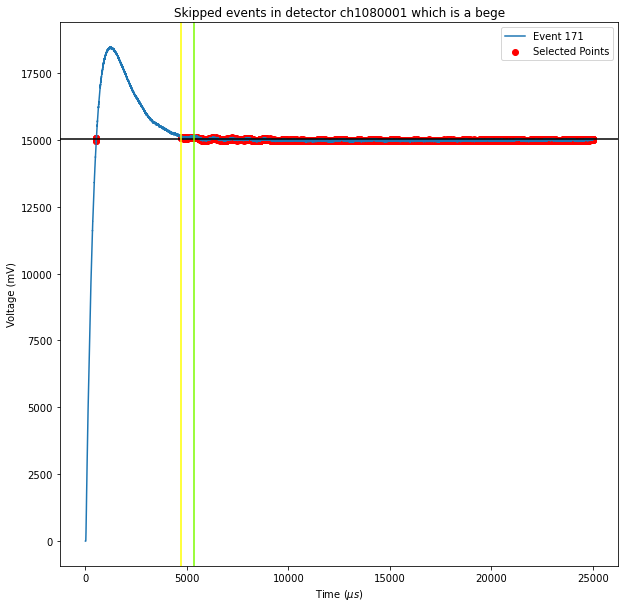

recovery rate 5765.6s
DISCHARGE
Maximum difference: 510.40000000000003, 5765.6
Next maximum difference: 8748.0, 8760.800000000001


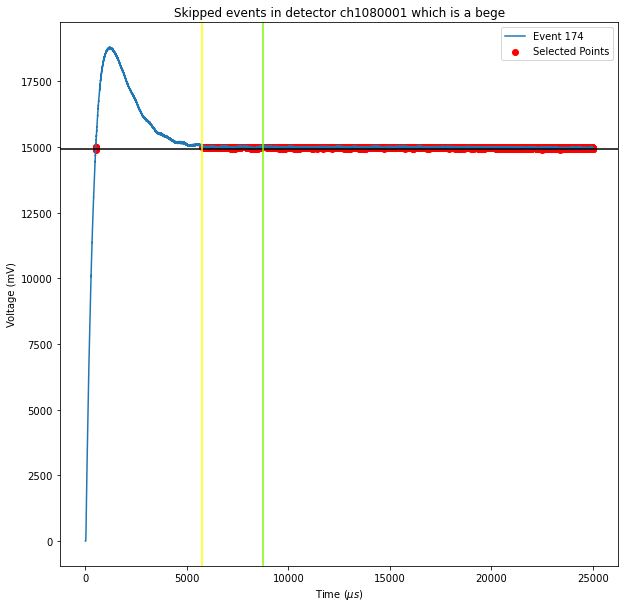

recovery rate 5686.400000000001s
DISCHARGE
Maximum difference: 504.0, 5686.400000000001
Next maximum difference: 5704.0, 5720.0


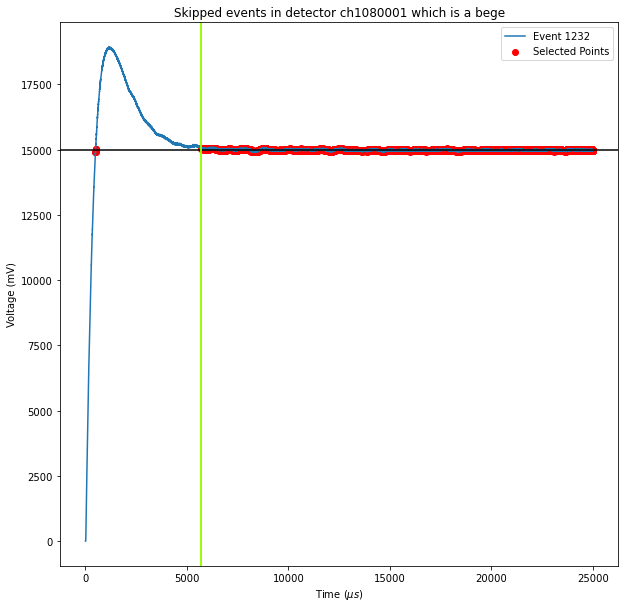

recovery rate 20344.0s
MICRODISCHARGE
Maximum difference: 4012.0, 21615.2
Next Maximum difference: 1271.2, 2056.0


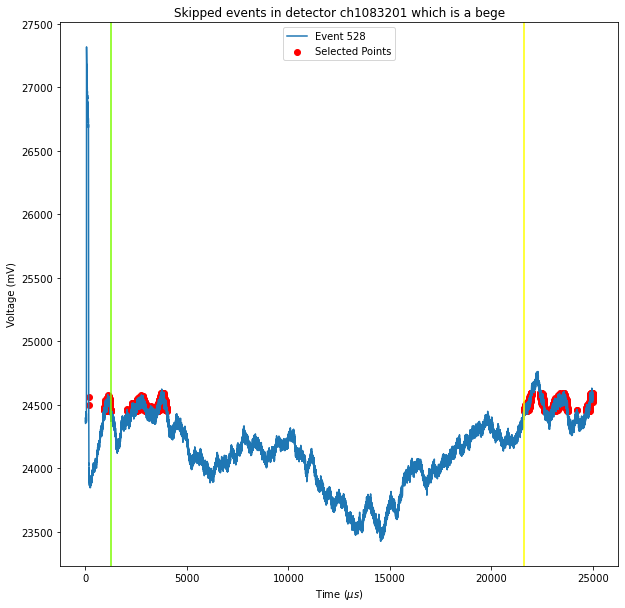

recovery rate 18809.6s
MICRODISCHARGE
Maximum difference: 14872.0, 24560.0
Next Maximum difference: 5750.400000000001, 14850.400000000001


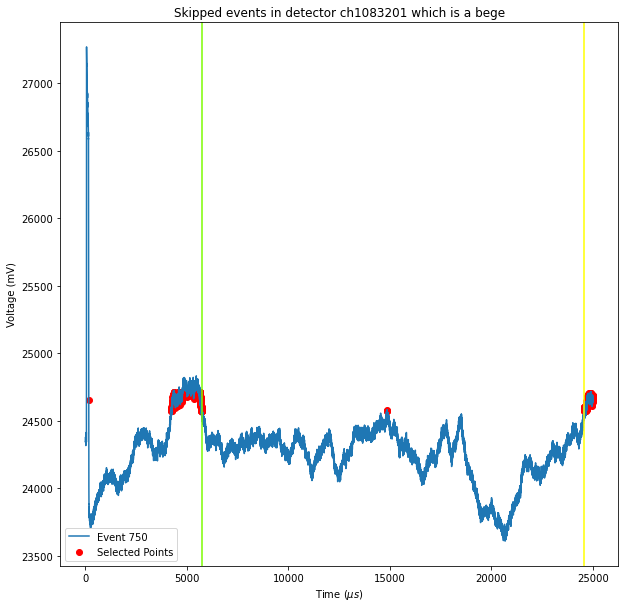

recovery rate 18760.0s
MICRODISCHARGE
Maximum difference: 15276.800000000001, 20348.0
Next Maximum difference: 1588.0, 6004.8


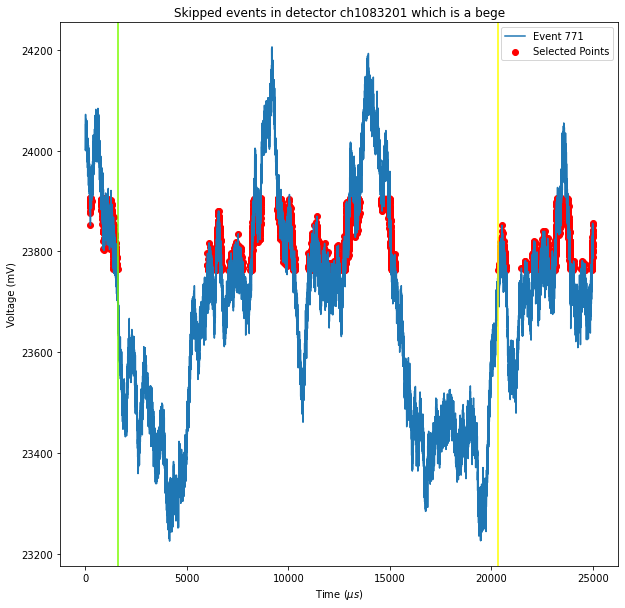

recovery rate 22660.800000000003s
MICRODISCHARGE
Maximum difference: 16319.2, 23488.800000000003
Next Maximum difference: 828.0, 6775.200000000001


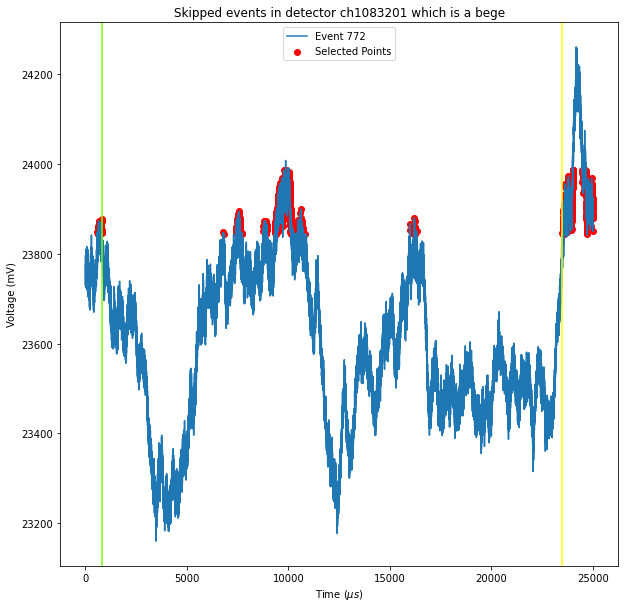

recovery rate 16885.6s
MICRODISCHARGE
Maximum difference: 19183.2, 24664.0
Next Maximum difference: 7778.400000000001, 11280.0


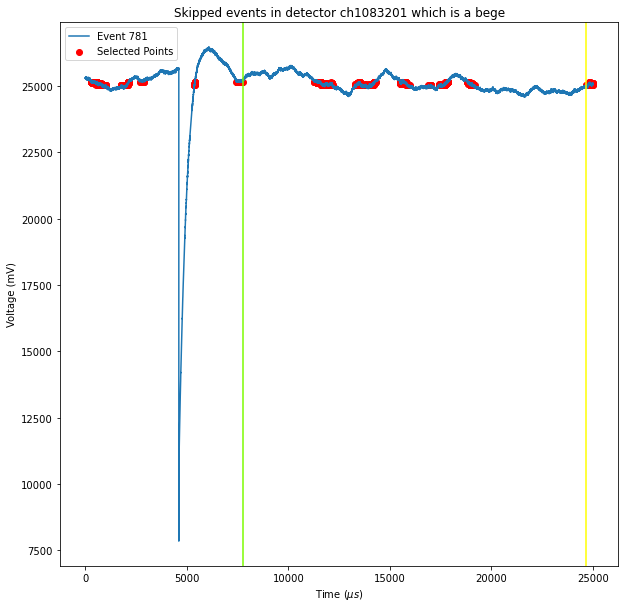

recovery rate 6179.999999999998s
MICRODISCHARGE
Maximum difference: 15901.6, 18404.8
Next Maximum difference: 12224.800000000001, 14294.400000000001


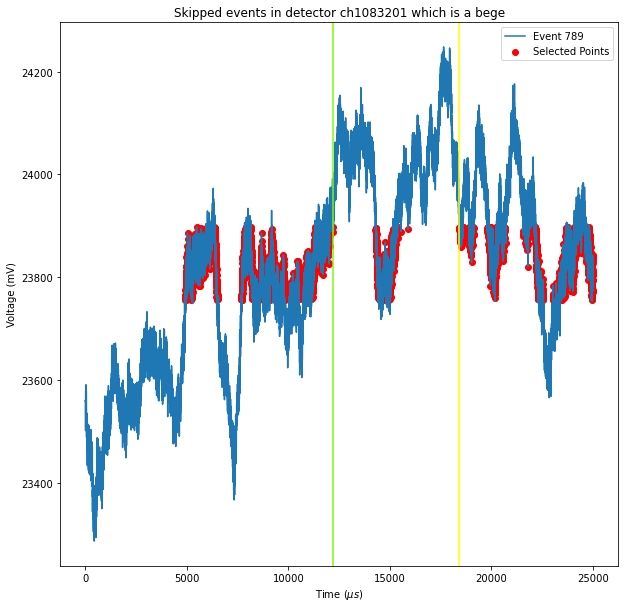

recovery rate 21602.4s
MICRODISCHARGE
Maximum difference: 16018.400000000001, 24332.0
Next Maximum difference: 2729.6000000000004, 4886.400000000001


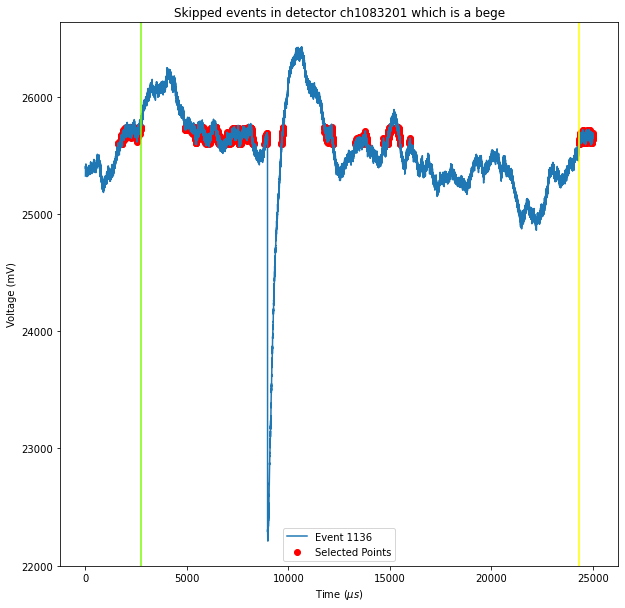

recovery rate 21588.0s
MICRODISCHARGE
Maximum difference: 5717.6, 24726.4
Next Maximum difference: 3138.4, 4990.400000000001


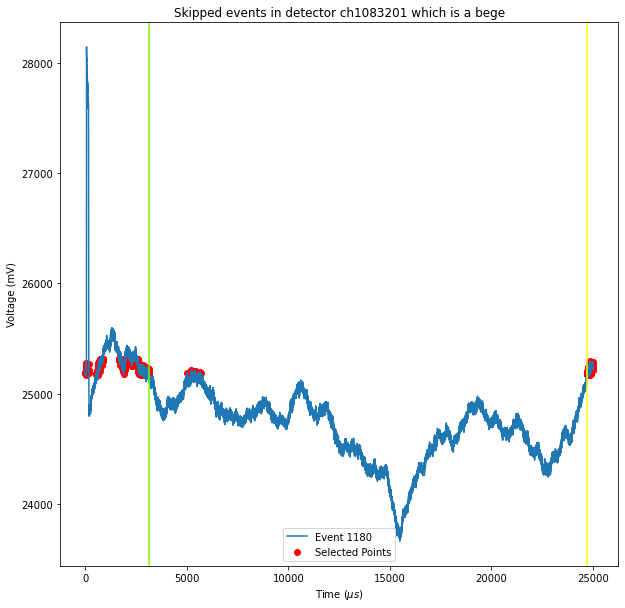

recovery rate -2692.0s
MICRODISCHARGE
Maximum difference: 154.4, 19898.4
Next Maximum difference: 22590.4, 24359.2


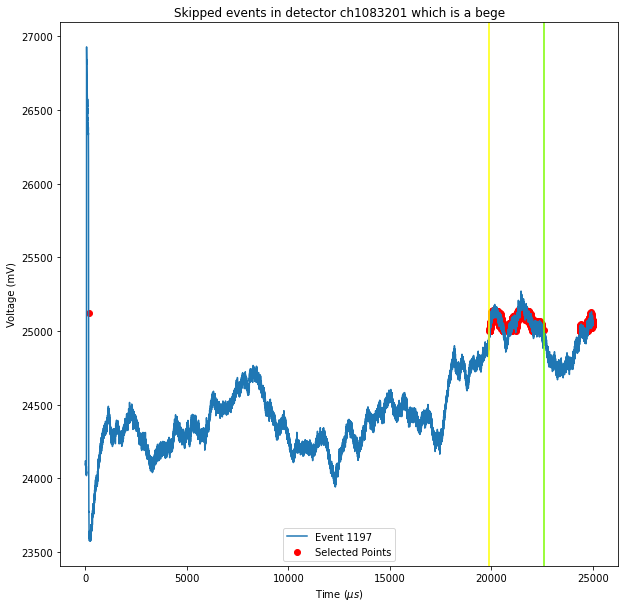

recovery rate -78.40000000000146s
MICRODISCHARGE
Maximum difference: 153.60000000000002, 24671.2
Next Maximum difference: 24749.600000000002, 24763.2


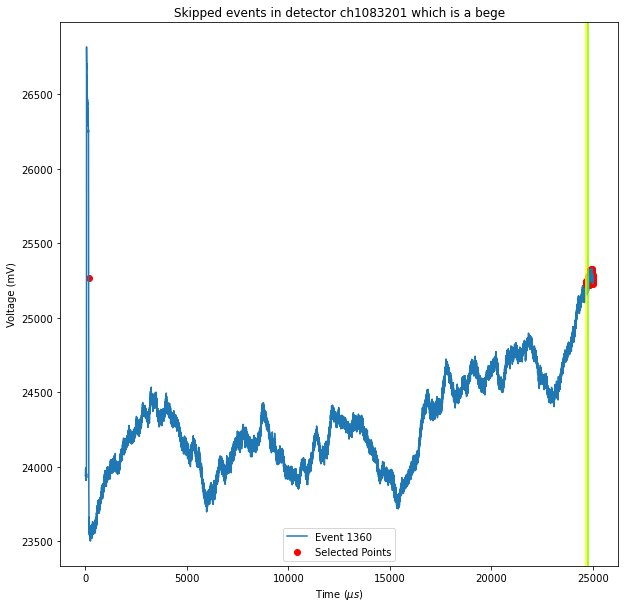

recovery rate 841.6s
MICRODISCHARGE
Maximum difference: 164.8, 891.2
Next Maximum difference: 49.6, 162.4


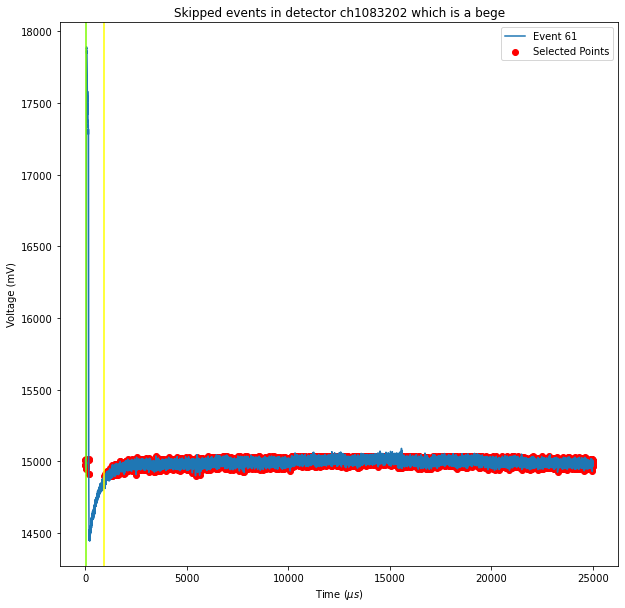

recovery rate 5004.0s
DISCHARGE
Maximum difference: 536.8000000000001, 5004.0
Next maximum difference: 5131.200000000001, 5160.8


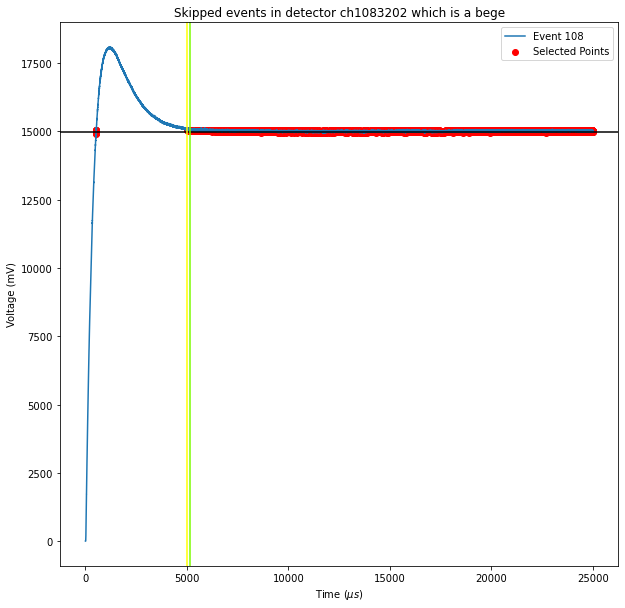

recovery rate 2484.0s
MICRODISCHARGE
Maximum difference: 460.8, 2484.0
Next Maximum difference: 2484.0, 2544.8


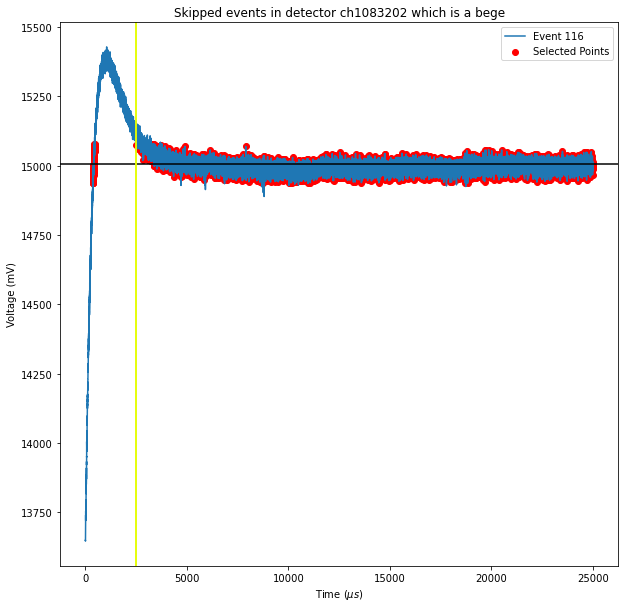

recovery rate 1003.1999999999999s
MICRODISCHARGE
Maximum difference: 163.20000000000002, 1052.8
Next Maximum difference: 49.6, 162.4


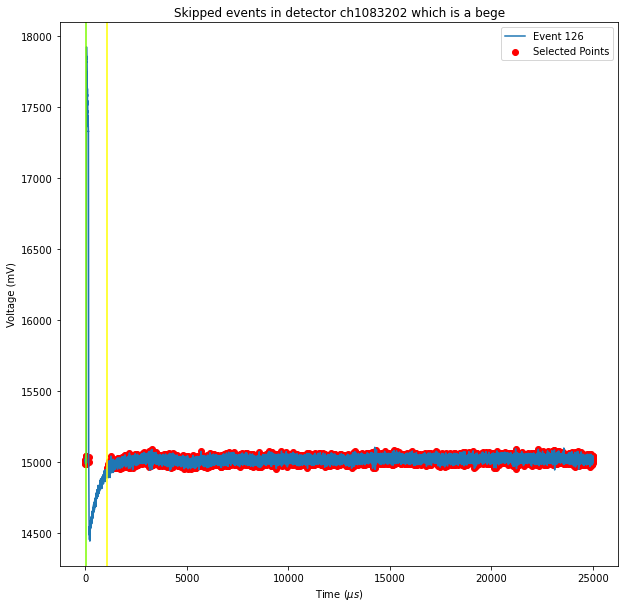

recovery rate 957.6s
MICRODISCHARGE
Maximum difference: 164.0, 1007.2
Next Maximum difference: 49.6, 162.4


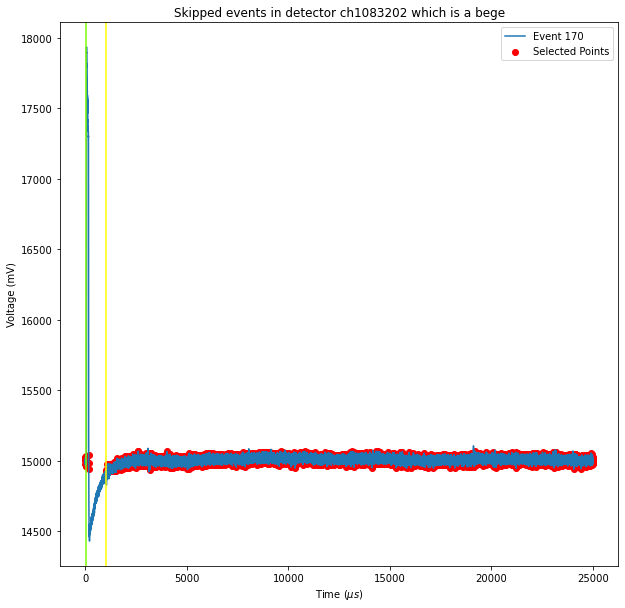

recovery rate 1086.4s
MICRODISCHARGE
Maximum difference: 163.20000000000002, 1136.0
Next Maximum difference: 49.6, 161.60000000000002


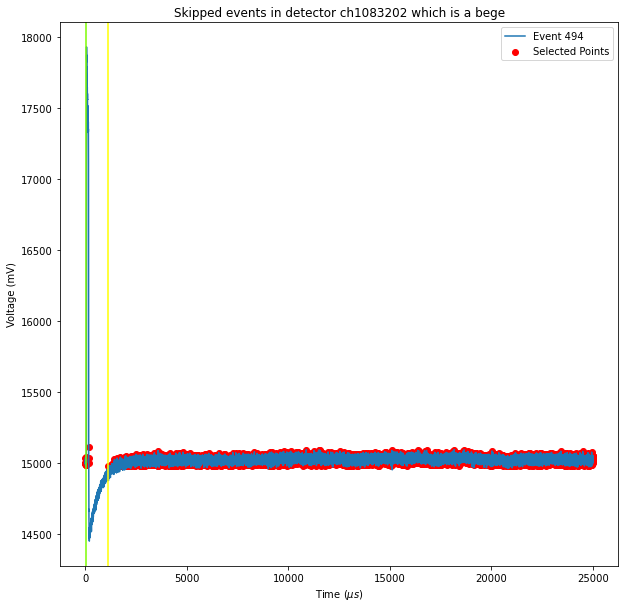

recovery rate 912.0s
MICRODISCHARGE
Maximum difference: 164.0, 961.6
Next Maximum difference: 49.6, 162.4


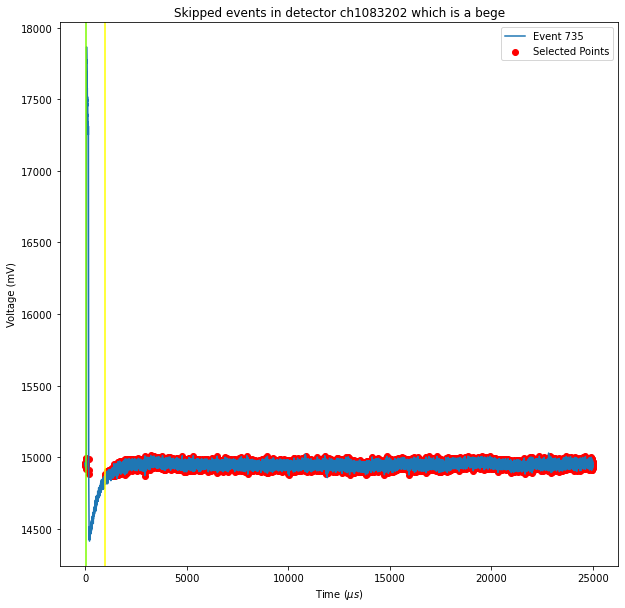

recovery rate -5589.6s
MICRODISCHARGE
Maximum difference: 163.20000000000002, 1118.4
Next Maximum difference: 6708.0, 7252.8


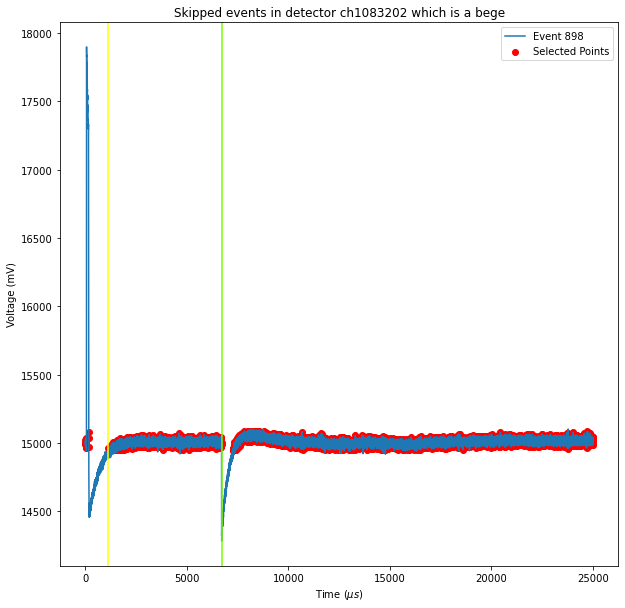

recovery rate 0.0s
MICRODISCHARGE
Maximum difference: 7288.8, 7292.0
Next Maximum difference: 7292.0, 7293.6


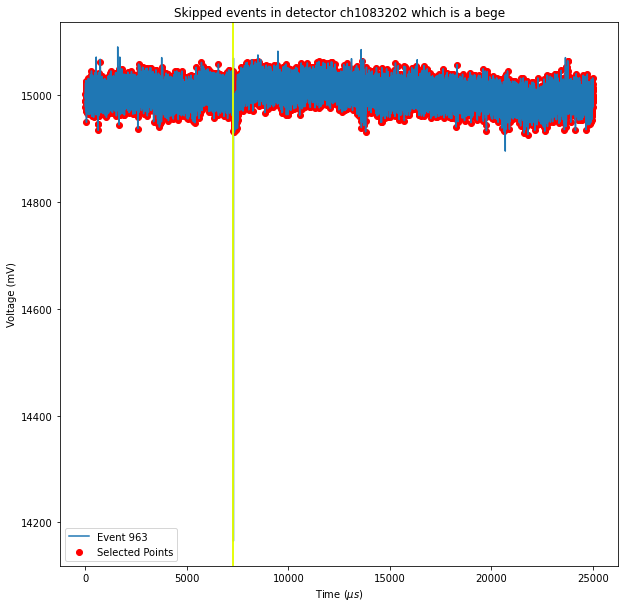

recovery rate -167.20000000000005s
MICRODISCHARGE
Maximum difference: 162.4, 1981.6000000000001
Next Maximum difference: 2148.8, 2411.2000000000003


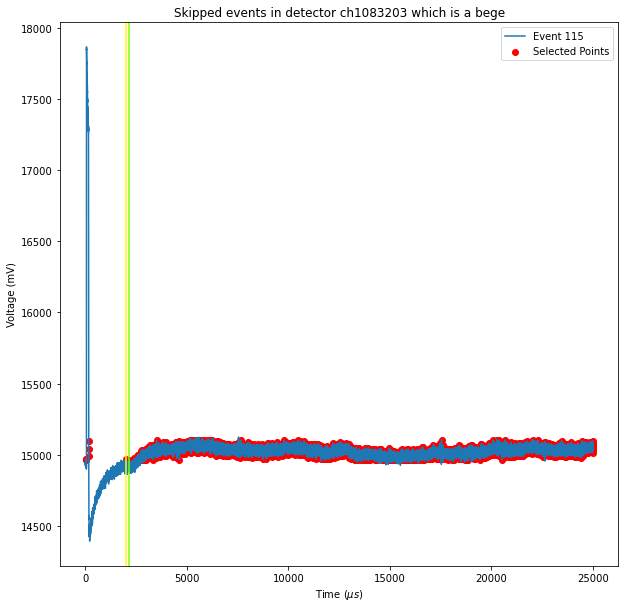

recovery rate 4997.6s
DISCHARGE
Maximum difference: 445.6, 4997.6
Next maximum difference: 5072.0, 5106.400000000001


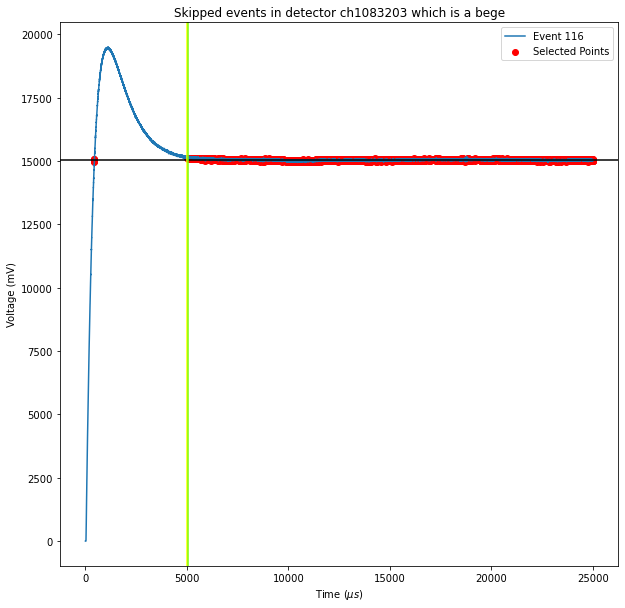

recovery rate 1280.0000000000002s
MICRODISCHARGE
Maximum difference: 164.0, 1329.6000000000001
Next Maximum difference: 49.6, 162.4


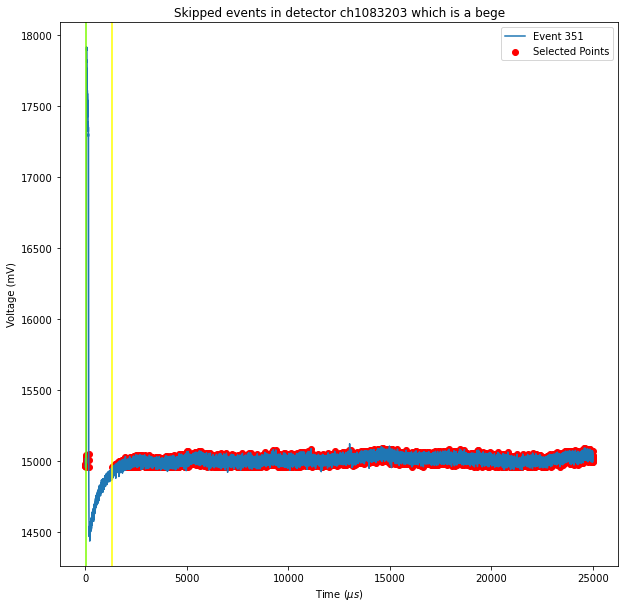

recovery rate 1138.4s
MICRODISCHARGE
Maximum difference: 163.20000000000002, 1188.0
Next Maximum difference: 49.6, 161.60000000000002


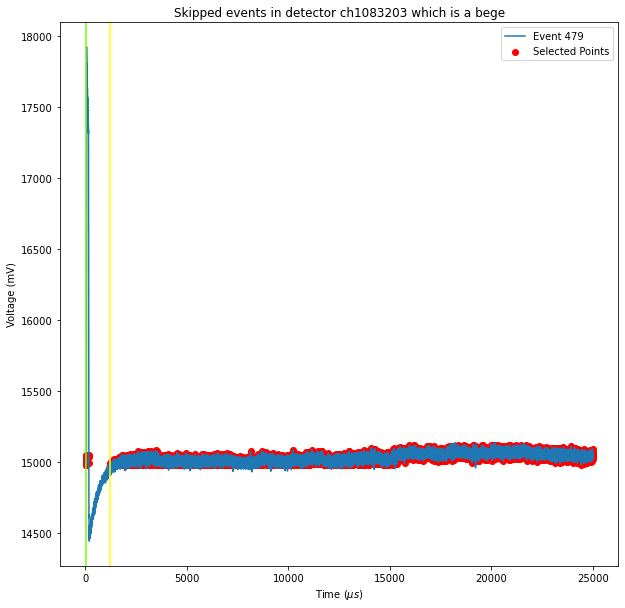

recovery rate 924.8000000000001s
MICRODISCHARGE
Maximum difference: 164.8, 974.4000000000001
Next Maximum difference: 49.6, 163.20000000000002


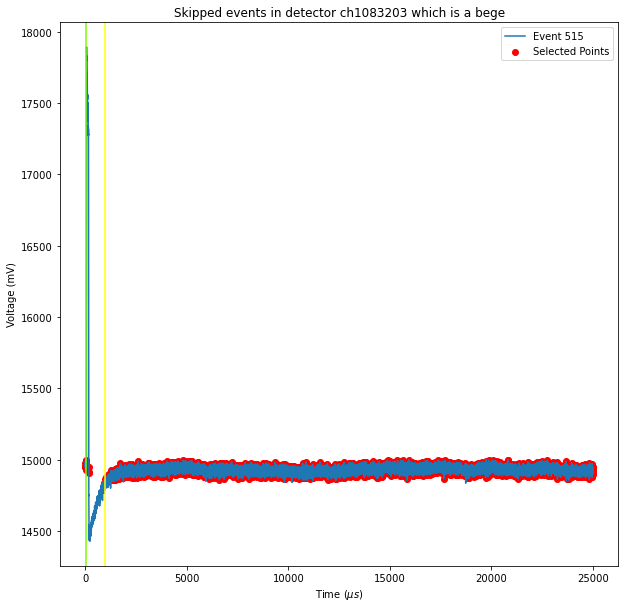

recovery rate 2820.7999999999993s
MICRODISCHARGE
Maximum difference: 16772.8, 18708.8
Next Maximum difference: 15888.0, 16559.2


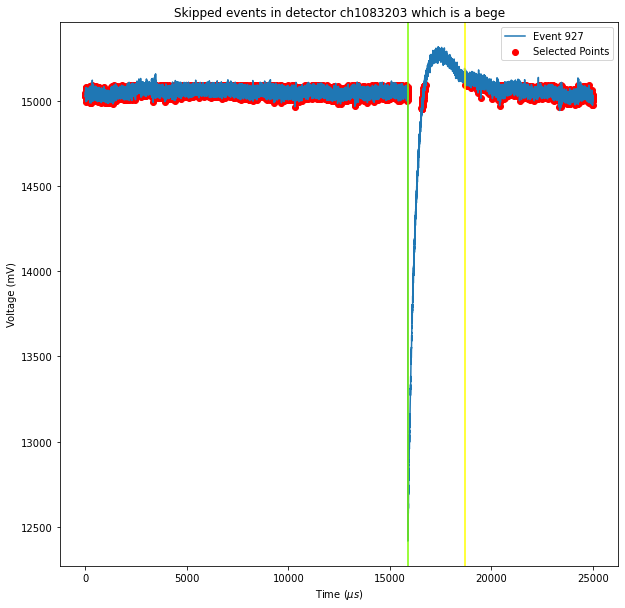

recovery rate -908.7999999999993s
MICRODISCHARGE
Maximum difference: 7288.8, 7293.6
Next Maximum difference: 8202.4, 8205.6


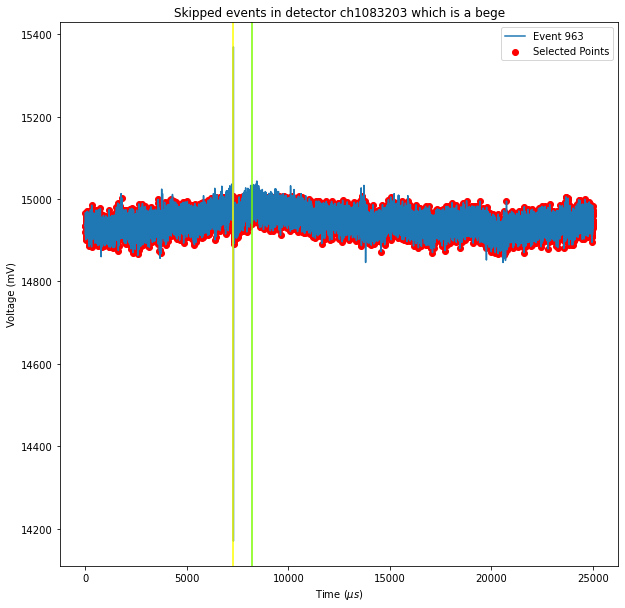

recovery rate 1035.2s
MICRODISCHARGE
Maximum difference: 163.20000000000002, 1084.8
Next Maximum difference: 49.6, 162.4


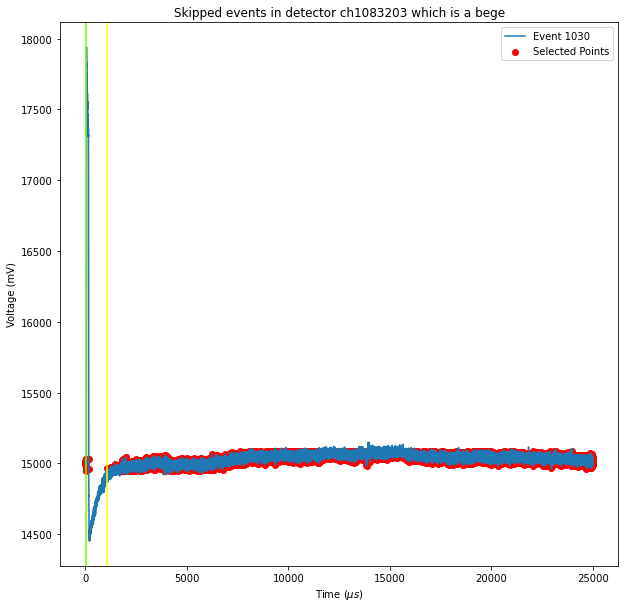

recovery rate 861.6s
MICRODISCHARGE
Maximum difference: 164.8, 911.2
Next Maximum difference: 49.6, 163.20000000000002


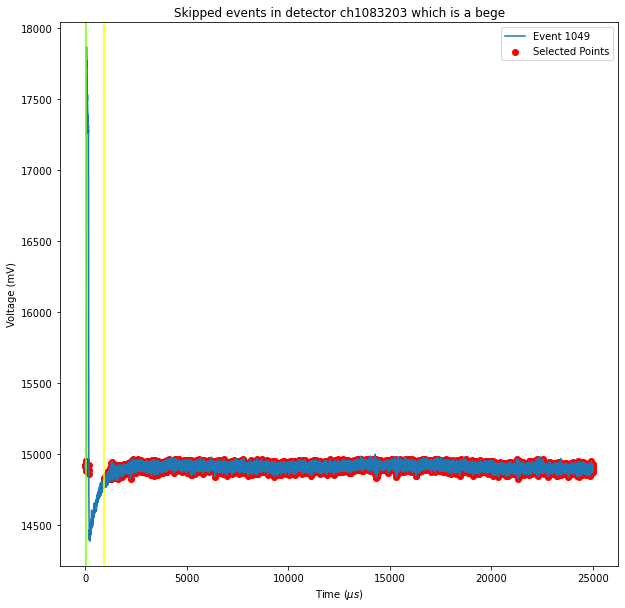

recovery rate -6.399999999999636s
MICRODISCHARGE
Maximum difference: 8597.6, 9116.800000000001
Next Maximum difference: 9123.2, 9164.0


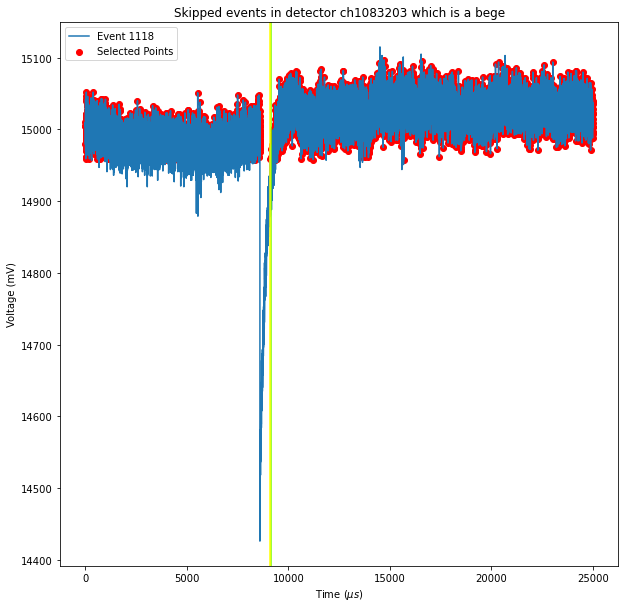

recovery rate 910.4s
MICRODISCHARGE
Maximum difference: 164.0, 960.0
Next Maximum difference: 49.6, 162.4


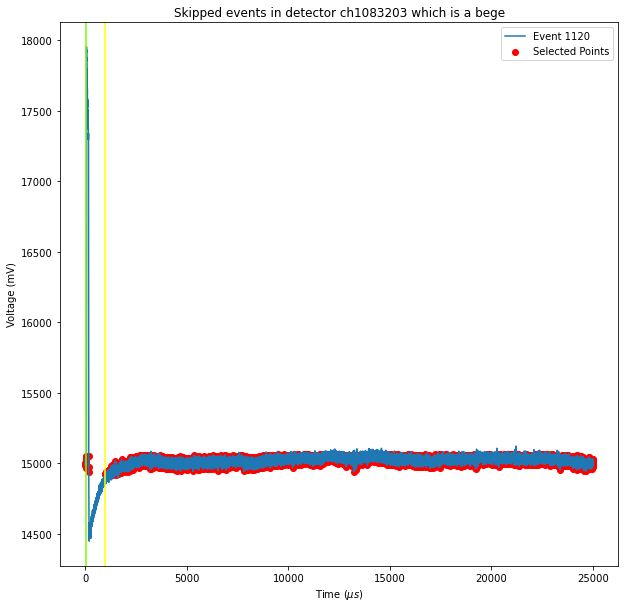

recovery rate -764.8000000000011s
MICRODISCHARGE
Maximum difference: 12612.800000000001, 13385.6
Next Maximum difference: 14150.400000000001, 14360.0


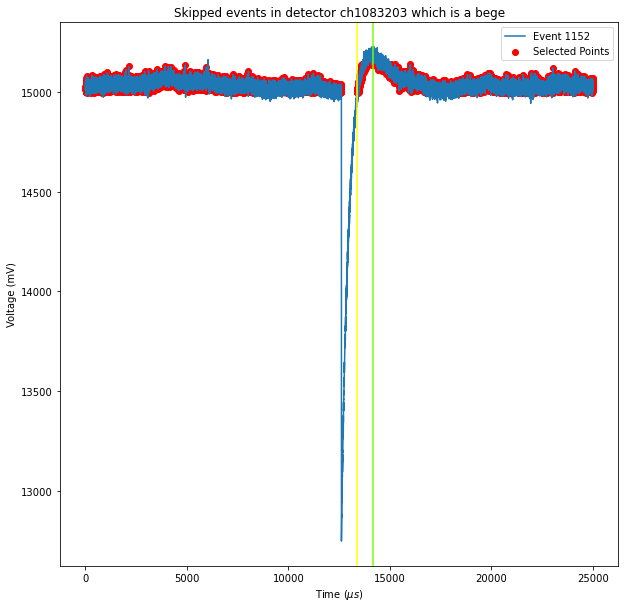

recovery rate 751.2s
MICRODISCHARGE
Maximum difference: 164.0, 800.8000000000001
Next Maximum difference: 49.6, 162.4


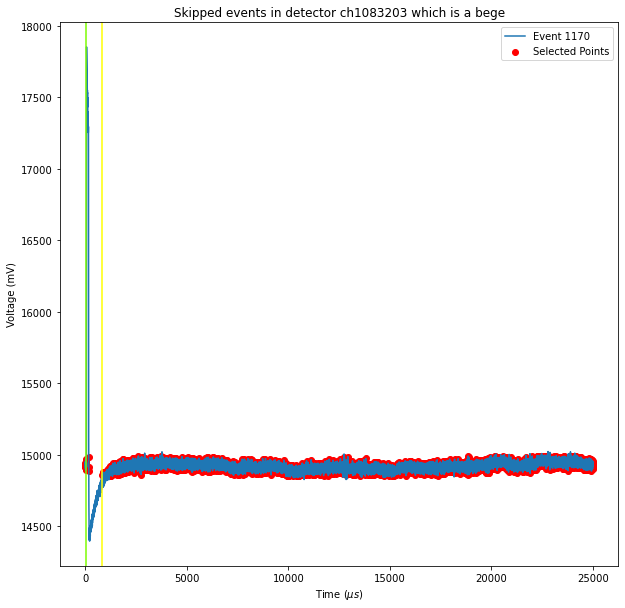

recovery rate -86.39999999999986s
MICRODISCHARGE
Maximum difference: 163.20000000000002, 1185.6000000000001
Next Maximum difference: 1272.0, 1386.4


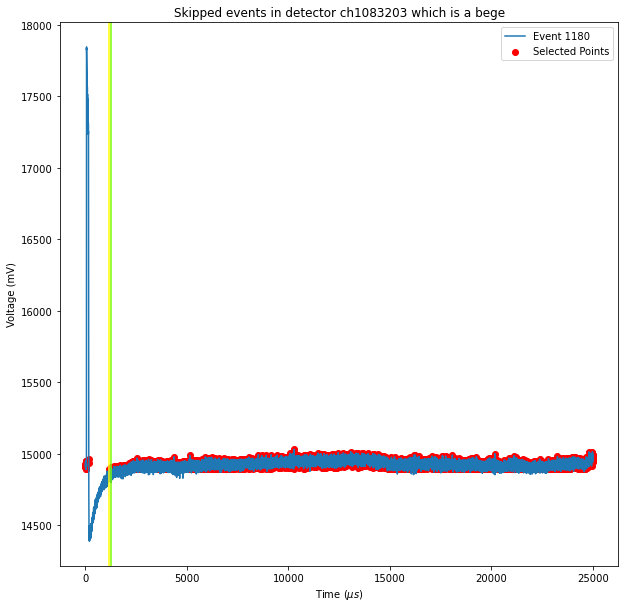

recovery rate -8.0s
MICRODISCHARGE
Maximum difference: 916.0, 1452.8000000000002
Next Maximum difference: 1460.8000000000002, 1469.6000000000001


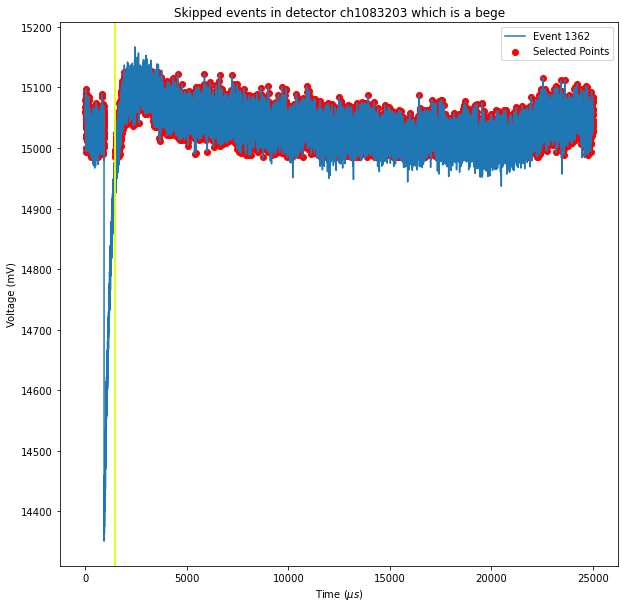

recovery rate -9373.6s
MICRODISCHARGE
Maximum difference: 8643.2, 8646.4
Next Maximum difference: 18020.0, 18021.600000000002


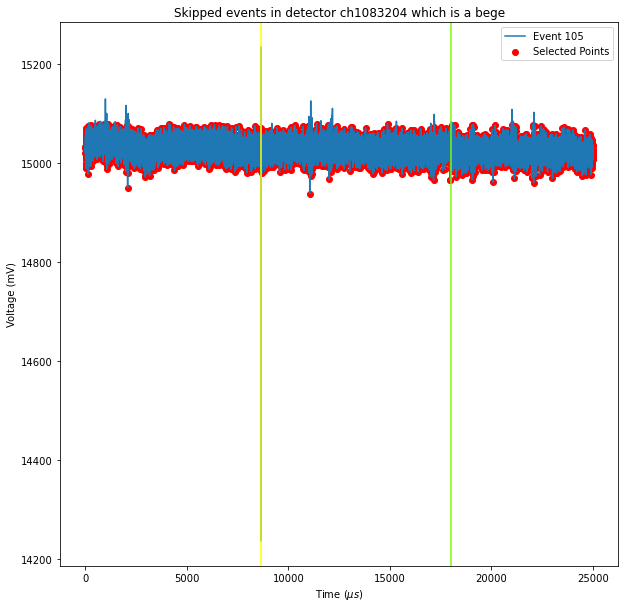

recovery rate -12468.0s
MICRODISCHARGE
Maximum difference: 7288.8, 7292.0
Next Maximum difference: 19760.0, 19761.600000000002


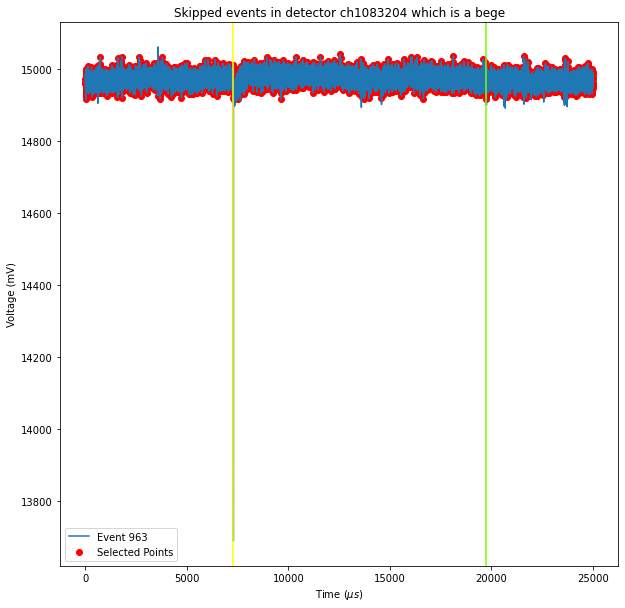

recovery rate -7965.6s
MICRODISCHARGE
Maximum difference: 8643.2, 8646.4
Next Maximum difference: 16612.0, 16613.600000000002


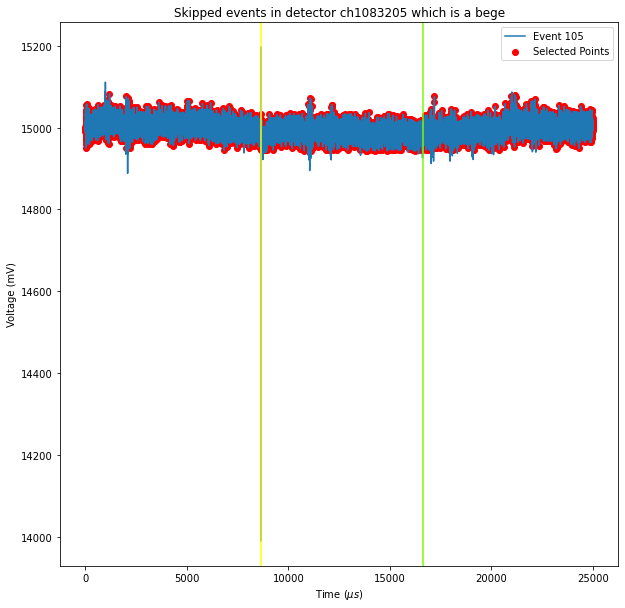

recovery rate 2958.4s
MICRODISCHARGE
Maximum difference: 392.0, 2958.4
Next Maximum difference: 3007.2000000000003, 3104.0


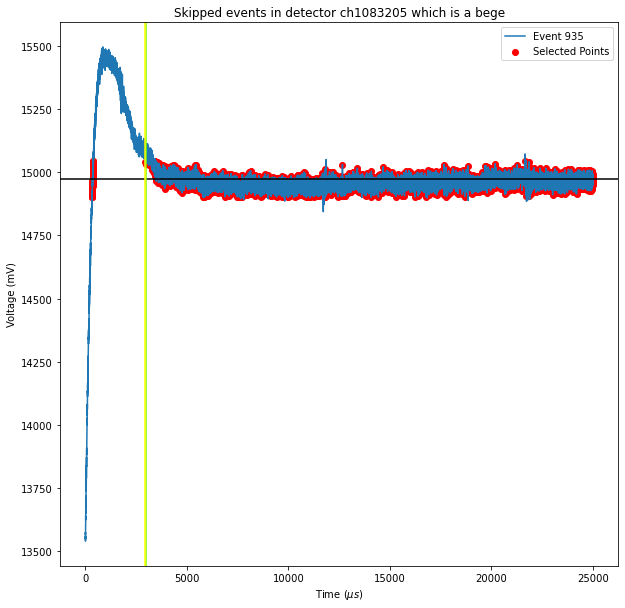

recovery rate 0.0s
MICRODISCHARGE
Maximum difference: 7298.400000000001, 7306.400000000001
Next Maximum difference: 7306.400000000001, 7312.8


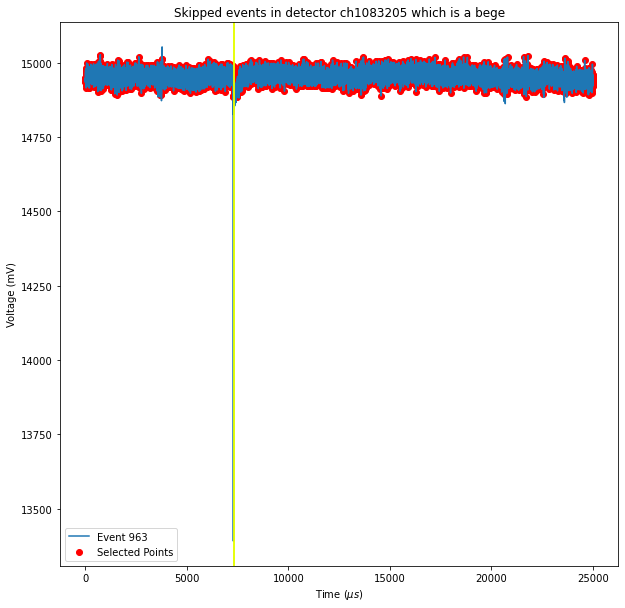

recovery rate 0.0s
MICRODISCHARGE
Maximum difference: 2020.8000000000002, 2371.2000000000003
Next Maximum difference: 2371.2000000000003, 2384.0


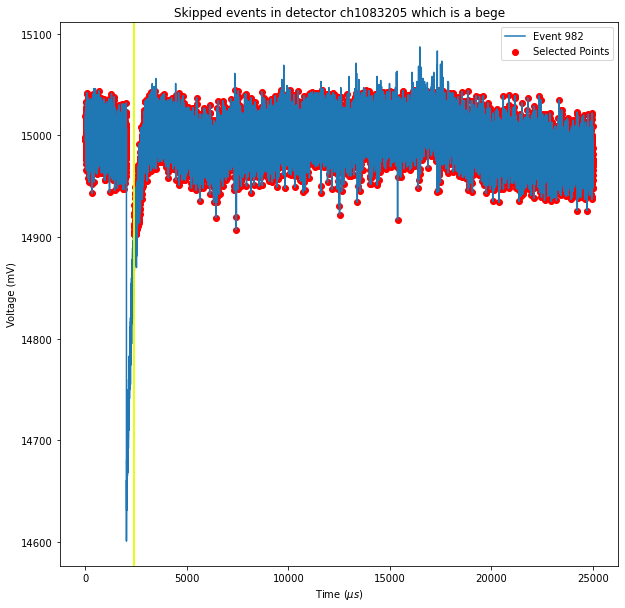

recovery rate 3264.8000000000006s
MICRODISCHARGE
Maximum difference: 4306.400000000001, 5526.400000000001
Next Maximum difference: 2261.6, 3040.0


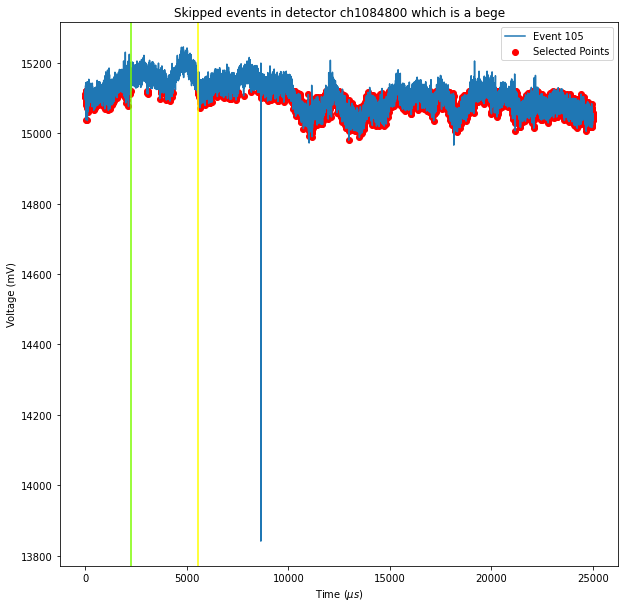

recovery rate 1464.8000000000002s
MICRODISCHARGE
Maximum difference: 1412.8000000000002, 1464.8000000000002
Next Maximum difference: 1363.2, 1410.4


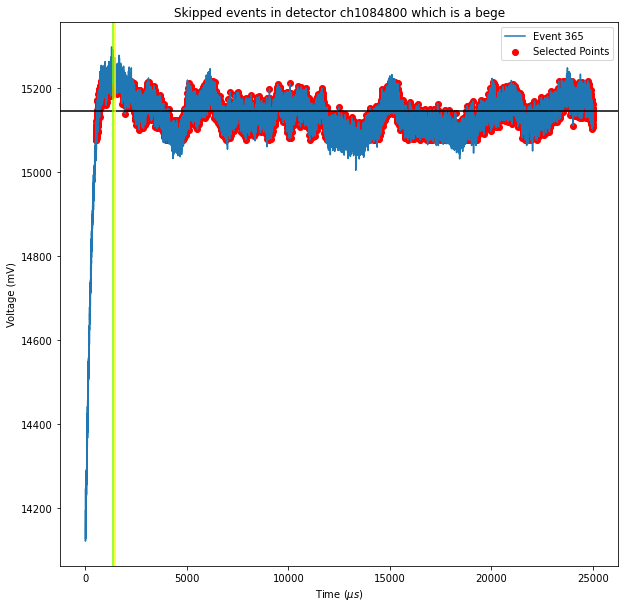

recovery rate 5317.6s
DISCHARGE
Maximum difference: 386.40000000000003, 5317.6
Next maximum difference: 5317.6, 5796.0


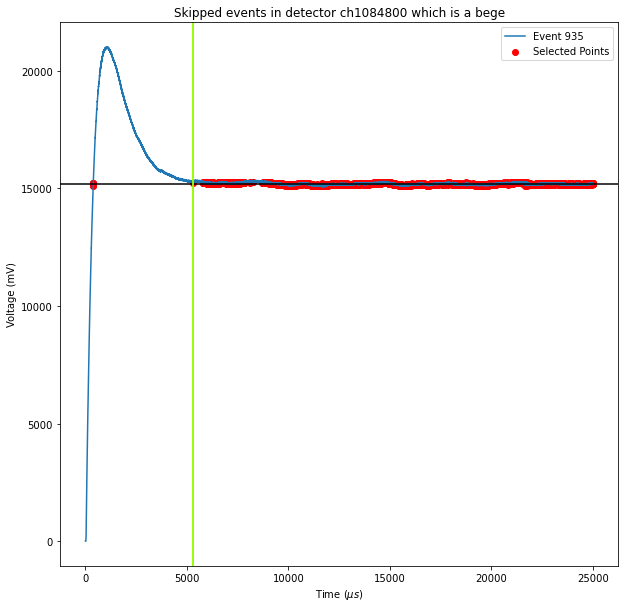

recovery rate -9415.199999999999s
MICRODISCHARGE
Maximum difference: 8643.2, 8645.6
Next Maximum difference: 18060.8, 18062.4


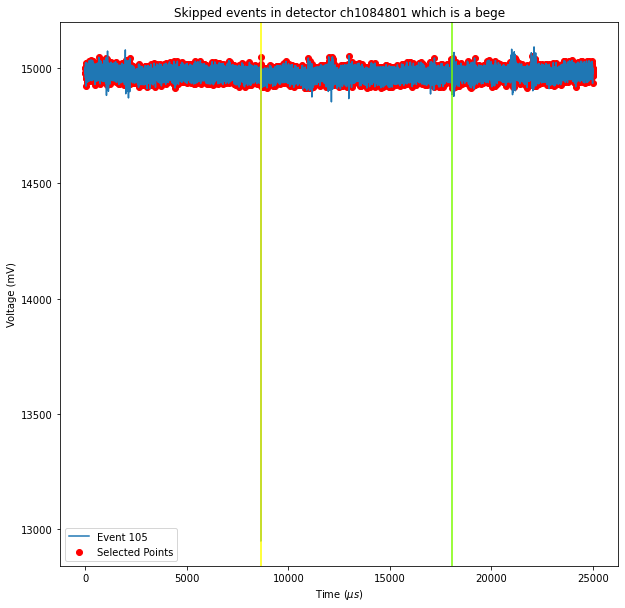

recovery rate 5000.0s
DISCHARGE
Maximum difference: 493.6, 5000.0
Next maximum difference: 5000.0, 5037.6


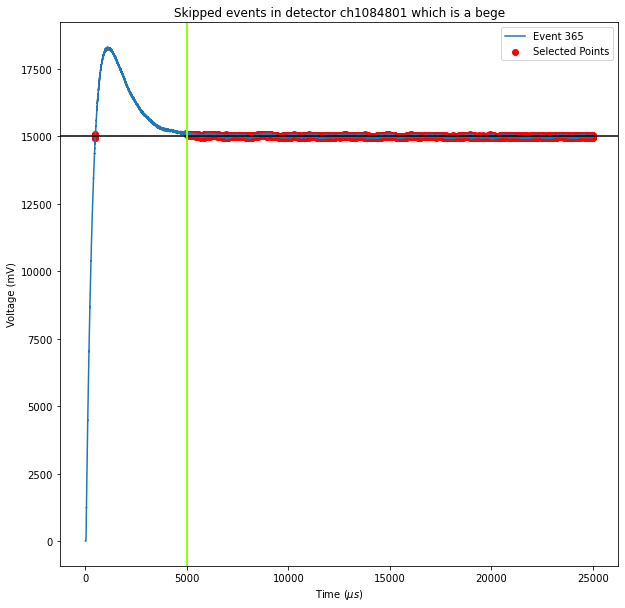

recovery rate -11.199999999999818s
MICRODISCHARGE
Maximum difference: 7332.8, 7339.200000000001
Next Maximum difference: 7350.400000000001, 7356.0


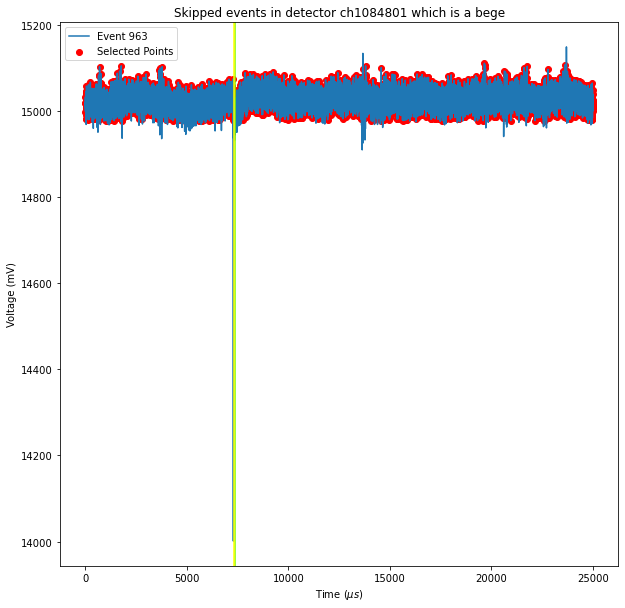

recovery rate 54.399999999999636s
MICRODISCHARGE
Maximum difference: 3135.2000000000003, 3144.0
Next Maximum difference: 3089.6000000000004, 3096.8


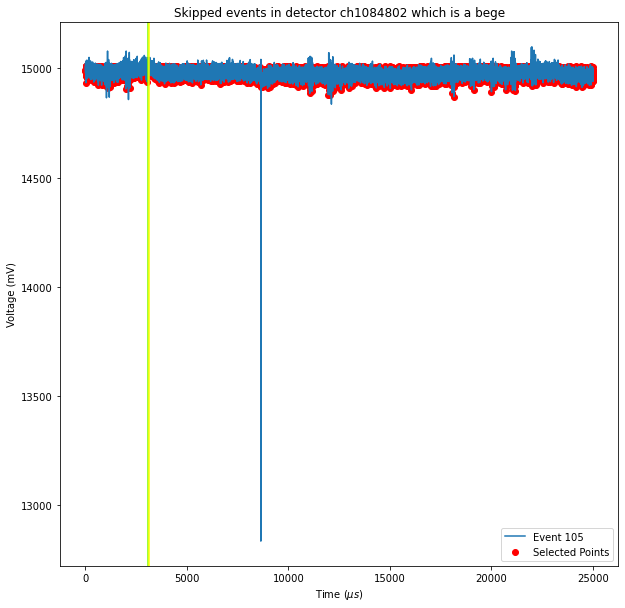

recovery rate -12.800000000000182s
MICRODISCHARGE
Maximum difference: 7288.8, 7349.6
Next Maximum difference: 7362.400000000001, 7380.0


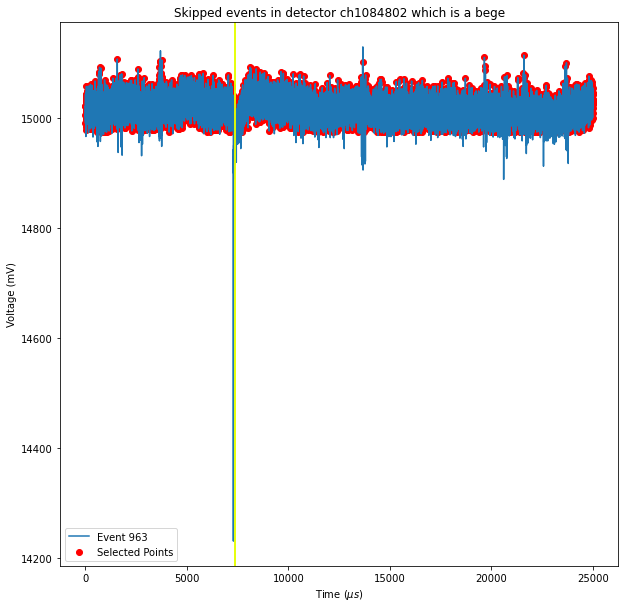

recovery rate 3293.6000000000004s
MICRODISCHARGE
Maximum difference: 8959.2, 11488.0
Next Maximum difference: 8194.4, 8857.6


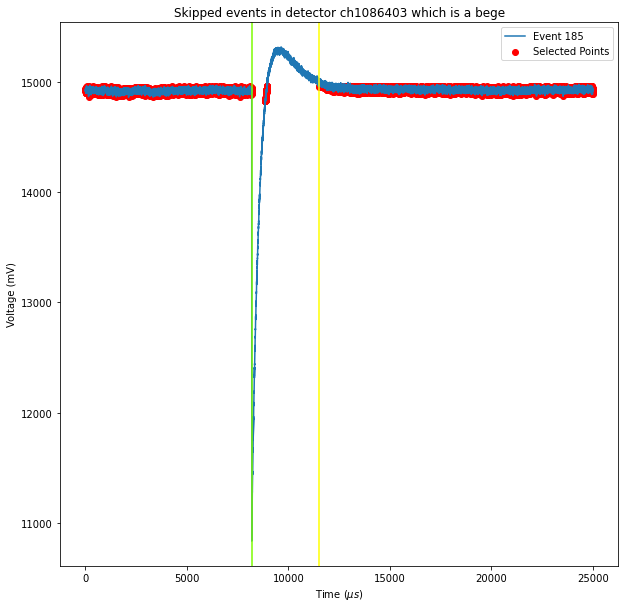

recovery rate 1821.6000000000001s
MICRODISCHARGE
Maximum difference: 622.4000000000001, 1821.6000000000001
Next Maximum difference: 1821.6000000000001, 1946.4


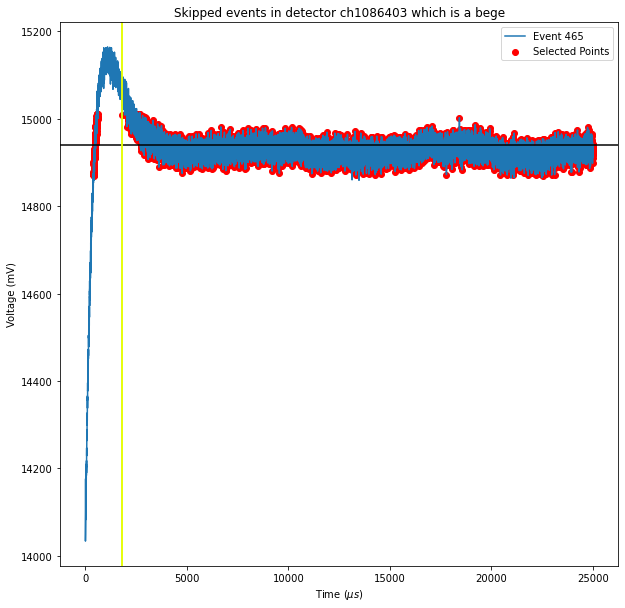

recovery rate -619.2000000000007s
MICRODISCHARGE
Maximum difference: 11274.400000000001, 11868.0
Next Maximum difference: 12487.2, 12612.0


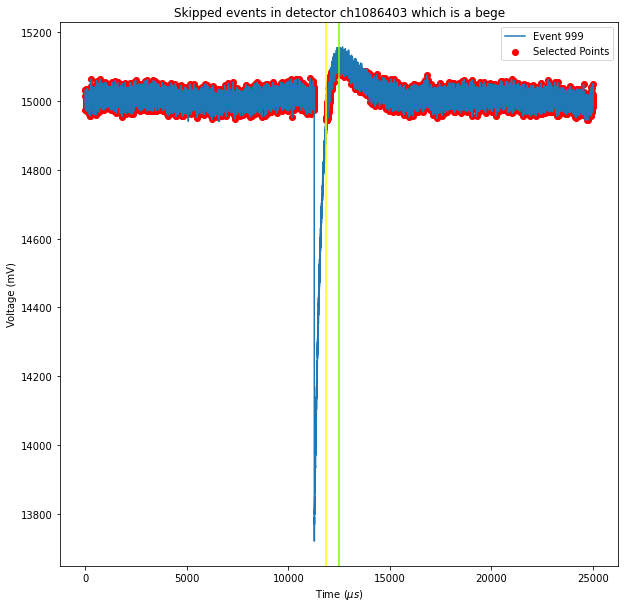

recovery rate 5205.6s
DISCHARGE
Maximum difference: 480.8, 5205.6
Next maximum difference: 5205.6, 5264.0


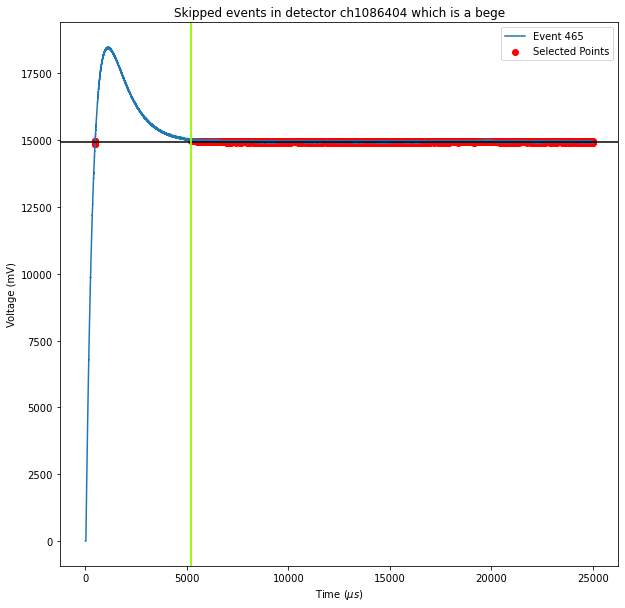

recovery rate 1566.4s
MICRODISCHARGE
Maximum difference: 766.4000000000001, 1566.4
Next Maximum difference: 714.4000000000001, 766.4000000000001


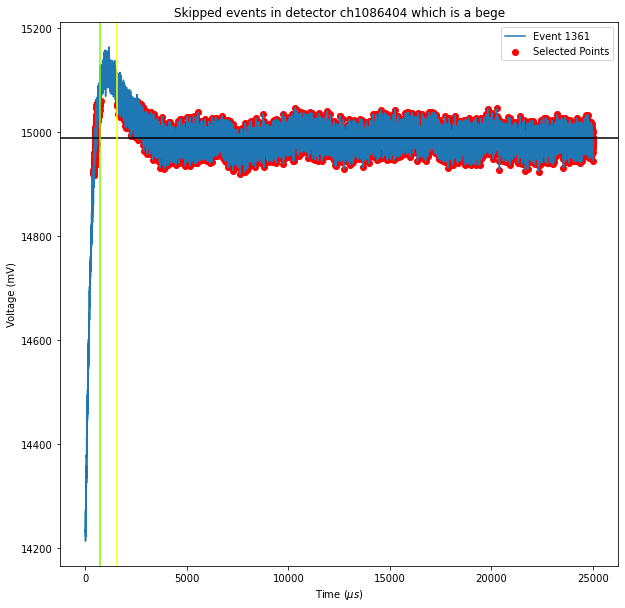

recovery rate 2654.3999999999996s
MICRODISCHARGE
Maximum difference: 10417.6, 12163.2
Next Maximum difference: 9508.800000000001, 10144.800000000001


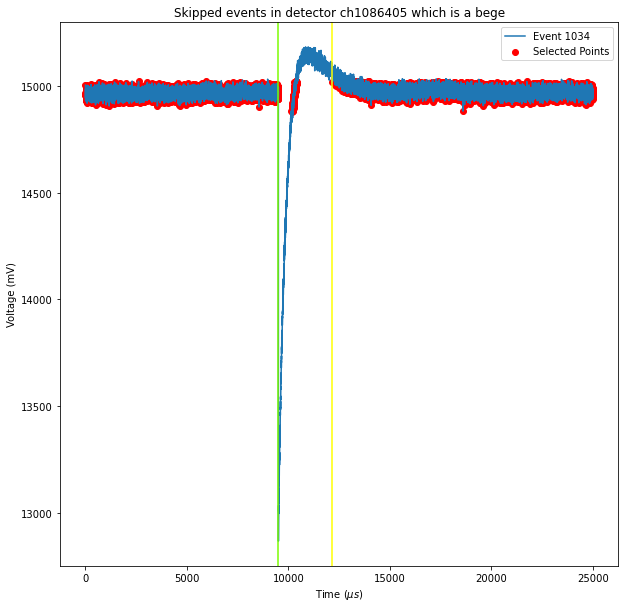

recovery rate 4976.0s
DISCHARGE
Maximum difference: 530.4, 4976.0
Next maximum difference: 5044.8, 5074.400000000001


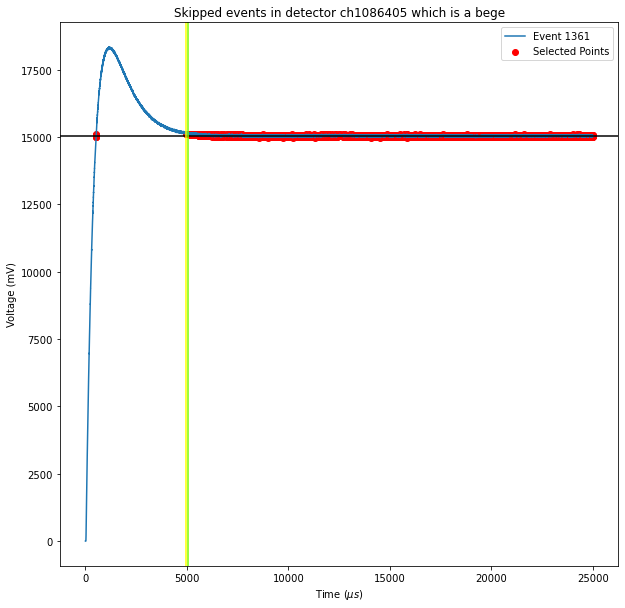

In [19]:
for j in detectors_bege:
    wfs_all = wfs_all_dict[j]
    index_skip1 = index_skipm[j]
    
    if len(index_skip1) < 20:
        for i in index_skip1:
            wf0 = wfs_all[i, :]
            mean_y = np.mean(wf0) 
            
            
            #weighted mean
            all_weight =[]
            for k in wf0:
                weight = abs(1/(k-mean_y))
                all_weight.append(weight)
                weighted_average = np.sum(k*weight)/np.sum(weight)
            
            #weighted standard deviation
            non_zero_weights = [weight for weight in all_weight if weight != 0]
            length1 = len(non_zero_weights)
            
            tops = []
            for k in wf0:
                weight = abs(1/(k-mean_y))
                top = weight*(k-weighted_average)**2
                tops.append(top)
            
            std_weight = np.sqrt(np.sum(tops)/((length1-1)*np.sum(all_weight)/length1))
            
            
                
            #print(std_weight)
            ts = np.arange(0, wf0.shape[0], 1) * 0.8  # micro s 
            #print(f"The mean y values is {mean_y}")
            #print(f"The weighted mean y values is {weighted_average}")
            plt.plot(ts[:], wf0[:], label=f'Event {i}')  # plot each skipped waveform
            
            for_append = []
            for_x = []
            if std_weight<72:
                # x values within the baseline range 
                # y values within the baseline range 
                for t, q in zip(ts, wf0):
                    if weighted_average-72 < q < weighted_average+72:
                        for_x.append(t)
                        for_append.append(q)
            else:
                for t, q in zip(ts, wf0):
                    if weighted_average-72 < q < weighted_average+72:
                        for_x.append(t)
                        for_append.append(q)
                
            
            # Plot the x values
            
            plt.scatter(for_x, for_append, color='r', label='Selected Points')
            x_diff = [for_x[i+1] - for_x[i] for i in range(len(for_x)-1)]
            
            if len(x_diff)>0:
                # Determine the index for the maximum difference
                max_diff_index = np.argmax(x_diff)

                masked_data = np.ma.masked_equal(x_diff, np.max(x_diff))

                next_max_index = np.argmax(masked_data)

                # Use the index to get the corresponding x values
                max_diff_x1 = for_x[max_diff_index]
                max_diff_x2 = for_x[max_diff_index + 1]

                max_diff_x3 = for_x[next_max_index]
                max_diff_x4 = for_x[next_max_index + 1]
                
                if (wf0[0]<14800):
                    rec_rate = max_diff_x2
                    print(f"recovery rate {rec_rate}s")
                    plt.axhline(y=weighted_average,color='k')
                else:
                    rec_rate = max_diff_x2-max_diff_x3
                    print(f"recovery rate {rec_rate}s")
                
                
                if np.any(wf0[:]==0):
                    discharge_type = "discharge"
                    #plt.axvline(x=rec_rate,color='lawngreen')
                    plt.axvline(x=max_diff_x2,color='yellow')
                    plt.axvline(x=max_diff_x3,color='lawngreen')
                    print("DISCHARGE")
                    print(f"Maximum difference: {max_diff_x1}, {max_diff_x2}")
                    print(f"Next maximum difference: {max_diff_x3}, {max_diff_x4}")
                    df = df.append({
                        'Detector Name': j,
                        'Event':i,
                        'Type': discharge_type,
                        'Recovery Rate': rec_rate
                    }, ignore_index=True)                    
                else:
                    discharge_type = "microdischarge"
                    plt.axvline(x=max_diff_x3,color='lawngreen')
                    plt.axvline(x=max_diff_x2,color='yellow')
                    print("MICRODISCHARGE")
                    print(f"Maximum difference: {max_diff_x1}, {max_diff_x2}")
                    print(f"Next Maximum difference: {max_diff_x3}, {max_diff_x4}")
                    df1 = df1.append({
                        'Detector Name': j,
                        'Event':i,
                        'Type': discharge_type,
                        'Recovery Rate': rec_rate
                    }, ignore_index=True)
            
            else:
                print("NO DISCHARGE")

            
            # Customize plot
            #plt.axhline(y=mean_y,color='lawngreen')
            #plt.axhline(y=weighted_average,color='k')
            plt.xlabel('Time ($\mu s$)')
            plt.ylabel('Voltage (mV)')
            plt.title(f'Skipped events in detector {j} which is a {test}')
            plt.legend()
            plt.show()